In [1]:
import os 
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

import scanpy as sc
import anndata as ann
import diffxpy.api as de
import batchglm.api as glm
from batchglm.pkg_constants import TF_CONFIG_PROTO
#data integration package
#import scIB 
import scanpy.external as sce

from scipy.sparse import csr_matrix
from matplotlib import rcParams
from matplotlib import colors

#import rpy2.rinterface_lib.callbacks
import logging, warnings
#from rpy2.robjects import pandas2ri
#import anndata2ri


sc.settings.verbosity = 3
sc.logging.print_versions()

/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages

scanpy==1.4.5.post3 anndata==0.7.1 umap==0.3.10 numpy==1.17.4 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()
de.__version__

logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 35)
warnings.filterwarnings("ignore", category=DeprecationWarning, module="tensorflow")

scanpy==1.4.5.post3 anndata==0.7.1 umap==0.3.10 numpy==1.17.4 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
#Set number of threads
TF_CONFIG_PROTO.inter_op_parallelism_threads = 1
TF_CONFIG_PROTO.intra_op_parallelism_threads = 12

In [4]:
adata = sc.read('./../data/processed/cellxgene.h5ad')

In [5]:
adata.rename_categories('louvain', ['Astro 1', 'Oligo 1', 'CCK 1', 'Oligo 2', 'Glut 1', 'Endothelial',\
                                    'Glut 2', 'Microglia 1', 'OPCs', 'Microglia 2', \
                                    'CCK 2 (?)', 'Pericytes', 'Glut 3', 'CCK 3', 'GABA', \
                                    'Endothelial 2', 'Astro 2', 'Cajal-Retzius', 'Astro 3', \
                                    'Neurons (?)', 'Oligo (?)', 'Choroid Plexus', 'Ependymal', \
                                    'CCK 4', 'NPCs', 'Vascular', 'Macrophages', 'Meningeal', '??'])

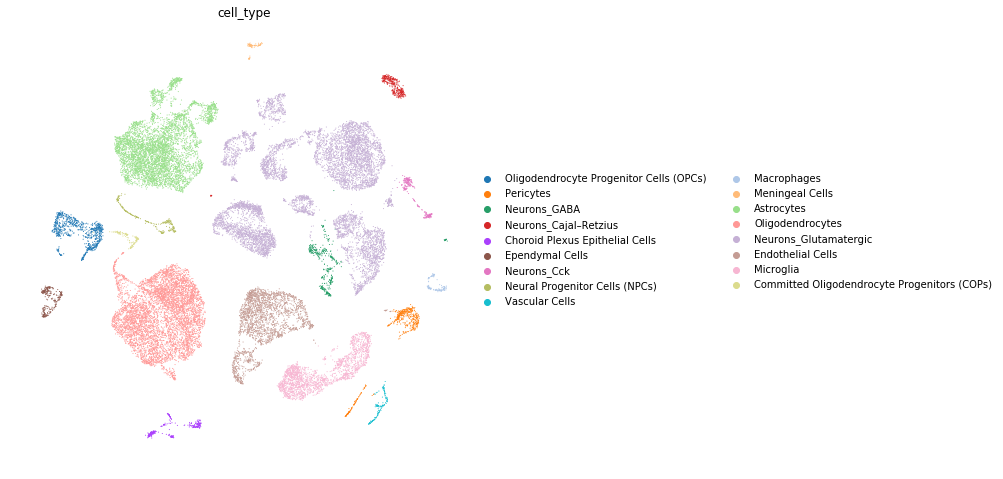

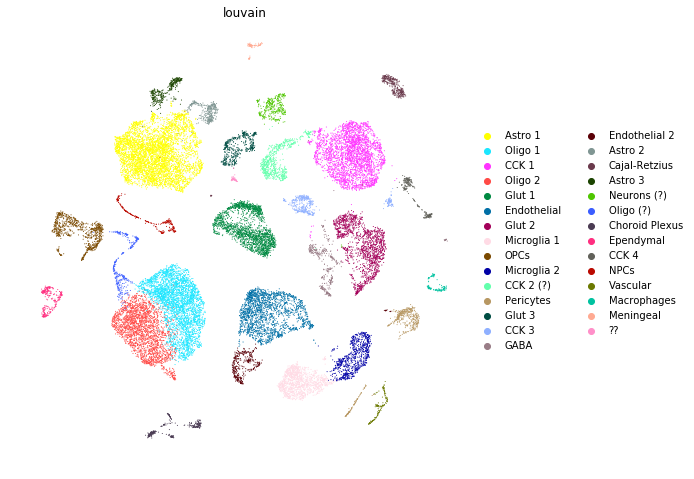

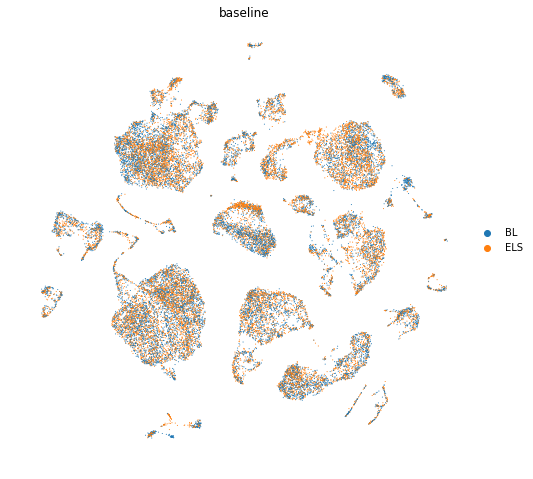

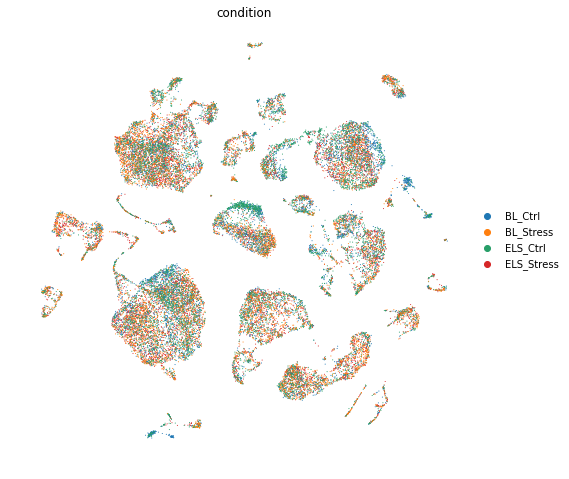

In [6]:
sc.pl.umap(adata, color='cell_type', frameon=False)
sc.pl.umap(adata, color='louvain', frameon=False)
sc.pl.umap(adata, color='baseline', frameon=False)
sc.pl.umap(adata, color='condition', frameon=False)

# Differential expression tests

The following differential tests helps us to understand the cell type characteristics. 

In [7]:
sc.tl.rank_genes_groups(adata, 'louvain')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:39)


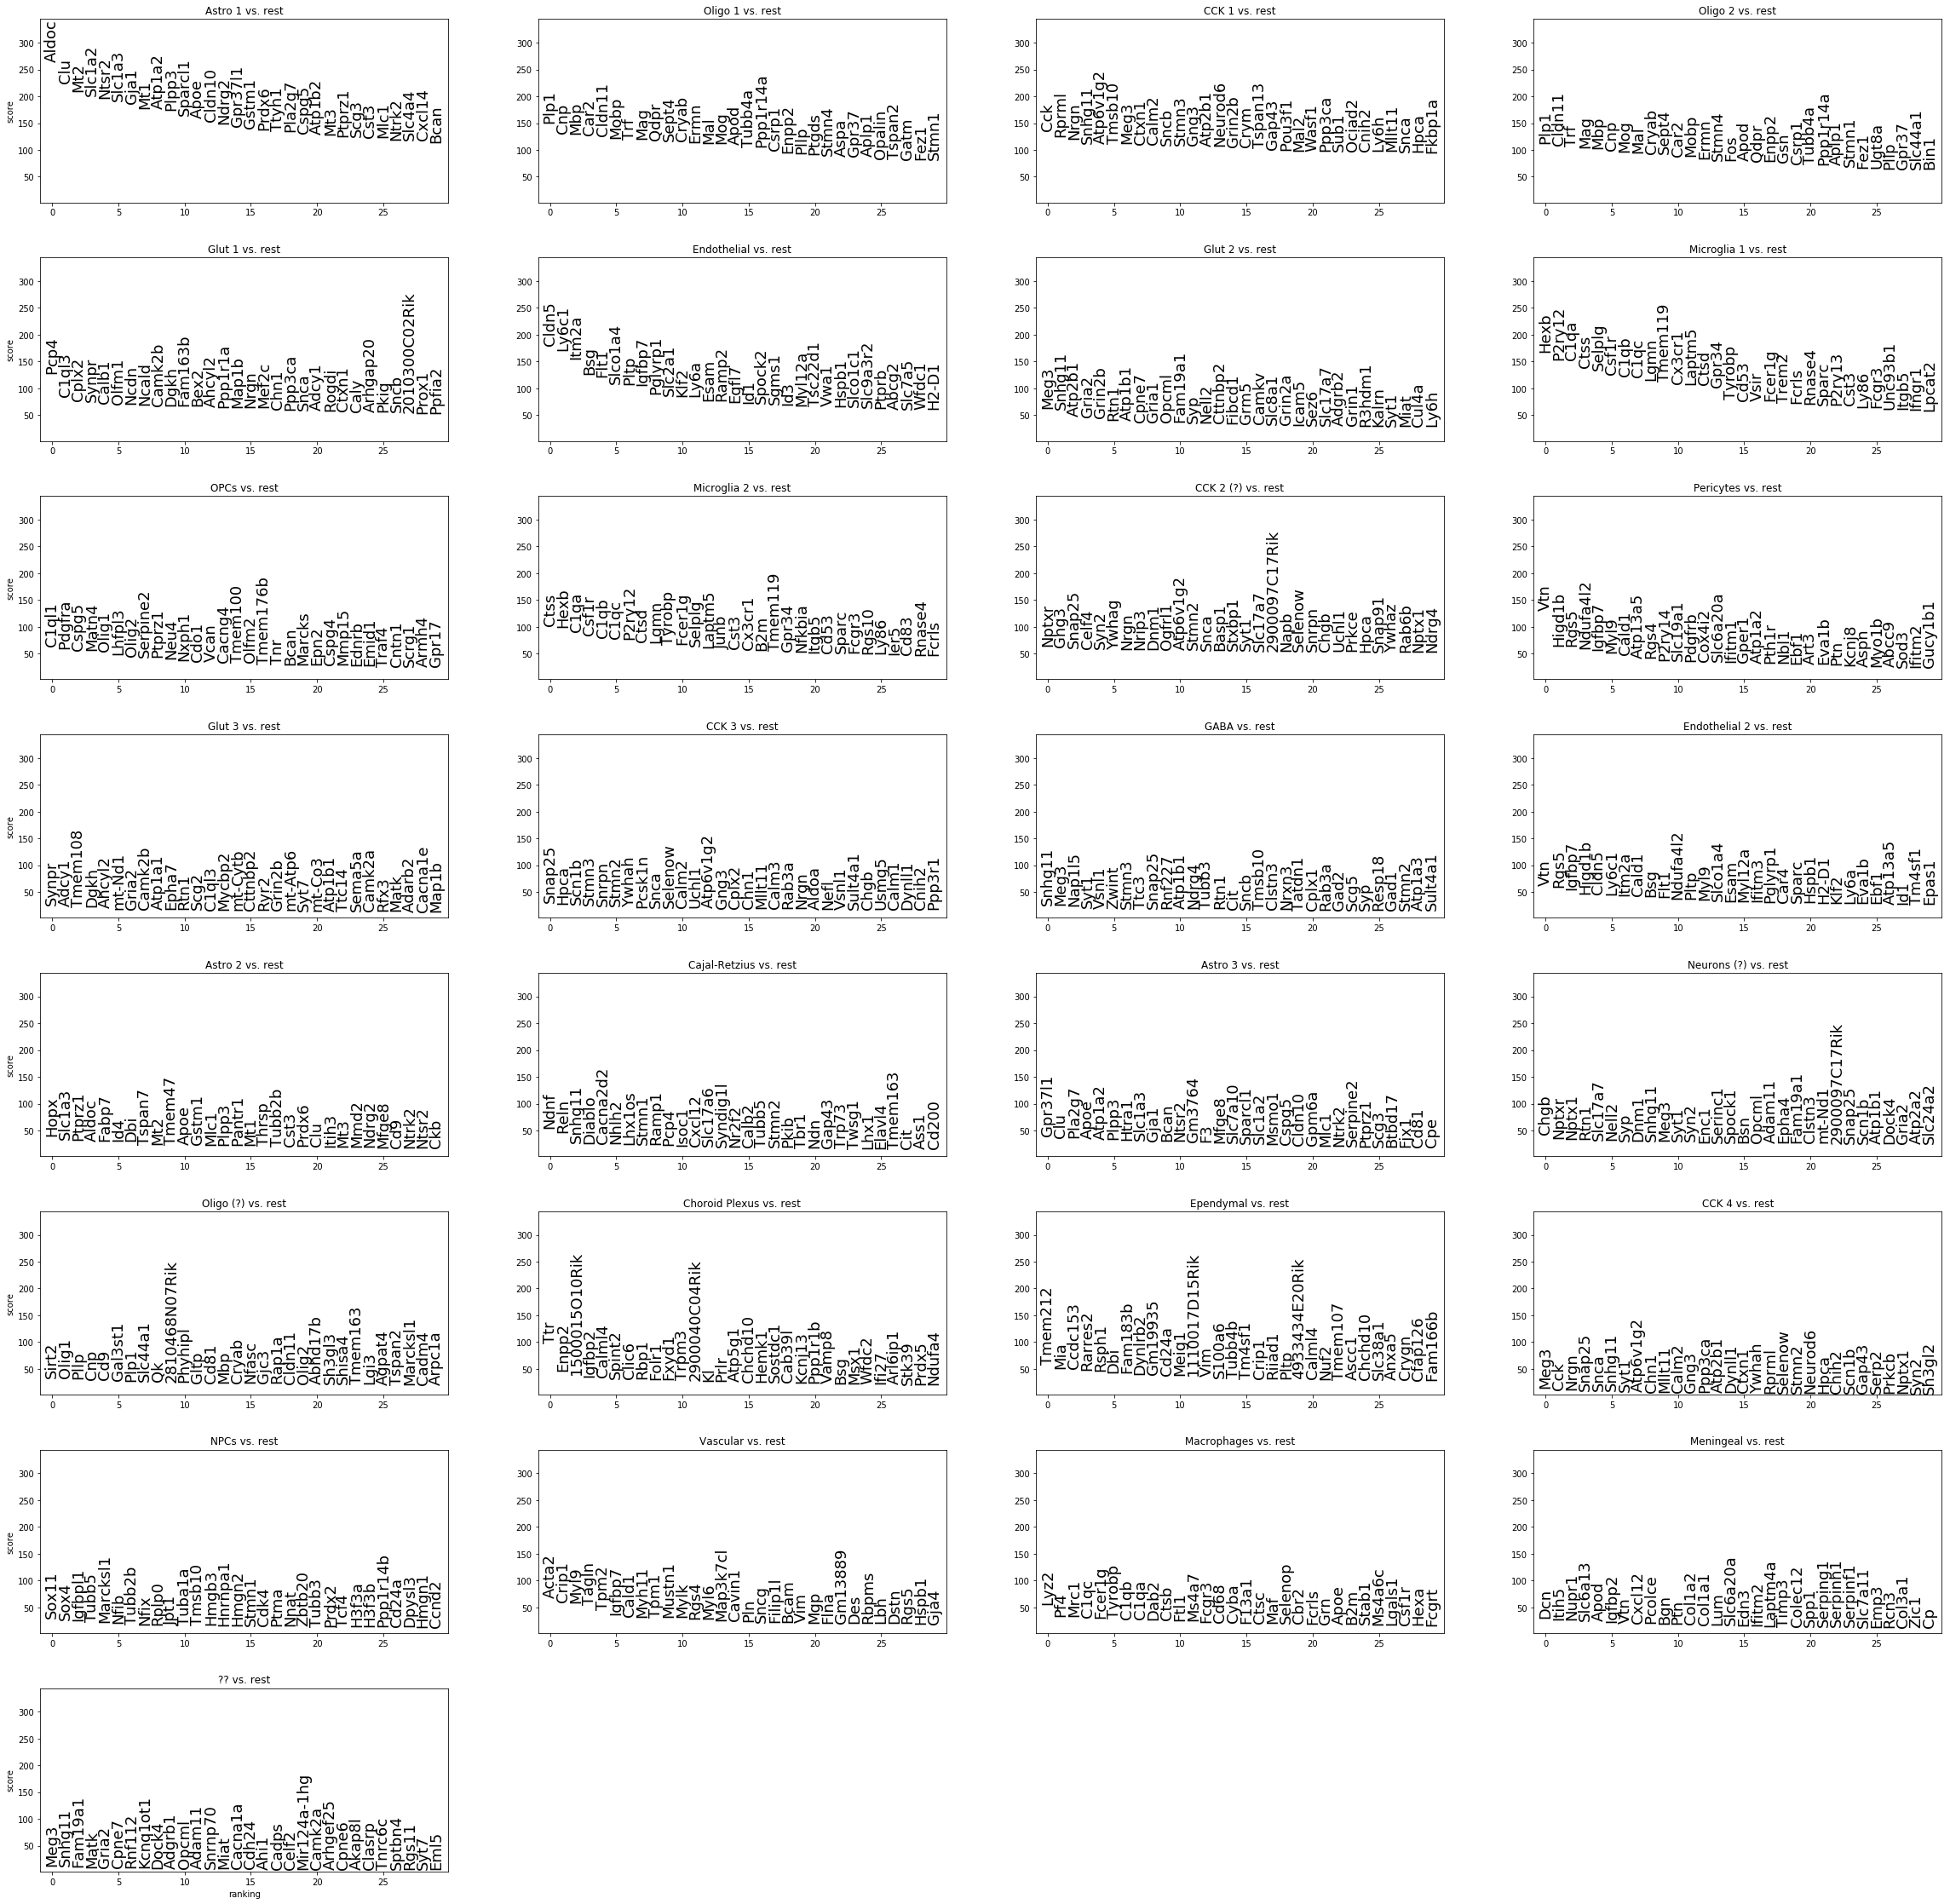

In [8]:
rcParams['figure.figsize']=(10,5)
sc.pl.rank_genes_groups(adata, n_genes=30, fontsize=18)

# Pairwise tests

In [ ]:
de_results_celltype = []
de_results_louvain = []
for test in ['BL', 'ELS']:
    adata_loop = adata[adata.obs['baseline'] == test]
    de_results = {'test': test, 'pair': 'baseline'}
    de_results_coarse = {'test': test, 'pair': 'baseline'}
    
    coefs = de.utils.preview_coef_names(
    sample_description=adata_loop.obs,
    formula="~1+condition", 
    )
    
        # Test the new "coarse" clusters quickly
    for clust in adata_loop.obs['cell_type'].cat.categories:
        adata_tmp = adata_loop[adata_loop.obs['cell_type'] == clust,:].copy()

        print(f'In cluster {clust}:')
        print(adata_tmp.obs.condition.value_counts())
        print(adata_tmp.obs.sample_id.value_counts())
        n_batch_clust = len(adata_tmp.obs.sample_id.unique())
        min_cell_batch = np.min(adata_tmp.obs.sample_id.value_counts())
        # Filter out genes to reduce multiple testing burden
        sc.pp.filter_genes(adata_tmp, min_cells=50)
        print(f'Testing {adata_tmp.n_vars} genes...')
        print("")
        try:
            test_tmp = de.test.wald(
            data=adata_tmp.layers['counts'],
            formula_loc="~ 1 + condition + size_factors",
            size_factors=['size_factors'],
            coef_to_test=[coefs[-1]],
            sample_description=adata_tmp.obs,
            gene_names=adata_tmp.var_names,
            constraints_loc={'sample_id':'condition'},
            noise_model='nb',
            dtype="float64",
            )
        except (np.linalg.LinAlgError, ValueError) as e:
            print('+++++/// Not enough sample ids in cluster! ///+++++')
            pass
        
        #Store the results
        de_results_coarse[clust] = test_tmp
        de_results_coarse['coef_test'] = coefs[-1]
            
    for clust in adata_loop.obs['louvain'].cat.categories:
        adata_tmp = adata_loop[adata_loop.obs['louvain'] == clust,:].copy()

        print(f'In cluster {clust}:')
        print(adata_tmp.obs.condition.value_counts())
        print(adata_tmp.obs.sample_id.value_counts())
        n_batch_clust = len(adata_tmp.obs.sample_id.unique())
        min_cell_batch = np.min(adata_tmp.obs.sample_id.value_counts())
        # Filter out genes to reduce multiple testing burden
        sc.pp.filter_genes(adata_tmp, min_cells=50)
        print(f'Testing {adata_tmp.n_vars} genes...')
        print("")
        try:
            test_tmp = de.test.wald(
            data=adata_tmp.layers['counts'],
            formula_loc="~ 1 + condition + size_factors",
            as_numeric=['size_factors'],
            coef_to_test=[coefs[-1]],
            sample_description=adata_tmp.obs,
            gene_names=adata_tmp.var_names,
            constraints_loc={'sample_id':'condition'},
            noise_model='nb',
            dtype="float64",
            )
        except (np.linalg.LinAlgError, ValueError) as e:
            print('+++++/// Not enough sample ids in cluster! ///+++++')
            pass

        #Store the results
        de_results[clust] = test_tmp
        de_results['coef_test'] = coefs[-1]
        
    de_results_celltype.append(de_results_coarse)
    de_results_louvain.append(de_results)

##########################################################
for test in ['Stress', 'Ctrl']:
    adata_loop = adata[adata.obs['adult_stress'] == test]
    de_results = {'test': test, 'pair': 'adult_stress'}
    de_results_coarse = {'test': test, 'pair': 'adult_stress'}

    coefs = de.utils.preview_coef_names(
    sample_description=adata_loop.obs,
    formula="~1+baseline", 
    )

    # Test the new "coarse" clusters quickly
    for clust in adata_loop.obs['cell_type'].cat.categories:
        adata_tmp = adata_loop[adata_loop.obs['cell_type'] == clust,:].copy()
        print(f'In cluster {clust}:')
        print(adata_tmp.obs.condition.value_counts())
        print(adata_tmp.obs.sample_id.value_counts())
        n_batch_clust = len(adata_tmp.obs.sample_id.unique())
        min_cell_batch = np.min(adata_tmp.obs.sample_id.value_counts())
        # Filter out genes to reduce multiple testing burden
        sc.pp.filter_genes(adata_tmp, min_cells=50)
        print(f'Testing {adata_tmp.n_vars} genes...')
        print("")
        try:
            test_tmp = de.test.wald(
            data=adata_tmp.layers['counts'],
            formula_loc="~ 1 + baseline + size_factors",
            as_numeric=['size_factors'],
            coef_to_test=[coefs[-1]],
            sample_description=adata_tmp.obs,
            gene_names=adata_tmp.var_names,
            constraints_loc={'sample_id':'baseline'},
            noise_model='nb',
            dtype="float64"
            )
        except (np.linalg.LinAlgError, ValueError) as e:
            print('+++++/// Not enough sample ids in cluster! ///+++++')
            pass
        #Store the results
        de_results_coarse[clust] = test_tmp
        de_results_coarse['coef_test'] = coefs[-1] 

    for clust in adata_loop.obs['louvain'].cat.categories:
        adata_tmp = adata_loop[adata_loop.obs['louvain'] == clust,:].copy()
        print(f'In cluster {clust}:')
        print(adata_tmp.obs.condition.value_counts())
        print(adata_tmp.obs.sample_id.value_counts())
        n_batch_clust = len(adata_tmp.obs.sample_id.unique())
        min_cell_batch = np.min(adata_tmp.obs.sample_id.value_counts())
        # Filter out genes to reduce multiple testing burden
        sc.pp.filter_genes(adata_tmp, min_cells=50)
        print(f'Testing {adata_tmp.n_vars} genes...')
        print("")
        try:
            test_tmp = de.test.wald(
            data=adata_tmp.layers['counts'],
            formula_loc="~ 1 + baseline + size_factors",
            as_numeric=['size_factors'],
            coef_to_test=[coefs[-1]],
            sample_description=adata_tmp.obs,
            gene_names=adata_tmp.var_names,
            constraints_loc={'sample_id':'baseline'},
            noise_model='nb',
            dtype="float64"
            )
        except (np.linalg.LinAlgError, ValueError) as e:
            print('+++++/// Not enough sample ids in cluster! ///+++++')
            pass
        #Store the results
        de_results[clust] = test_tmp
        de_results['coef_test'] = coefs[-1]
        
    de_results_celltype.append(de_results_coarse)
    de_results_louvain.append(de_results)

In cluster Oligodendrocyte Progenitor Cells (OPCs):
BL_Stress    284
BL_Ctrl      112
Name: condition, dtype: int64
ELS-27     145
ELS-71      76
ELS-47      73
ELS-103     66
ELS-11      26
ELS-105     10
Name: sample_id, dtype: int64
filtered out 14511 genes that are detected in less than 50 cells


Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 4417 genes...

iter   0: ll=23887503.179358
iter   1: ll=23814859.317102, converged: 0.00% (loc: 0.00%, scale update: False), in 0.82sec
iter   2: ll=23809008.034568, converged: 0.00% (loc: 20.24%, scale update: False), in 0.80sec
iter   3: ll=23808652.982031, converged: 0.00% (loc: 20.24%, scale update: False), in 0.86sec
iter   4: ll=23808574.993917, converged: 0.00% (loc: 22.50%, scale update: False), in 0.91sec
iter   5: ll=23808548.132990, converged: 0.00% (loc: 65.38%, scale update: False), in 0.82sec
iter   6: ll=23808538.399867, converged: 0.00% (loc: 83.47%, scale update: False), in 1.15sec
iter   7: ll=23808534.824584, converged: 0.00% (loc: 84.60%, scale update: False), in 1.08sec
iter   8: ll=23808533.509068, converged: 0.00% (loc: 84.74%, scale update: False), in 1.10sec
iter   9: ll=23808533.025076, converged: 0.00% (loc: 84.83%, scale update: False), in 1.03sec
iter  10: ll=23808532.847020, converged: 0.00% (loc: 84.88%, scale update: False), in 1.01sec
iter  11:

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 1249 genes...

iter   0: ll=12528124.443570
iter   1: ll=12519579.061532, converged: 0.00% (loc: 0.16%, scale update: False), in 0.36sec
iter   2: ll=12519197.089284, converged: 0.00% (loc: 34.35%, scale update: False), in 0.35sec
iter   3: ll=12519174.451716, converged: 0.00% (loc: 34.35%, scale update: False), in 0.34sec
iter   4: ll=12519169.744220, converged: 0.00% (loc: 51.24%, scale update: False), in 0.34sec
iter   5: ll=12519168.064188, converged: 0.00% (loc: 86.31%, scale update: False), in 0.33sec
iter   6: ll=12519167.443516, converged: 0.00% (loc: 95.20%, scale update: False), in 0.36sec
iter   7: ll=12519167.214755, converged: 0.00% (loc: 97.28%, scale update: False), in 0.36sec
iter   8: ll=12519167.130539, converged: 0.00% (loc: 97.52%, scale update: False), in 0.34sec
iter   9: ll=12519167.099549, converged: 0.00% (loc: 97.84%, scale update: False), in 0.45sec
iter  10: ll=12519167.088148, converged: 0.00% (loc: 98.32%, scale update: False), in 0.34sec
iter  11:

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 4603 genes...

iter   0: ll=2380204.717545
iter   1: ll=2258967.090179, converged: 0.00% (loc: 0.00%, scale update: False), in 1.23sec
iter   2: ll=2232695.232047, converged: 0.00% (loc: 1.22%, scale update: False), in 1.22sec
iter   3: ll=2230313.860254, converged: 0.00% (loc: 1.22%, scale update: False), in 1.22sec
iter   4: ll=2230213.149616, converged: 0.00% (loc: 1.22%, scale update: False), in 1.21sec
iter   5: ll=2230201.657230, converged: 0.00% (loc: 4.19%, scale update: False), in 1.22sec
iter   6: ll=2230198.111125, converged: 0.00% (loc: 35.17%, scale update: False), in 1.29sec
iter   7: ll=2230196.839081, converged: 0.00% (loc: 72.39%, scale update: False), in 1.21sec
iter   8: ll=2230196.373899, converged: 0.00% (loc: 88.94%, scale update: False), in 1.16sec
iter   9: ll=2230196.203162, converged: 0.00% (loc: 95.46%, scale update: False), in 1.18sec
iter  10: ll=2230196.140421, converged: 0.00% (loc: 97.44%, scale update: False), in 1.07sec
iter  11: ll=1098616.933

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 1445 genes...

iter   0: ll=6347622.924075
iter   1: ll=6326640.156901, converged: 0.00% (loc: 0.00%, scale update: False), in 0.46sec
iter   2: ll=6324753.495548, converged: 0.00% (loc: 17.30%, scale update: False), in 0.43sec
iter   3: ll=6324646.822333, converged: 0.00% (loc: 17.30%, scale update: False), in 0.44sec
iter   4: ll=6324632.869003, converged: 0.00% (loc: 17.92%, scale update: False), in 0.42sec
iter   5: ll=6324628.237538, converged: 0.00% (loc: 54.95%, scale update: False), in 0.43sec
iter   6: ll=6324626.528849, converged: 0.00% (loc: 93.43%, scale update: False), in 0.45sec
iter   7: ll=6324625.899164, converged: 0.00% (loc: 96.54%, scale update: False), in 0.46sec
iter   8: ll=6324625.667366, converged: 0.00% (loc: 97.09%, scale update: False), in 0.45sec
iter   9: ll=6324625.582072, converged: 0.00% (loc: 97.09%, scale update: False), in 0.42sec
iter  10: ll=6324625.550691, converged: 0.00% (loc: 97.09%, scale update: False), in 0.42sec
iter  11: ll=275751.

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-103]=0


Testing 2106 genes...

+++++/// Not enough sample ids in cluster! ///+++++
In cluster Ependymal Cells:
BL_Stress    100
BL_Ctrl       29
Name: condition, dtype: int64
ELS-47     51
ELS-103    34
ELS-71     17
ELS-27     15
ELS-11     12
Name: sample_id, dtype: int64
filtered out 17447 genes that are detected in less than 50 cells


Built constraints: sample_id[ELS-11]+sample_id[ELS-71]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 1481 genes...

iter   0: ll=816321.282595
iter   1: ll=791626.829417, converged: 0.00% (loc: 0.07%, scale update: False), in 0.47sec
iter   2: ll=788460.192205, converged: 0.00% (loc: 1.62%, scale update: False), in 0.47sec
iter   3: ll=788367.484888, converged: 0.00% (loc: 1.62%, scale update: False), in 0.45sec
iter   4: ll=788363.464852, converged: 0.00% (loc: 2.43%, scale update: False), in 0.43sec
iter   5: ll=788362.375407, converged: 0.00% (loc: 37.34%, scale update: False), in 0.40sec
iter   6: ll=788361.974957, converged: 0.00% (loc: 83.73%, scale update: False), in 0.40sec
iter   7: ll=788361.827062, converged: 0.00% (loc: 97.91%, scale update: False), in 0.44sec
iter   8: ll=788361.772569, converged: 0.00% (loc: 99.12%, scale update: False), in 0.41sec
iter   9: ll=788361.752511, converged: 0.00% (loc: 99.32%, scale update: False), in 0.30sec
iter  10: ll=788361.745130, converged: 0.00% (loc: 99.32%, scale update: False), in 0.28sec
iter  11: ll=266528.222764, conver

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 933 genes...

iter   0: ll=6872222.457837
iter   1: ll=6865855.798996, converged: 0.00% (loc: 1.29%, scale update: False), in 0.32sec
iter   2: ll=6865215.248937, converged: 0.00% (loc: 28.08%, scale update: False), in 0.33sec
iter   3: ll=6865113.023066, converged: 0.00% (loc: 28.08%, scale update: False), in 0.30sec
iter   4: ll=6865085.982284, converged: 0.00% (loc: 30.76%, scale update: False), in 0.31sec
iter   5: ll=6865076.101687, converged: 0.00% (loc: 44.27%, scale update: False), in 0.31sec
iter   6: ll=6865071.460551, converged: 0.00% (loc: 51.02%, scale update: False), in 0.33sec
iter   7: ll=6865068.779777, converged: 0.00% (loc: 53.70%, scale update: False), in 0.32sec
iter   8: ll=6865067.157820, converged: 0.00% (loc: 54.45%, scale update: False), in 0.31sec
iter   9: ll=6865066.407545, converged: 0.00% (loc: 54.66%, scale update: False), in 0.32sec
iter  10: ll=6865066.235531, converged: 0.00% (loc: 54.66%, scale update: False), in 0.30sec
iter  11: ll=189727.1

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 728 genes...

iter   0: ll=479604.718541
iter   1: ll=469078.220652, converged: 0.00% (loc: 0.00%, scale update: False), in 0.30sec
iter   2: ll=467680.510055, converged: 0.00% (loc: 2.06%, scale update: False), in 0.26sec
iter   3: ll=467590.346878, converged: 0.00% (loc: 2.06%, scale update: False), in 0.26sec
iter   4: ll=467572.175251, converged: 0.00% (loc: 2.20%, scale update: False), in 0.28sec
iter   5: ll=467565.721513, converged: 0.00% (loc: 13.19%, scale update: False), in 0.26sec
iter   6: ll=467563.319237, converged: 0.00% (loc: 38.32%, scale update: False), in 0.24sec
iter   7: ll=467562.429426, converged: 0.00% (loc: 57.42%, scale update: False), in 0.24sec
iter   8: ll=467562.101227, converged: 0.00% (loc: 65.52%, scale update: False), in 0.25sec
iter   9: ll=467561.980398, converged: 0.00% (loc: 68.27%, scale update: False), in 0.27sec
iter  10: ll=467561.935944, converged: 0.00% (loc: 69.64%, scale update: False), in 0.25sec
iter  11: ll=124011.902962, converg

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 247 genes...

iter   0: ll=337573.241470
iter   1: ll=335311.265843, converged: 0.00% (loc: 0.81%, scale update: False), in 0.18sec
iter   2: ll=335055.153622, converged: 0.00% (loc: 4.45%, scale update: False), in 0.19sec
iter   3: ll=335026.330885, converged: 0.00% (loc: 4.45%, scale update: False), in 0.17sec
iter   4: ll=335019.790906, converged: 0.00% (loc: 4.86%, scale update: False), in 0.19sec
iter   5: ll=335017.533840, converged: 0.00% (loc: 28.34%, scale update: False), in 0.18sec
iter   6: ll=335016.690143, converged: 0.00% (loc: 58.30%, scale update: False), in 0.17sec
iter   7: ll=335016.374066, converged: 0.00% (loc: 67.61%, scale update: False), in 0.15sec
iter   8: ll=335016.256142, converged: 0.00% (loc: 69.64%, scale update: False), in 0.15sec
iter   9: ll=335016.212392, converged: 0.00% (loc: 70.04%, scale update: False), in 0.15sec
iter  10: ll=335016.196077, converged: 0.00% (loc: 70.45%, scale update: False), in 0.15sec
iter  11: ll=33431.081505, converge

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 0 genes...

iter   0: ll=0.000000


/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]


In cluster Meningeal Cells:
BL_Ctrl      26
BL_Stress    24
Name: condition, dtype: int64
ELS-71     25
ELS-103    14
ELS-27      6
ELS-47      4
ELS-11      1
Name: sample_id, dtype: int64
filtered out 18921 genes that are detected in less than 50 cells


Built constraints: sample_id[ELS-11]+sample_id[ELS-71]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 7 genes...

iter   0: ll=1158.419618
iter   1: ll=1096.136600, converged: 0.00% (loc: 0.00%, scale update: False), in 0.11sec
iter   2: ll=1090.531899, converged: 0.00% (loc: 0.00%, scale update: False), in 0.10sec
iter   3: ll=1090.207357, converged: 0.00% (loc: 0.00%, scale update: False), in 0.09sec
iter   4: ll=1090.190472, converged: 0.00% (loc: 0.00%, scale update: False), in 0.11sec
iter   5: ll=1090.190365, converged: 0.00% (loc: 28.57%, scale update: False), in 0.11sec
iter   6: ll=1090.190365, converged: 0.00% (loc: 71.43%, scale update: False), in 0.11sec
iter   7: ll=1090.190364, converged: 0.00% (loc: 85.71%, scale update: False), in 0.10sec
iter   8: ll=1090.190364, converged: 0.00% (loc: 100.00%, scale update: False), in 0.10sec
iter   9: ll=1051.637762, converged: 0.00% (loc: 0.00%, scale update: True), in 0.50sec
iter  10: ll=1051.480446, converged: 0.00% (loc: 0.00%, scale update: False), in 0.12sec
iter  11: ll=1051.479300, converged: 0.00% (loc: 0.00%, scale

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 9517 genes...

iter   0: ll=56685025.290919
iter   1: ll=56205924.863606, converged: 0.00% (loc: 0.03%, scale update: False), in 5.11sec
iter   2: ll=56167128.610682, converged: 0.00% (loc: 12.90%, scale update: False), in 5.38sec
iter   3: ll=56166232.688107, converged: 0.00% (loc: 12.91%, scale update: False), in 4.97sec
iter   4: ll=56166141.152860, converged: 0.00% (loc: 17.33%, scale update: False), in 5.06sec
iter   5: ll=56166115.594661, converged: 0.00% (loc: 83.62%, scale update: False), in 4.85sec
iter   6: ll=56166107.568721, converged: 0.00% (loc: 95.71%, scale update: False), in 3.08sec
iter   7: ll=56166104.907336, converged: 0.00% (loc: 96.61%, scale update: False), in 2.04sec
iter   8: ll=56166103.952576, converged: 0.00% (loc: 96.83%, scale update: False), in 2.05sec
iter   9: ll=56166103.601331, converged: 0.00% (loc: 96.88%, scale update: False), in 2.00sec
iter  10: ll=56166103.471921, converged: 0.00% (loc: 96.89%, scale update: False), in 2.08sec
iter  11:

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 9170 genes...

iter   0: ll=58929828.337142
iter   1: ll=58184902.005126, converged: 0.00% (loc: 0.07%, scale update: False), in 5.64sec
iter   2: ll=58109888.624662, converged: 0.00% (loc: 10.97%, scale update: False), in 5.92sec
iter   3: ll=58107686.333998, converged: 0.00% (loc: 10.97%, scale update: False), in 5.55sec
iter   4: ll=58107554.331923, converged: 0.00% (loc: 11.50%, scale update: False), in 5.31sec
iter   5: ll=58107522.579869, converged: 0.00% (loc: 75.47%, scale update: False), in 5.39sec
iter   6: ll=58107513.350862, converged: 0.00% (loc: 94.60%, scale update: False), in 3.76sec
iter   7: ll=58107510.115902, converged: 0.00% (loc: 96.61%, scale update: False), in 2.19sec
iter   8: ll=58107508.944007, converged: 0.00% (loc: 97.10%, scale update: False), in 2.09sec
iter   9: ll=58107508.513899, converged: 0.00% (loc: 97.34%, scale update: False), in 2.27sec
iter  10: ll=58107508.359756, converged: 0.00% (loc: 97.52%, scale update: False), in 2.13sec
iter  11:

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 12202 genes...

iter   0: ll=44327005.908588
iter   1: ll=41866183.348469, converged: 0.00% (loc: 0.01%, scale update: False), in 8.58sec
iter   2: ll=41435745.608240, converged: 0.00% (loc: 2.70%, scale update: False), in 8.58sec
iter   3: ll=41407438.133126, converged: 0.00% (loc: 2.70%, scale update: False), in 8.93sec
iter   4: ll=41406876.019750, converged: 0.00% (loc: 2.75%, scale update: False), in 9.29sec
iter   5: ll=41406818.458623, converged: 0.00% (loc: 39.96%, scale update: False), in 8.98sec
iter   6: ll=41406806.277065, converged: 0.00% (loc: 88.40%, scale update: False), in 7.34sec
iter   7: ll=41406803.817168, converged: 0.00% (loc: 97.26%, scale update: False), in 4.89sec
iter   8: ll=41406803.103803, converged: 0.00% (loc: 98.49%, scale update: False), in 2.81sec
iter   9: ll=41406802.853109, converged: 0.00% (loc: 98.72%, scale update: False), in 2.83sec
iter  10: ll=41406802.761096, converged: 0.00% (loc: 98.82%, scale update: False), in 3.13sec
iter  11: l

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 7288 genes...

iter   0: ll=25291349.108470
iter   1: ll=24991863.504882, converged: 0.00% (loc: 0.00%, scale update: False), in 2.57sec
iter   2: ll=24954991.204054, converged: 0.00% (loc: 10.40%, scale update: False), in 2.40sec
iter   3: ll=24953996.664274, converged: 0.00% (loc: 10.40%, scale update: False), in 2.27sec
iter   4: ll=24953903.478033, converged: 0.00% (loc: 10.65%, scale update: False), in 2.20sec
iter   5: ll=24953873.643732, converged: 0.00% (loc: 55.19%, scale update: False), in 2.17sec
iter   6: ll=24953862.761677, converged: 0.00% (loc: 88.17%, scale update: False), in 1.61sec
iter   7: ll=24953858.761761, converged: 0.00% (loc: 91.15%, scale update: False), in 1.76sec
iter   8: ll=24953857.279794, converged: 0.00% (loc: 91.73%, scale update: False), in 1.62sec
iter   9: ll=24953856.731706, converged: 0.00% (loc: 92.07%, scale update: False), in 1.62sec
iter  10: ll=24953856.524595, converged: 0.00% (loc: 92.21%, scale update: False), in 1.66sec
iter  11:

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 5512 genes...

iter   0: ll=37089189.796082
iter   1: ll=36965915.385128, converged: 0.00% (loc: 0.15%, scale update: False), in 1.64sec
iter   2: ll=36955829.015684, converged: 0.00% (loc: 21.06%, scale update: False), in 1.67sec
iter   3: ll=36955381.931776, converged: 0.00% (loc: 21.06%, scale update: False), in 1.38sec
iter   4: ll=36955300.409381, converged: 0.00% (loc: 24.89%, scale update: False), in 1.60sec
iter   5: ll=36955273.816129, converged: 0.00% (loc: 66.67%, scale update: False), in 1.51sec
iter   6: ll=36955264.536813, converged: 0.00% (loc: 84.11%, scale update: False), in 1.03sec
iter   7: ll=36955261.099088, converged: 0.00% (loc: 88.24%, scale update: False), in 1.04sec
iter   8: ll=36955259.871717, converged: 0.00% (loc: 89.08%, scale update: False), in 1.24sec
iter   9: ll=36955259.452548, converged: 0.00% (loc: 89.62%, scale update: False), in 1.25sec
iter  10: ll=36955259.300773, converged: 0.00% (loc: 89.73%, scale update: False), in 0.92sec
iter  11:

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 43 genes...

iter   0: ll=7826.765219
iter   1: ll=7335.295088, converged: 0.00% (loc: 0.00%, scale update: False), in 0.10sec
iter   2: ll=7251.703745, converged: 0.00% (loc: 0.00%, scale update: False), in 0.10sec
iter   3: ll=7245.292007, converged: 0.00% (loc: 0.00%, scale update: False), in 0.10sec
iter   4: ll=7245.064899, converged: 0.00% (loc: 0.00%, scale update: False), in 0.09sec
iter   5: ll=7245.053448, converged: 0.00% (loc: 2.33%, scale update: False), in 0.10sec
iter   6: ll=7245.052365, converged: 0.00% (loc: 25.58%, scale update: False), in 0.09sec
iter   7: ll=7245.052230, converged: 0.00% (loc: 53.49%, scale update: False), in 0.09sec
iter   8: ll=7245.052212, converged: 0.00% (loc: 83.72%, scale update: False), in 0.10sec
iter   9: ll=7245.052209, converged: 0.00% (loc: 93.02%, scale update: False), in 0.09sec
iter  10: ll=7245.052209, converged: 0.00% (loc: 97.67%, scale update: False), in 0.09sec
iter  11: ll=7063.481059, converged: 0.00% (loc: 0.00%, sca

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 9173 genes...

iter   0: ll=55470286.005853
iter   1: ll=55064861.080285, converged: 0.00% (loc: 0.01%, scale update: False), in 5.10sec
iter   2: ll=55034507.580636, converged: 0.00% (loc: 13.81%, scale update: False), in 5.25sec
iter   3: ll=55033748.930978, converged: 0.00% (loc: 13.81%, scale update: False), in 4.85sec
iter   4: ll=55033654.267170, converged: 0.00% (loc: 17.98%, scale update: False), in 4.96sec
iter   5: ll=55033626.398249, converged: 0.00% (loc: 84.23%, scale update: False), in 4.97sec
iter   6: ll=55033617.219922, converged: 0.00% (loc: 95.01%, scale update: False), in 3.13sec
iter   7: ll=55033614.145955, converged: 0.00% (loc: 95.60%, scale update: False), in 1.83sec
iter   8: ll=55033613.060702, converged: 0.00% (loc: 95.72%, scale update: False), in 1.87sec
iter   9: ll=55033612.663062, converged: 0.00% (loc: 95.84%, scale update: False), in 1.72sec
iter  10: ll=55033612.516771, converged: 0.00% (loc: 95.86%, scale update: False), in 1.78sec
iter  11:

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


iter   0: ll=55343379.217862
iter   1: ll=54940295.616985, converged: 0.00% (loc: 0.03%, scale update: False), in 3.84sec
iter   2: ll=54901982.906489, converged: 0.00% (loc: 16.57%, scale update: False), in 3.72sec
iter   3: ll=54900878.200999, converged: 0.00% (loc: 16.57%, scale update: False), in 4.05sec
iter   4: ll=54900801.429989, converged: 0.00% (loc: 17.19%, scale update: False), in 3.71sec
iter   5: ll=54900780.256911, converged: 0.00% (loc: 77.90%, scale update: False), in 3.77sec
iter   6: ll=54900773.117018, converged: 0.00% (loc: 95.80%, scale update: False), in 2.72sec
iter   7: ll=54900770.591196, converged: 0.00% (loc: 97.53%, scale update: False), in 1.54sec
iter   8: ll=54900769.671859, converged: 0.00% (loc: 97.79%, scale update: False), in 1.61sec
iter   9: ll=54900769.333732, converged: 0.00% (loc: 97.85%, scale update: False), in 1.58sec
iter  10: ll=54900769.209341, converged: 0.00% (loc: 97.93%, scale update: False), in 1.63sec
iter  11: ll=6574514.928120, con

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 10522 genes...

iter   0: ll=37565023.430095
iter   1: ll=36855057.499959, converged: 0.00% (loc: 0.00%, scale update: False), in 4.54sec
iter   2: ll=36777490.907437, converged: 0.00% (loc: 6.57%, scale update: False), in 4.54sec
iter   3: ll=36775149.382348, converged: 0.00% (loc: 6.57%, scale update: False), in 4.40sec
iter   4: ll=36775048.006746, converged: 0.00% (loc: 6.87%, scale update: False), in 4.46sec
iter   5: ll=36775023.124454, converged: 0.00% (loc: 75.20%, scale update: False), in 4.48sec
iter   6: ll=36775016.806454, converged: 0.00% (loc: 95.34%, scale update: False), in 2.61sec
iter   7: ll=36775014.906163, converged: 0.00% (loc: 97.17%, scale update: False), in 2.13sec
iter   8: ll=36775014.227006, converged: 0.00% (loc: 97.77%, scale update: False), in 2.13sec
iter   9: ll=36775013.977819, converged: 0.00% (loc: 98.00%, scale update: False), in 1.86sec
iter  10: ll=36775013.886244, converged: 0.00% (loc: 98.06%, scale update: False), in 2.12sec
iter  11: l

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 6906 genes...

iter   0: ll=46889028.866245
iter   1: ll=46615933.492925, converged: 0.00% (loc: 0.01%, scale update: False), in 2.35sec
iter   2: ll=46593036.236681, converged: 0.00% (loc: 17.68%, scale update: False), in 2.53sec
iter   3: ll=46592239.470531, converged: 0.00% (loc: 17.68%, scale update: False), in 2.24sec
iter   4: ll=46592134.200837, converged: 0.00% (loc: 18.49%, scale update: False), in 2.17sec
iter   5: ll=46592099.885863, converged: 0.00% (loc: 72.85%, scale update: False), in 2.16sec
iter   6: ll=46592088.701680, converged: 0.00% (loc: 87.17%, scale update: False), in 1.54sec
iter   7: ll=46592084.724564, converged: 0.00% (loc: 88.29%, scale update: False), in 1.20sec
iter   8: ll=46592083.263157, converged: 0.00% (loc: 88.47%, scale update: False), in 1.54sec
iter   9: ll=46592082.725554, converged: 0.00% (loc: 88.53%, scale update: False), in 1.67sec
iter  10: ll=46592082.527791, converged: 0.00% (loc: 88.60%, scale update: False), in 1.58sec
iter  11:

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 9572 genes...

iter   0: ll=56936461.594083
iter   1: ll=56545899.808057, converged: 0.00% (loc: 0.00%, scale update: False), in 3.20sec
iter   2: ll=56505840.880074, converged: 0.00% (loc: 12.81%, scale update: False), in 3.05sec
iter   3: ll=56504509.384872, converged: 0.00% (loc: 12.81%, scale update: False), in 2.76sec
iter   4: ll=56504435.101285, converged: 0.00% (loc: 13.10%, scale update: False), in 3.04sec
iter   5: ll=56504409.672228, converged: 0.00% (loc: 76.67%, scale update: False), in 3.27sec
iter   6: ll=56504397.341337, converged: 0.00% (loc: 96.07%, scale update: False), in 1.76sec
iter   7: ll=56504391.730056, converged: 0.00% (loc: 97.89%, scale update: False), in 2.02sec
iter   8: ll=56504390.148934, converged: 0.00% (loc: 98.26%, scale update: False), in 1.80sec
iter   9: ll=56504389.829657, converged: 0.00% (loc: 98.41%, scale update: False), in 2.07sec
iter  10: ll=56504389.733946, converged: 0.00% (loc: 98.47%, scale update: False), in 1.86sec
iter  11:

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 6220 genes...

iter   0: ll=23606441.214314
iter   1: ll=23393897.471521, converged: 0.00% (loc: 0.00%, scale update: False), in 1.52sec
iter   2: ll=23365965.572556, converged: 0.00% (loc: 12.12%, scale update: False), in 1.82sec
iter   3: ll=23365188.100931, converged: 0.00% (loc: 12.12%, scale update: False), in 1.45sec
iter   4: ll=23365123.064348, converged: 0.00% (loc: 12.33%, scale update: False), in 1.61sec
iter   5: ll=23365101.841383, converged: 0.00% (loc: 49.21%, scale update: False), in 1.58sec
iter   6: ll=23365093.957661, converged: 0.00% (loc: 88.78%, scale update: False), in 1.11sec
iter   7: ll=23365091.073310, converged: 0.00% (loc: 92.77%, scale update: False), in 1.49sec
iter   8: ll=23365089.959481, converged: 0.00% (loc: 93.22%, scale update: False), in 1.41sec
iter   9: ll=23365089.559883, converged: 0.00% (loc: 93.38%, scale update: False), in 1.32sec
iter  10: ll=23365089.378468, converged: 0.00% (loc: 93.39%, scale update: False), in 1.44sec
iter  11:

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 6925 genes...

iter   0: ll=14238470.158249
iter   1: ll=14003926.902676, converged: 0.00% (loc: 0.00%, scale update: False), in 1.29sec
iter   2: ll=13963983.698021, converged: 0.00% (loc: 7.22%, scale update: False), in 1.36sec
iter   3: ll=13962498.308374, converged: 0.00% (loc: 7.22%, scale update: False), in 1.50sec
iter   4: ll=13962433.501481, converged: 0.00% (loc: 7.81%, scale update: False), in 1.23sec
iter   5: ll=13962416.435860, converged: 0.00% (loc: 42.24%, scale update: False), in 1.40sec
iter   6: ll=13962410.731109, converged: 0.00% (loc: 83.16%, scale update: False), in 1.34sec
iter   7: ll=13962408.657485, converged: 0.00% (loc: 93.26%, scale update: False), in 1.65sec
iter   8: ll=13962407.895238, converged: 0.00% (loc: 95.94%, scale update: False), in 1.61sec
iter   9: ll=13962407.614864, converged: 0.00% (loc: 96.62%, scale update: False), in 1.59sec
iter  10: ll=13962407.511724, converged: 0.00% (loc: 96.82%, scale update: False), in 1.70sec
iter  11: ll

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 3529 genes...

iter   0: ll=27732563.015838
iter   1: ll=27685653.328379, converged: 0.00% (loc: 0.20%, scale update: False), in 0.78sec
iter   2: ll=27682256.340794, converged: 0.00% (loc: 27.23%, scale update: False), in 0.73sec
iter   3: ll=27681983.198517, converged: 0.00% (loc: 27.23%, scale update: False), in 0.66sec
iter   4: ll=27681918.831529, converged: 0.00% (loc: 31.71%, scale update: False), in 0.68sec
iter   5: ll=27681897.264774, converged: 0.00% (loc: 61.29%, scale update: False), in 0.65sec
iter   6: ll=27681889.414927, converged: 0.00% (loc: 77.30%, scale update: False), in 0.60sec
iter   7: ll=27681886.527774, converged: 0.00% (loc: 81.55%, scale update: False), in 0.86sec
iter   8: ll=27681885.446195, converged: 0.00% (loc: 82.66%, scale update: False), in 0.85sec
iter   9: ll=27681885.043642, converged: 0.00% (loc: 83.28%, scale update: False), in 0.90sec
iter  10: ll=27681884.890208, converged: 0.00% (loc: 83.39%, scale update: False), in 1.05sec
iter  11:

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 4417 genes...

iter   0: ll=23887503.179358
iter   1: ll=23814859.317102, converged: 0.00% (loc: 0.00%, scale update: False), in 0.79sec
iter   2: ll=23809008.034568, converged: 0.00% (loc: 20.24%, scale update: False), in 0.76sec
iter   3: ll=23808652.982031, converged: 0.00% (loc: 20.24%, scale update: False), in 0.78sec
iter   4: ll=23808574.993917, converged: 0.00% (loc: 22.50%, scale update: False), in 0.83sec
iter   5: ll=23808548.132990, converged: 0.00% (loc: 65.38%, scale update: False), in 0.84sec
iter   6: ll=23808538.399867, converged: 0.00% (loc: 83.47%, scale update: False), in 1.04sec
iter   7: ll=23808534.824584, converged: 0.00% (loc: 84.60%, scale update: False), in 1.08sec
iter   8: ll=23808533.509068, converged: 0.00% (loc: 84.74%, scale update: False), in 1.17sec
iter   9: ll=23808533.025076, converged: 0.00% (loc: 84.83%, scale update: False), in 1.38sec
iter  10: ll=23808532.847020, converged: 0.00% (loc: 84.88%, scale update: False), in 1.06sec
iter  11:

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 2910 genes...

iter   0: ll=10483000.235151
iter   1: ll=10424345.814642, converged: 0.00% (loc: 0.00%, scale update: False), in 0.53sec
iter   2: ll=10418738.700569, converged: 0.00% (loc: 14.30%, scale update: False), in 0.54sec
iter   3: ll=10418454.976103, converged: 0.00% (loc: 14.30%, scale update: False), in 0.54sec
iter   4: ll=10418409.412026, converged: 0.00% (loc: 15.26%, scale update: False), in 0.60sec
iter   5: ll=10418396.108178, converged: 0.00% (loc: 48.66%, scale update: False), in 0.62sec
iter   6: ll=10418391.569577, converged: 0.00% (loc: 74.57%, scale update: False), in 0.59sec
iter   7: ll=10418389.909010, converged: 0.00% (loc: 82.71%, scale update: False), in 0.74sec
iter   8: ll=10418389.298046, converged: 0.00% (loc: 85.64%, scale update: False), in 0.77sec
iter   9: ll=10418389.073256, converged: 0.00% (loc: 86.29%, scale update: False), in 0.79sec
iter  10: ll=10418388.990556, converged: 0.00% (loc: 86.56%, scale update: False), in 0.79sec
iter  11:

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 8010 genes...

iter   0: ll=19541787.121234
iter   1: ll=19341764.334490, converged: 0.00% (loc: 0.00%, scale update: False), in 1.80sec
iter   2: ll=19318346.425148, converged: 0.00% (loc: 7.72%, scale update: False), in 1.87sec
iter   3: ll=19317245.165557, converged: 0.00% (loc: 7.73%, scale update: False), in 1.67sec
iter   4: ll=19317191.801003, converged: 0.00% (loc: 7.93%, scale update: False), in 1.67sec
iter   5: ll=19317178.344721, converged: 0.00% (loc: 38.04%, scale update: False), in 1.68sec
iter   6: ll=19317173.618255, converged: 0.00% (loc: 86.09%, scale update: False), in 2.02sec
iter   7: ll=19317171.867409, converged: 0.00% (loc: 95.87%, scale update: False), in 1.95sec
iter   8: ll=19317171.227121, converged: 0.00% (loc: 97.34%, scale update: False), in 1.76sec
iter   9: ll=19317170.984238, converged: 0.00% (loc: 97.72%, scale update: False), in 1.70sec
iter  10: ll=19317170.896289, converged: 0.00% (loc: 97.78%, scale update: False), in 1.73sec
iter  11: ll

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 1249 genes...

iter   0: ll=12528124.443570
iter   1: ll=12519579.061532, converged: 0.00% (loc: 0.16%, scale update: False), in 0.36sec
iter   2: ll=12519197.089284, converged: 0.00% (loc: 34.35%, scale update: False), in 0.35sec
iter   3: ll=12519174.451716, converged: 0.00% (loc: 34.35%, scale update: False), in 0.35sec
iter   4: ll=12519169.744220, converged: 0.00% (loc: 51.24%, scale update: False), in 0.33sec
iter   5: ll=12519168.064188, converged: 0.00% (loc: 86.31%, scale update: False), in 0.36sec
iter   6: ll=12519167.443516, converged: 0.00% (loc: 95.20%, scale update: False), in 0.39sec
iter   7: ll=12519167.214755, converged: 0.00% (loc: 97.28%, scale update: False), in 0.39sec
iter   8: ll=12519167.130539, converged: 0.00% (loc: 97.52%, scale update: False), in 0.36sec
iter   9: ll=12519167.099549, converged: 0.00% (loc: 97.84%, scale update: False), in 0.36sec
iter  10: ll=12519167.088148, converged: 0.00% (loc: 98.32%, scale update: False), in 0.37sec
iter  11:

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 2095 genes...

iter   0: ll=5741568.400486
iter   1: ll=5707467.736674, converged: 0.00% (loc: 0.05%, scale update: False), in 0.53sec
iter   2: ll=5702640.401500, converged: 0.00% (loc: 10.74%, scale update: False), in 0.53sec
iter   3: ll=5702435.676236, converged: 0.00% (loc: 10.74%, scale update: False), in 0.50sec
iter   4: ll=5702406.128332, converged: 0.00% (loc: 12.03%, scale update: False), in 0.53sec
iter   5: ll=5702395.806977, converged: 0.00% (loc: 40.81%, scale update: False), in 0.47sec
iter   6: ll=5702392.020616, converged: 0.00% (loc: 78.04%, scale update: False), in 0.46sec
iter   7: ll=5702390.626795, converged: 0.00% (loc: 88.26%, scale update: False), in 0.54sec
iter   8: ll=5702390.113880, converged: 0.00% (loc: 89.02%, scale update: False), in 0.59sec
iter   9: ll=5702389.925168, converged: 0.00% (loc: 89.12%, scale update: False), in 0.61sec
iter  10: ll=5702389.855742, converged: 0.00% (loc: 89.16%, scale update: False), in 0.60sec
iter  11: ll=473296.

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 1826 genes...

iter   0: ll=2627928.561708
iter   1: ll=2597417.032699, converged: 0.00% (loc: 0.00%, scale update: False), in 0.55sec
iter   2: ll=2594327.739066, converged: 0.00% (loc: 5.48%, scale update: False), in 0.55sec
iter   3: ll=2594227.935727, converged: 0.00% (loc: 5.48%, scale update: False), in 0.51sec
iter   4: ll=2594211.461982, converged: 0.00% (loc: 6.41%, scale update: False), in 0.50sec
iter   5: ll=2594205.686938, converged: 0.00% (loc: 51.86%, scale update: False), in 0.50sec
iter   6: ll=2594203.557702, converged: 0.00% (loc: 87.29%, scale update: False), in 0.56sec
iter   7: ll=2594202.773267, converged: 0.00% (loc: 91.51%, scale update: False), in 0.55sec
iter   8: ll=2594202.484531, converged: 0.00% (loc: 92.00%, scale update: False), in 0.53sec
iter   9: ll=2594202.378290, converged: 0.00% (loc: 92.11%, scale update: False), in 0.51sec
iter  10: ll=2594202.339203, converged: 0.00% (loc: 92.11%, scale update: False), in 0.50sec
iter  11: ll=424421.856

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 4603 genes...

iter   0: ll=2380204.717545
iter   1: ll=2258967.090179, converged: 0.00% (loc: 0.00%, scale update: False), in 1.18sec
iter   2: ll=2232695.232047, converged: 0.00% (loc: 1.22%, scale update: False), in 1.21sec
iter   3: ll=2230313.860254, converged: 0.00% (loc: 1.22%, scale update: False), in 1.19sec
iter   4: ll=2230213.149616, converged: 0.00% (loc: 1.22%, scale update: False), in 1.21sec
iter   5: ll=2230201.657230, converged: 0.00% (loc: 4.19%, scale update: False), in 1.37sec
iter   6: ll=2230198.111125, converged: 0.00% (loc: 35.17%, scale update: False), in 1.21sec
iter   7: ll=2230196.839081, converged: 0.00% (loc: 72.39%, scale update: False), in 1.17sec
iter   8: ll=2230196.373899, converged: 0.00% (loc: 88.94%, scale update: False), in 1.06sec
iter   9: ll=2230196.203162, converged: 0.00% (loc: 95.46%, scale update: False), in 1.15sec
iter  10: ll=2230196.140421, converged: 0.00% (loc: 97.44%, scale update: False), in 1.11sec
iter  11: ll=1098616.933

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 2567 genes...

iter   0: ll=6019046.948329
iter   1: ll=5977747.282934, converged: 0.00% (loc: 0.00%, scale update: False), in 0.76sec
iter   2: ll=5972919.724306, converged: 0.00% (loc: 9.19%, scale update: False), in 0.71sec
iter   3: ll=5972586.086273, converged: 0.00% (loc: 9.19%, scale update: False), in 0.73sec
iter   4: ll=5972518.256381, converged: 0.00% (loc: 9.51%, scale update: False), in 0.75sec
iter   5: ll=5972494.285520, converged: 0.00% (loc: 34.87%, scale update: False), in 0.74sec
iter   6: ll=5972485.457060, converged: 0.00% (loc: 66.38%, scale update: False), in 0.87sec
iter   7: ll=5972482.204675, converged: 0.00% (loc: 72.50%, scale update: False), in 0.70sec
iter   8: ll=5972481.007552, converged: 0.00% (loc: 74.06%, scale update: False), in 0.73sec
iter   9: ll=5972480.567076, converged: 0.00% (loc: 74.52%, scale update: False), in 0.71sec
iter  10: ll=5972480.405025, converged: 0.00% (loc: 74.80%, scale update: False), in 0.71sec
iter  11: ll=526927.437

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 1403 genes...

iter   0: ll=4056049.693071
iter   1: ll=4035530.461685, converged: 0.00% (loc: 0.00%, scale update: False), in 0.35sec
iter   2: ll=4033238.463907, converged: 0.00% (loc: 12.47%, scale update: False), in 0.34sec
iter   3: ll=4033144.009173, converged: 0.00% (loc: 12.47%, scale update: False), in 0.34sec
iter   4: ll=4033137.527336, converged: 0.00% (loc: 13.04%, scale update: False), in 0.38sec
iter   5: ll=4033135.759481, converged: 0.00% (loc: 49.68%, scale update: False), in 0.40sec
iter   6: ll=4033135.111750, converged: 0.00% (loc: 89.02%, scale update: False), in 0.40sec
iter   7: ll=4033134.872001, converged: 0.00% (loc: 97.15%, scale update: False), in 0.40sec
iter   8: ll=4033134.783317, converged: 0.00% (loc: 98.72%, scale update: False), in 0.36sec
iter   9: ll=4033134.750510, converged: 0.00% (loc: 98.93%, scale update: False), in 0.32sec
iter  10: ll=4033134.738368, converged: 0.00% (loc: 99.00%, scale update: False), in 0.30sec
iter  11: ll=290678.

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 1445 genes...

iter   0: ll=6347622.924075
iter   1: ll=6326640.156901, converged: 0.00% (loc: 0.00%, scale update: False), in 0.47sec
iter   2: ll=6324753.495548, converged: 0.00% (loc: 17.30%, scale update: False), in 0.47sec
iter   3: ll=6324646.822333, converged: 0.00% (loc: 17.30%, scale update: False), in 0.44sec
iter   4: ll=6324632.869003, converged: 0.00% (loc: 17.92%, scale update: False), in 0.46sec
iter   5: ll=6324628.237538, converged: 0.00% (loc: 54.95%, scale update: False), in 0.47sec
iter   6: ll=6324626.528849, converged: 0.00% (loc: 93.43%, scale update: False), in 0.44sec
iter   7: ll=6324625.899164, converged: 0.00% (loc: 96.54%, scale update: False), in 0.46sec
iter   8: ll=6324625.667366, converged: 0.00% (loc: 97.09%, scale update: False), in 0.40sec
iter   9: ll=6324625.582072, converged: 0.00% (loc: 97.09%, scale update: False), in 0.38sec
iter  10: ll=6324625.550691, converged: 0.00% (loc: 97.09%, scale update: False), in 0.39sec
iter  11: ll=275751.

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 260 genes...

iter   0: ll=592406.650054
iter   1: ll=591196.226065, converged: 0.00% (loc: 0.38%, scale update: False), in 0.21sec
iter   2: ll=591064.660420, converged: 0.00% (loc: 8.85%, scale update: False), in 0.20sec
iter   3: ll=591040.680427, converged: 0.00% (loc: 8.85%, scale update: False), in 0.22sec
iter   4: ll=591033.196418, converged: 0.00% (loc: 15.38%, scale update: False), in 0.21sec
iter   5: ll=591030.613459, converged: 0.00% (loc: 49.62%, scale update: False), in 0.19sec
iter   6: ll=591029.680021, converged: 0.00% (loc: 60.38%, scale update: False), in 0.19sec
iter   7: ll=591029.336561, converged: 0.00% (loc: 63.46%, scale update: False), in 0.18sec
iter   8: ll=591029.210142, converged: 0.00% (loc: 64.23%, scale update: False), in 0.18sec
iter   9: ll=591029.163626, converged: 0.00% (loc: 64.23%, scale update: False), in 0.17sec
iter  10: ll=591029.146512, converged: 0.00% (loc: 64.23%, scale update: False), in 0.18sec
iter  11: ll=51785.527161, converg

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 3278 genes...

iter   0: ll=1960002.386238
iter   1: ll=1897881.514959, converged: 0.00% (loc: 0.00%, scale update: False), in 0.91sec
iter   2: ll=1885955.283775, converged: 0.00% (loc: 1.83%, scale update: False), in 0.92sec
iter   3: ll=1885113.226173, converged: 0.00% (loc: 1.83%, scale update: False), in 0.90sec
iter   4: ll=1885071.461895, converged: 0.00% (loc: 1.83%, scale update: False), in 0.87sec
iter   5: ll=1885062.257624, converged: 0.00% (loc: 7.14%, scale update: False), in 0.88sec
iter   6: ll=1885059.076603, converged: 0.00% (loc: 44.57%, scale update: False), in 0.89sec
iter   7: ll=1885057.911579, converged: 0.00% (loc: 80.17%, scale update: False), in 0.87sec
iter   8: ll=1885057.482845, converged: 0.00% (loc: 93.69%, scale update: False), in 0.88sec
iter   9: ll=1885057.325095, converged: 0.00% (loc: 96.71%, scale update: False), in 0.84sec
iter  10: ll=1885057.267058, converged: 0.00% (loc: 97.38%, scale update: False), in 0.75sec
iter  11: ll=633803.0830

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 3262 genes...

iter   0: ll=6977931.049045
iter   1: ll=6946857.529383, converged: 0.00% (loc: 0.00%, scale update: False), in 0.88sec
iter   2: ll=6943694.887211, converged: 0.00% (loc: 8.25%, scale update: False), in 0.84sec
iter   3: ll=6943483.852793, converged: 0.00% (loc: 8.25%, scale update: False), in 0.98sec
iter   4: ll=6943454.395493, converged: 0.00% (loc: 10.36%, scale update: False), in 0.87sec
iter   5: ll=6943445.965183, converged: 0.00% (loc: 41.39%, scale update: False), in 0.90sec
iter   6: ll=6943443.013548, converged: 0.00% (loc: 74.13%, scale update: False), in 0.91sec
iter   7: ll=6943441.889448, converged: 0.00% (loc: 84.58%, scale update: False), in 0.92sec
iter   8: ll=6943441.439525, converged: 0.00% (loc: 89.42%, scale update: False), in 0.88sec
iter   9: ll=6943441.251501, converged: 0.00% (loc: 92.03%, scale update: False), in 0.87sec
iter  10: ll=6943441.168906, converged: 0.00% (loc: 93.93%, scale update: False), in 0.88sec
iter  11: ll=733431.23

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-103]=0


Testing 2106 genes...

+++++/// Not enough sample ids in cluster! ///+++++
In cluster Ependymal:
BL_Stress    100
BL_Ctrl       29
Name: condition, dtype: int64
ELS-47     51
ELS-103    34
ELS-71     17
ELS-27     15
ELS-11     12
Name: sample_id, dtype: int64
filtered out 17447 genes that are detected in less than 50 cells


Built constraints: sample_id[ELS-11]+sample_id[ELS-71]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 1481 genes...

iter   0: ll=816321.282595
iter   1: ll=791626.829417, converged: 0.00% (loc: 0.07%, scale update: False), in 0.48sec
iter   2: ll=788460.192205, converged: 0.00% (loc: 1.62%, scale update: False), in 0.45sec
iter   3: ll=788367.484888, converged: 0.00% (loc: 1.62%, scale update: False), in 0.45sec
iter   4: ll=788363.464852, converged: 0.00% (loc: 2.43%, scale update: False), in 0.47sec
iter   5: ll=788362.375407, converged: 0.00% (loc: 37.34%, scale update: False), in 0.45sec
iter   6: ll=788361.974957, converged: 0.00% (loc: 83.73%, scale update: False), in 0.45sec
iter   7: ll=788361.827062, converged: 0.00% (loc: 97.91%, scale update: False), in 0.46sec
iter   8: ll=788361.772569, converged: 0.00% (loc: 99.12%, scale update: False), in 0.40sec
iter   9: ll=788361.752511, converged: 0.00% (loc: 99.32%, scale update: False), in 0.31sec
iter  10: ll=788361.745130, converged: 0.00% (loc: 99.32%, scale update: False), in 0.27sec
iter  11: ll=266528.222764, conver

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 933 genes...

iter   0: ll=6872222.457837
iter   1: ll=6865855.798996, converged: 0.00% (loc: 1.29%, scale update: False), in 0.36sec
iter   2: ll=6865215.248937, converged: 0.00% (loc: 28.08%, scale update: False), in 0.35sec
iter   3: ll=6865113.023066, converged: 0.00% (loc: 28.08%, scale update: False), in 0.34sec
iter   4: ll=6865085.982284, converged: 0.00% (loc: 30.76%, scale update: False), in 0.34sec
iter   5: ll=6865076.101687, converged: 0.00% (loc: 44.27%, scale update: False), in 0.35sec
iter   6: ll=6865071.460551, converged: 0.00% (loc: 51.02%, scale update: False), in 0.34sec
iter   7: ll=6865068.779777, converged: 0.00% (loc: 53.70%, scale update: False), in 0.34sec
iter   8: ll=6865067.157820, converged: 0.00% (loc: 54.45%, scale update: False), in 0.35sec
iter   9: ll=6865066.407545, converged: 0.00% (loc: 54.66%, scale update: False), in 0.33sec
iter  10: ll=6865066.235531, converged: 0.00% (loc: 54.66%, scale update: False), in 0.34sec
iter  11: ll=189727.1

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 728 genes...

iter   0: ll=479604.718541
iter   1: ll=469078.220652, converged: 0.00% (loc: 0.00%, scale update: False), in 0.29sec
iter   2: ll=467680.510055, converged: 0.00% (loc: 2.06%, scale update: False), in 0.25sec
iter   3: ll=467590.346878, converged: 0.00% (loc: 2.06%, scale update: False), in 0.26sec
iter   4: ll=467572.175251, converged: 0.00% (loc: 2.20%, scale update: False), in 0.25sec
iter   5: ll=467565.721513, converged: 0.00% (loc: 13.19%, scale update: False), in 0.24sec
iter   6: ll=467563.319237, converged: 0.00% (loc: 38.32%, scale update: False), in 0.24sec
iter   7: ll=467562.429426, converged: 0.00% (loc: 57.42%, scale update: False), in 0.24sec
iter   8: ll=467562.101227, converged: 0.00% (loc: 65.52%, scale update: False), in 0.25sec
iter   9: ll=467561.980398, converged: 0.00% (loc: 68.27%, scale update: False), in 0.41sec
iter  10: ll=467561.935944, converged: 0.00% (loc: 69.64%, scale update: False), in 0.25sec
iter  11: ll=124011.902962, converg

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 247 genes...

iter   0: ll=337573.241470
iter   1: ll=335311.265843, converged: 0.00% (loc: 0.81%, scale update: False), in 0.18sec
iter   2: ll=335055.153622, converged: 0.00% (loc: 4.45%, scale update: False), in 0.19sec
iter   3: ll=335026.330885, converged: 0.00% (loc: 4.45%, scale update: False), in 0.18sec
iter   4: ll=335019.790906, converged: 0.00% (loc: 4.86%, scale update: False), in 0.18sec
iter   5: ll=335017.533840, converged: 0.00% (loc: 28.34%, scale update: False), in 0.17sec
iter   6: ll=335016.690143, converged: 0.00% (loc: 58.30%, scale update: False), in 0.16sec
iter   7: ll=335016.374066, converged: 0.00% (loc: 67.61%, scale update: False), in 0.16sec
iter   8: ll=335016.256142, converged: 0.00% (loc: 69.64%, scale update: False), in 0.15sec
iter   9: ll=335016.212392, converged: 0.00% (loc: 70.04%, scale update: False), in 0.16sec
iter  10: ll=335016.196077, converged: 0.00% (loc: 70.45%, scale update: False), in 0.15sec
iter  11: ll=33431.081505, converge

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 0 genes...

iter   0: ll=0.000000


/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]


In cluster Meningeal:
BL_Ctrl      26
BL_Stress    24
Name: condition, dtype: int64
ELS-71     25
ELS-103    14
ELS-27      6
ELS-47      4
ELS-11      1
Name: sample_id, dtype: int64
filtered out 18921 genes that are detected in less than 50 cells


Built constraints: sample_id[ELS-11]+sample_id[ELS-71]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 7 genes...

iter   0: ll=1158.419618
iter   1: ll=1096.136600, converged: 0.00% (loc: 0.00%, scale update: False), in 0.10sec
iter   2: ll=1090.531899, converged: 0.00% (loc: 0.00%, scale update: False), in 0.11sec
iter   3: ll=1090.207357, converged: 0.00% (loc: 0.00%, scale update: False), in 0.10sec
iter   4: ll=1090.190472, converged: 0.00% (loc: 0.00%, scale update: False), in 0.10sec
iter   5: ll=1090.190365, converged: 0.00% (loc: 28.57%, scale update: False), in 0.10sec
iter   6: ll=1090.190365, converged: 0.00% (loc: 71.43%, scale update: False), in 0.10sec
iter   7: ll=1090.190364, converged: 0.00% (loc: 85.71%, scale update: False), in 0.10sec
iter   8: ll=1090.190364, converged: 0.00% (loc: 100.00%, scale update: False), in 0.14sec
iter   9: ll=1051.637762, converged: 0.00% (loc: 0.00%, scale update: True), in 0.56sec
iter  10: ll=1051.480446, converged: 0.00% (loc: 0.00%, scale update: False), in 0.10sec
iter  11: ll=1051.479300, converged: 0.00% (loc: 0.00%, scale

Built constraints: sample_id[ELS-71]=0, sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 0 genes...

+++++/// Not enough sample ids in cluster! ///+++++
In cluster Oligodendrocyte Progenitor Cells (OPCs):
ELS_Stress    288
ELS_Ctrl      139
Name: condition, dtype: int64
ELS-37     126
ELS-7       94
ELS-113     77
ELS-23      68
ELS-73      40
ELS-109     22
Name: sample_id, dtype: int64
filtered out 14599 genes that are detected in less than 50 cells


Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 4329 genes...

iter   0: ll=15816661.177982
iter   1: ll=15733188.737281, converged: 0.00% (loc: 0.00%, scale update: False), in 0.80sec
iter   2: ll=15722705.012180, converged: 0.00% (loc: 14.46%, scale update: False), in 0.73sec
iter   3: ll=15722251.281288, converged: 0.00% (loc: 14.46%, scale update: False), in 0.74sec
iter   4: ll=15722211.212043, converged: 0.00% (loc: 15.78%, scale update: False), in 0.72sec
iter   5: ll=15722198.111639, converged: 0.00% (loc: 55.95%, scale update: False), in 0.75sec
iter   6: ll=15722193.299882, converged: 0.00% (loc: 87.66%, scale update: False), in 1.01sec
iter   7: ll=15722191.529107, converged: 0.00% (loc: 93.60%, scale update: False), in 1.06sec
iter   8: ll=15722190.877539, converged: 0.00% (loc: 94.71%, scale update: False), in 1.08sec
iter   9: ll=15722190.637818, converged: 0.00% (loc: 94.87%, scale update: False), in 1.11sec
iter  10: ll=15722190.549627, converged: 0.00% (loc: 95.06%, scale update: False), in 1.10sec
iter  11:

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 1233 genes...

iter   0: ll=9857217.900285
iter   1: ll=9844859.338910, converged: 0.00% (loc: 0.49%, scale update: False), in 0.35sec
iter   2: ll=9844088.288826, converged: 0.00% (loc: 31.22%, scale update: False), in 0.33sec
iter   3: ll=9844026.062933, converged: 0.00% (loc: 31.22%, scale update: False), in 0.29sec
iter   4: ll=9844011.496648, converged: 0.00% (loc: 37.47%, scale update: False), in 0.29sec
iter   5: ll=9844006.721033, converged: 0.00% (loc: 66.59%, scale update: False), in 0.30sec
iter   6: ll=9844005.054282, converged: 0.00% (loc: 77.70%, scale update: False), in 0.29sec
iter   7: ll=9844004.522255, converged: 0.00% (loc: 80.29%, scale update: False), in 0.32sec
iter   8: ll=9844004.331135, converged: 0.00% (loc: 81.27%, scale update: False), in 0.31sec
iter   9: ll=9844004.260109, converged: 0.00% (loc: 81.59%, scale update: False), in 0.31sec
iter  10: ll=9844004.232208, converged: 0.00% (loc: 81.67%, scale update: False), in 0.30sec
iter  11: ll=288549.

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 3271 genes...

iter   0: ll=1181768.000314
iter   1: ll=1104548.477890, converged: 0.00% (loc: 0.00%, scale update: False), in 0.83sec
iter   2: ll=1086732.509134, converged: 0.00% (loc: 0.55%, scale update: False), in 0.80sec
iter   3: ll=1085327.236132, converged: 0.00% (loc: 0.55%, scale update: False), in 0.80sec
iter   4: ll=1085279.491388, converged: 0.00% (loc: 0.55%, scale update: False), in 0.96sec
iter   5: ll=1085276.331444, converged: 0.00% (loc: 3.33%, scale update: False), in 0.94sec
iter   6: ll=1085275.628553, converged: 0.00% (loc: 25.07%, scale update: False), in 0.90sec
iter   7: ll=1085275.400509, converged: 0.00% (loc: 62.31%, scale update: False), in 0.94sec
iter   8: ll=1085275.319638, converged: 0.00% (loc: 87.95%, scale update: False), in 0.88sec
iter   9: ll=1085275.290324, converged: 0.00% (loc: 96.76%, scale update: False), in 0.89sec
iter  10: ll=1085275.279618, converged: 0.00% (loc: 98.29%, scale update: False), in 0.95sec
iter  11: ll=711731.3863

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 1649 genes...

iter   0: ll=8211350.715871
iter   1: ll=8189430.198520, converged: 0.00% (loc: 0.00%, scale update: False), in 0.48sec
iter   2: ll=8187884.330663, converged: 0.00% (loc: 19.28%, scale update: False), in 0.44sec
iter   3: ll=8187835.824019, converged: 0.00% (loc: 19.28%, scale update: False), in 0.43sec
iter   4: ll=8187829.662110, converged: 0.00% (loc: 22.13%, scale update: False), in 0.48sec
iter   5: ll=8187827.574471, converged: 0.00% (loc: 70.29%, scale update: False), in 0.53sec
iter   6: ll=8187826.806109, converged: 0.00% (loc: 95.27%, scale update: False), in 0.47sec
iter   7: ll=8187826.523208, converged: 0.00% (loc: 97.88%, scale update: False), in 0.46sec
iter   8: ll=8187826.419101, converged: 0.00% (loc: 98.30%, scale update: False), in 0.40sec
iter   9: ll=8187826.380797, converged: 0.00% (loc: 98.48%, scale update: False), in 0.40sec
iter  10: ll=8187826.366705, converged: 0.00% (loc: 98.54%, scale update: False), in 0.39sec
iter  11: ll=345668.

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-23]=0


Testing 1522 genes...

+++++/// Not enough sample ids in cluster! ///+++++
In cluster Ependymal Cells:
ELS_Ctrl      73
ELS_Stress    70
Name: condition, dtype: int64
ELS-73     40
ELS-113    32
ELS-7      27
ELS-23     25
ELS-37     18
ELS-109     1
Name: sample_id, dtype: int64
filtered out 16594 genes that are detected in less than 50 cells


Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 2334 genes...

iter   0: ll=1655681.259144
iter   1: ll=1614861.497658, converged: 0.00% (loc: 0.00%, scale update: False), in 0.71sec
iter   2: ll=1609305.964789, converged: 0.00% (loc: 2.31%, scale update: False), in 0.68sec
iter   3: ll=1608949.516078, converged: 0.00% (loc: 2.31%, scale update: False), in 0.68sec
iter   4: ll=1608878.220460, converged: 0.00% (loc: 2.36%, scale update: False), in 0.70sec
iter   5: ll=1608852.784454, converged: 0.00% (loc: 7.97%, scale update: False), in 0.66sec
iter   6: ll=1608843.358106, converged: 0.00% (loc: 18.42%, scale update: False), in 0.69sec
iter   7: ll=1608839.877646, converged: 0.00% (loc: 23.35%, scale update: False), in 0.63sec
iter   8: ll=1608838.595474, converged: 0.00% (loc: 24.34%, scale update: False), in 0.63sec
iter   9: ll=1608838.123545, converged: 0.00% (loc: 24.68%, scale update: False), in 0.62sec
iter  10: ll=1608837.949899, converged: 0.00% (loc: 24.68%, scale update: False), in 0.68sec
iter  11: ll=439237.7728

Built constraints: sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 72 genes...

iter   0: ll=352746.855522
iter   1: ll=352502.030723, converged: 0.00% (loc: 11.11%, scale update: False), in 0.11sec
iter   2: ll=352471.724561, converged: 0.00% (loc: 16.67%, scale update: False), in 0.11sec
iter   3: ll=352470.876847, converged: 0.00% (loc: 16.67%, scale update: False), in 0.10sec
iter   4: ll=352470.864651, converged: 0.00% (loc: 26.39%, scale update: False), in 0.11sec
iter   5: ll=352470.864082, converged: 0.00% (loc: 56.94%, scale update: False), in 0.10sec
iter   6: ll=352470.864038, converged: 0.00% (loc: 81.94%, scale update: False), in 0.09sec
iter   7: ll=352470.864035, converged: 0.00% (loc: 97.22%, scale update: False), in 0.09sec
iter   8: ll=352470.864034, converged: 0.00% (loc: 97.22%, scale update: False), in 0.08sec
iter   9: ll=352470.864034, converged: 0.00% (loc: 98.61%, scale update: False), in 0.08sec
iter  10: ll=352470.864034, converged: 0.00% (loc: 100.00%, scale update: False), in 0.16sec
iter  11: ll=9101.464268, conve

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 1279 genes...

iter   0: ll=1056270.168137
iter   1: ll=1036117.598032, converged: 0.00% (loc: 0.00%, scale update: False), in 0.38sec
iter   2: ll=1033305.069538, converged: 0.00% (loc: 3.05%, scale update: False), in 0.35sec
iter   3: ll=1033179.185214, converged: 0.00% (loc: 3.05%, scale update: False), in 0.32sec
iter   4: ll=1033174.727539, converged: 0.00% (loc: 3.21%, scale update: False), in 0.50sec
iter   5: ll=1033174.173909, converged: 0.00% (loc: 18.92%, scale update: False), in 0.34sec
iter   6: ll=1033174.009984, converged: 0.00% (loc: 61.38%, scale update: False), in 0.33sec
iter   7: ll=1033173.950464, converged: 0.00% (loc: 83.97%, scale update: False), in 0.36sec
iter   8: ll=1033173.928036, converged: 0.00% (loc: 93.35%, scale update: False), in 0.38sec
iter   9: ll=1033173.918583, converged: 0.00% (loc: 96.79%, scale update: False), in 0.40sec
iter  10: ll=1033173.914495, converged: 0.00% (loc: 98.59%, scale update: False), in 0.35sec
iter  11: ll=248414.756

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 424 genes...

iter   0: ll=1104431.979731
iter   1: ll=1101048.747286, converged: 0.00% (loc: 0.94%, scale update: False), in 0.22sec
iter   2: ll=1100762.647375, converged: 0.00% (loc: 9.67%, scale update: False), in 0.21sec
iter   3: ll=1100728.196229, converged: 0.00% (loc: 9.67%, scale update: False), in 0.20sec
iter   4: ll=1100717.553957, converged: 0.00% (loc: 12.26%, scale update: False), in 0.20sec
iter   5: ll=1100713.645381, converged: 0.00% (loc: 36.32%, scale update: False), in 0.20sec
iter   6: ll=1100712.197376, converged: 0.00% (loc: 53.30%, scale update: False), in 0.21sec
iter   7: ll=1100711.661413, converged: 0.00% (loc: 57.31%, scale update: False), in 0.21sec
iter   8: ll=1100711.463028, converged: 0.00% (loc: 58.02%, scale update: False), in 0.21sec
iter   9: ll=1100711.389371, converged: 0.00% (loc: 58.49%, scale update: False), in 0.21sec
iter  10: ll=1100711.361940, converged: 0.00% (loc: 58.49%, scale update: False), in 0.21sec
iter  11: ll=63014.6334

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 213 genes...

iter   0: ll=211770.214313
iter   1: ll=210220.920087, converged: 0.00% (loc: 0.94%, scale update: False), in 0.17sec
iter   2: ll=210097.270940, converged: 0.00% (loc: 3.29%, scale update: False), in 0.18sec
iter   3: ll=210087.537328, converged: 0.00% (loc: 3.29%, scale update: False), in 0.18sec
iter   4: ll=210084.541763, converged: 0.00% (loc: 4.23%, scale update: False), in 0.17sec
iter   5: ll=210083.439199, converged: 0.00% (loc: 22.54%, scale update: False), in 0.18sec
iter   6: ll=210083.030739, converged: 0.00% (loc: 57.75%, scale update: False), in 0.17sec
iter   7: ll=210082.880018, converged: 0.00% (loc: 71.83%, scale update: False), in 0.16sec
iter   8: ll=210082.824507, converged: 0.00% (loc: 77.93%, scale update: False), in 0.15sec
iter   9: ll=210082.804077, converged: 0.00% (loc: 79.34%, scale update: False), in 0.15sec
iter  10: ll=210082.796560, converged: 0.00% (loc: 79.34%, scale update: False), in 0.15sec
iter  11: ll=31600.217157, converge

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 10 genes...

iter   0: ll=1855.322374
iter   1: ll=1763.819439, converged: 0.00% (loc: 0.00%, scale update: False), in 0.10sec
iter   2: ll=1753.030193, converged: 0.00% (loc: 0.00%, scale update: False), in 0.10sec
iter   3: ll=1752.822470, converged: 0.00% (loc: 0.00%, scale update: False), in 0.10sec
iter   4: ll=1752.818878, converged: 0.00% (loc: 0.00%, scale update: False), in 0.10sec
iter   5: ll=1752.818542, converged: 0.00% (loc: 20.00%, scale update: False), in 0.10sec
iter   6: ll=1752.818502, converged: 0.00% (loc: 60.00%, scale update: False), in 0.09sec
iter   7: ll=1752.818497, converged: 0.00% (loc: 80.00%, scale update: False), in 0.09sec
iter   8: ll=1752.818497, converged: 0.00% (loc: 80.00%, scale update: False), in 0.10sec
iter   9: ll=1752.818497, converged: 0.00% (loc: 80.00%, scale update: False), in 0.10sec
iter  10: ll=1752.818497, converged: 0.00% (loc: 100.00%, scale update: False), in 0.09sec
iter  11: ll=1684.614138, converged: 0.00% (loc: 0.00%, s

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 9856 genes...

iter   0: ll=59219584.144301
iter   1: ll=58608771.211218, converged: 0.00% (loc: 0.08%, scale update: False), in 6.21sec
iter   2: ll=58544577.912538, converged: 0.00% (loc: 12.42%, scale update: False), in 6.22sec
iter   3: ll=58542479.382519, converged: 0.00% (loc: 12.42%, scale update: False), in 5.73sec
iter   4: ll=58542319.378587, converged: 0.00% (loc: 16.62%, scale update: False), in 5.56sec
iter   5: ll=58542292.627654, converged: 0.00% (loc: 86.59%, scale update: False), in 5.56sec
iter   6: ll=58542289.063730, converged: 0.00% (loc: 97.02%, scale update: False), in 3.36sec
iter   7: ll=58542288.317983, converged: 0.00% (loc: 99.16%, scale update: False), in 2.14sec
iter   8: ll=58542288.063737, converged: 0.00% (loc: 99.52%, scale update: False), in 1.63sec
iter   9: ll=58542287.970359, converged: 0.00% (loc: 99.68%, scale update: False), in 1.09sec
iter  10: ll=58542287.935949, converged: 0.00% (loc: 99.75%, scale update: False), in 0.97sec
iter  11:

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 9473 genes...

iter   0: ll=58099174.430108
iter   1: ll=57247300.289050, converged: 0.00% (loc: 0.16%, scale update: False), in 6.04sec
iter   2: ll=57139078.021376, converged: 0.00% (loc: 10.23%, scale update: False), in 6.22sec
iter   3: ll=57134509.125551, converged: 0.00% (loc: 10.23%, scale update: False), in 5.86sec
iter   4: ll=57134075.717308, converged: 0.00% (loc: 10.40%, scale update: False), in 5.62sec
iter   5: ll=57134004.769022, converged: 0.00% (loc: 66.97%, scale update: False), in 5.67sec
iter   6: ll=57133994.077610, converged: 0.00% (loc: 95.24%, scale update: False), in 4.19sec
iter   7: ll=57133991.429460, converged: 0.00% (loc: 98.06%, scale update: False), in 2.25sec
iter   8: ll=57133990.516573, converged: 0.00% (loc: 98.74%, scale update: False), in 2.19sec
iter   9: ll=57133990.177137, converged: 0.00% (loc: 98.91%, scale update: False), in 1.82sec
iter  10: ll=57133990.050788, converged: 0.00% (loc: 99.05%, scale update: False), in 1.79sec
iter  11:

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 12711 genes...

iter   0: ll=56349287.908636
iter   1: ll=53054637.735010, converged: 0.00% (loc: 0.02%, scale update: False), in 10.24sec
iter   2: ll=52396787.478385, converged: 0.00% (loc: 2.85%, scale update: False), in 10.20sec
iter   3: ll=52340023.913031, converged: 0.00% (loc: 2.85%, scale update: False), in 10.82sec
iter   4: ll=52338731.469858, converged: 0.00% (loc: 2.97%, scale update: False), in 10.29sec
iter   5: ll=52338682.907124, converged: 0.00% (loc: 31.79%, scale update: False), in 11.40sec
iter   6: ll=52338674.776712, converged: 0.00% (loc: 83.35%, scale update: False), in 8.79sec
iter   7: ll=52338672.809900, converged: 0.00% (loc: 95.89%, scale update: False), in 6.13sec
iter   8: ll=52338672.151434, converged: 0.00% (loc: 98.94%, scale update: False), in 4.31sec
iter   9: ll=52338671.910674, converged: 0.00% (loc: 99.37%, scale update: False), in 3.09sec
iter  10: ll=52338671.822223, converged: 0.00% (loc: 99.47%, scale update: False), in 2.49sec
iter  

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 7818 genes...

iter   0: ll=23471920.791452
iter   1: ll=23108123.993836, converged: 0.00% (loc: 0.00%, scale update: False), in 3.30sec
iter   2: ll=23056159.695495, converged: 0.00% (loc: 8.31%, scale update: False), in 3.32sec
iter   3: ll=23054543.921619, converged: 0.00% (loc: 8.31%, scale update: False), in 3.60sec
iter   4: ll=23054449.484086, converged: 0.00% (loc: 8.51%, scale update: False), in 3.45sec
iter   5: ll=23054430.729369, converged: 0.00% (loc: 55.40%, scale update: False), in 3.37sec
iter   6: ll=23054424.788448, converged: 0.00% (loc: 92.98%, scale update: False), in 2.62sec
iter   7: ll=23054422.535732, converged: 0.00% (loc: 97.19%, scale update: False), in 1.76sec
iter   8: ll=23054421.695243, converged: 0.00% (loc: 98.16%, scale update: False), in 1.48sec
iter   9: ll=23054421.390810, converged: 0.00% (loc: 98.53%, scale update: False), in 1.49sec
iter  10: ll=23054421.282621, converged: 0.00% (loc: 98.72%, scale update: False), in 1.45sec
iter  11: ll

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 5448 genes...

iter   0: ll=32228535.660699
iter   1: ll=32106243.015192, converged: 0.00% (loc: 0.02%, scale update: False), in 1.77sec
iter   2: ll=32095728.310008, converged: 0.00% (loc: 19.31%, scale update: False), in 1.90sec
iter   3: ll=32095407.125031, converged: 0.00% (loc: 19.31%, scale update: False), in 1.64sec
iter   4: ll=32095370.126936, converged: 0.00% (loc: 24.56%, scale update: False), in 1.52sec
iter   5: ll=32095359.628705, converged: 0.00% (loc: 68.23%, scale update: False), in 1.65sec
iter   6: ll=32095355.925705, converged: 0.00% (loc: 89.78%, scale update: False), in 1.04sec
iter   7: ll=32095354.567482, converged: 0.00% (loc: 94.51%, scale update: False), in 1.26sec
iter   8: ll=32095354.067814, converged: 0.00% (loc: 95.78%, scale update: False), in 1.19sec
iter   9: ll=32095353.883839, converged: 0.00% (loc: 96.35%, scale update: False), in 1.21sec
iter  10: ll=32095353.816064, converged: 0.00% (loc: 96.62%, scale update: False), in 1.19sec
iter  11:

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 274 genes...

iter   0: ll=69516.135067
iter   1: ll=65193.195750, converged: 0.00% (loc: 0.00%, scale update: False), in 0.18sec
iter   2: ll=64170.802166, converged: 0.00% (loc: 0.36%, scale update: False), in 0.18sec
iter   3: ll=64062.539847, converged: 0.00% (loc: 0.36%, scale update: False), in 0.18sec
iter   4: ll=64058.425348, converged: 0.00% (loc: 0.36%, scale update: False), in 0.19sec
iter   5: ll=64058.343076, converged: 0.00% (loc: 3.28%, scale update: False), in 0.18sec
iter   6: ll=64058.340353, converged: 0.00% (loc: 21.17%, scale update: False), in 0.17sec
iter   7: ll=64058.340128, converged: 0.00% (loc: 59.85%, scale update: False), in 0.17sec
iter   8: ll=64058.340070, converged: 0.00% (loc: 90.51%, scale update: False), in 0.15sec
iter   9: ll=64058.340042, converged: 0.00% (loc: 95.62%, scale update: False), in 0.17sec
iter  10: ll=64058.340026, converged: 0.00% (loc: 98.54%, scale update: False), in 0.16sec
iter  11: ll=38869.283920, converged: 0.00% (lo

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 9531 genes...

iter   0: ll=57708966.191521
iter   1: ll=57206585.596934, converged: 0.00% (loc: 0.07%, scale update: False), in 5.41sec
iter   2: ll=57158872.453248, converged: 0.00% (loc: 13.14%, scale update: False), in 6.02sec
iter   3: ll=57157330.930541, converged: 0.00% (loc: 13.14%, scale update: False), in 5.63sec
iter   4: ll=57157195.286280, converged: 0.00% (loc: 16.72%, scale update: False), in 5.31sec
iter   5: ll=57157173.107055, converged: 0.00% (loc: 89.19%, scale update: False), in 5.30sec
iter   6: ll=57157169.987051, converged: 0.00% (loc: 98.26%, scale update: False), in 3.11sec
iter   7: ll=57157169.256117, converged: 0.00% (loc: 99.31%, scale update: False), in 1.83sec
iter   8: ll=57157168.999348, converged: 0.00% (loc: 99.52%, scale update: False), in 1.34sec
iter   9: ll=57157168.904089, converged: 0.00% (loc: 99.67%, scale update: False), in 0.90sec
iter  10: ll=57157168.868497, converged: 0.00% (loc: 99.74%, scale update: False), in 0.79sec
iter  11:

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 8250 genes...

iter   0: ll=58648467.644225
iter   1: ll=58189077.258100, converged: 0.00% (loc: 0.11%, scale update: False), in 4.33sec
iter   2: ll=58135221.076135, converged: 0.00% (loc: 15.19%, scale update: False), in 4.17sec
iter   3: ll=58132515.058473, converged: 0.00% (loc: 15.19%, scale update: False), in 4.00sec
iter   4: ll=58132246.950267, converged: 0.00% (loc: 15.43%, scale update: False), in 4.09sec
iter   5: ll=58132201.213056, converged: 0.00% (loc: 63.21%, scale update: False), in 4.23sec
iter   6: ll=58132191.841598, converged: 0.00% (loc: 94.33%, scale update: False), in 3.20sec
iter   7: ll=58132188.690418, converged: 0.00% (loc: 98.13%, scale update: False), in 1.76sec
iter   8: ll=58132187.528023, converged: 0.00% (loc: 98.69%, scale update: False), in 1.70sec
iter   9: ll=58132187.099634, converged: 0.00% (loc: 98.82%, scale update: False), in 1.35sec
iter  10: ll=58132186.941934, converged: 0.00% (loc: 98.87%, scale update: False), in 1.45sec
iter  11:

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 11352 genes...

iter   0: ll=59168281.317282
iter   1: ll=58355672.657386, converged: 0.00% (loc: 0.00%, scale update: False), in 6.29sec
iter   2: ll=58271890.037621, converged: 0.00% (loc: 6.98%, scale update: False), in 6.44sec
iter   3: ll=58269386.241842, converged: 0.00% (loc: 6.98%, scale update: False), in 5.90sec
iter   4: ll=58269299.727325, converged: 0.00% (loc: 7.91%, scale update: False), in 6.16sec
iter   5: ll=58269280.541803, converged: 0.00% (loc: 78.03%, scale update: False), in 5.96sec
iter   6: ll=58269275.008804, converged: 0.00% (loc: 96.44%, scale update: False), in 4.15sec
iter   7: ll=58269273.360837, converged: 0.00% (loc: 98.17%, scale update: False), in 2.50sec
iter   8: ll=58269272.816851, converged: 0.00% (loc: 98.63%, scale update: False), in 2.69sec
iter   9: ll=58269272.618586, converged: 0.00% (loc: 99.00%, scale update: False), in 2.34sec
iter  10: ll=58269272.545152, converged: 0.00% (loc: 99.22%, scale update: False), in 1.93sec
iter  11: l

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 7278 genes...

iter   0: ll=39743600.893912
iter   1: ll=39408292.852188, converged: 0.00% (loc: 0.12%, scale update: False), in 3.59sec
iter   2: ll=39367023.059357, converged: 0.00% (loc: 14.50%, scale update: False), in 3.38sec
iter   3: ll=39365368.381215, converged: 0.00% (loc: 14.50%, scale update: False), in 2.98sec
iter   4: ll=39365192.616316, converged: 0.00% (loc: 14.85%, scale update: False), in 3.06sec
iter   5: ll=39365156.777744, converged: 0.00% (loc: 72.29%, scale update: False), in 3.16sec
iter   6: ll=39365150.519447, converged: 0.00% (loc: 96.32%, scale update: False), in 2.23sec
iter   7: ll=39365148.854988, converged: 0.00% (loc: 98.47%, scale update: False), in 1.39sec
iter   8: ll=39365148.254490, converged: 0.00% (loc: 98.76%, scale update: False), in 1.26sec
iter   9: ll=39365148.033472, converged: 0.00% (loc: 98.83%, scale update: False), in 1.14sec
iter  10: ll=39365147.952144, converged: 0.00% (loc: 98.87%, scale update: False), in 1.23sec
iter  11:

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 9263 genes...

iter   0: ll=34583677.659312
iter   1: ll=34106201.826802, converged: 0.00% (loc: 0.02%, scale update: False), in 2.86sec
iter   2: ll=34050533.220491, converged: 0.00% (loc: 9.46%, scale update: False), in 2.80sec
iter   3: ll=34048728.672393, converged: 0.00% (loc: 9.46%, scale update: False), in 2.51sec
iter   4: ll=34048663.804346, converged: 0.00% (loc: 9.69%, scale update: False), in 2.47sec
iter   5: ll=34048647.933608, converged: 0.00% (loc: 75.48%, scale update: False), in 2.69sec
iter   6: ll=34048642.896921, converged: 0.00% (loc: 94.25%, scale update: False), in 1.66sec
iter   7: ll=34048641.170026, converged: 0.00% (loc: 95.92%, scale update: False), in 2.03sec
iter   8: ll=34048640.541258, converged: 0.00% (loc: 96.41%, scale update: False), in 2.06sec
iter   9: ll=34048640.310040, converged: 0.00% (loc: 96.58%, scale update: False), in 2.10sec
iter  10: ll=34048640.225000, converged: 0.00% (loc: 96.69%, scale update: False), in 2.19sec
iter  11: ll

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 6865 genes...

iter   0: ll=20656154.757175
iter   1: ll=20387348.705912, converged: 0.00% (loc: 0.00%, scale update: False), in 2.35sec
iter   2: ll=20343811.182073, converged: 0.00% (loc: 9.05%, scale update: False), in 2.46sec
iter   3: ll=20342351.366062, converged: 0.00% (loc: 9.05%, scale update: False), in 2.30sec
iter   4: ll=20342273.015836, converged: 0.00% (loc: 9.21%, scale update: False), in 2.27sec
iter   5: ll=20342258.247792, converged: 0.00% (loc: 46.21%, scale update: False), in 2.32sec
iter   6: ll=20342253.773609, converged: 0.00% (loc: 91.29%, scale update: False), in 1.77sec
iter   7: ll=20342252.147969, converged: 0.00% (loc: 96.84%, scale update: False), in 1.52sec
iter   8: ll=20342251.549807, converged: 0.00% (loc: 97.68%, scale update: False), in 1.40sec
iter   9: ll=20342251.329714, converged: 0.00% (loc: 97.84%, scale update: False), in 1.25sec
iter  10: ll=20342251.248740, converged: 0.00% (loc: 97.90%, scale update: False), in 1.45sec
iter  11: ll

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 7895 genes...

iter   0: ll=18935021.247648
iter   1: ll=18628220.257894, converged: 0.00% (loc: 0.01%, scale update: False), in 1.88sec
iter   2: ll=18578527.732478, converged: 0.00% (loc: 7.09%, scale update: False), in 2.26sec
iter   3: ll=18576947.676020, converged: 0.00% (loc: 7.09%, scale update: False), in 1.83sec
iter   4: ll=18576921.005063, converged: 0.00% (loc: 8.49%, scale update: False), in 2.33sec
iter   5: ll=18576916.753286, converged: 0.00% (loc: 48.99%, scale update: False), in 1.93sec
iter   6: ll=18576915.482272, converged: 0.00% (loc: 86.14%, scale update: False), in 1.69sec
iter   7: ll=18576915.026389, converged: 0.00% (loc: 97.76%, scale update: False), in 1.87sec
iter   8: ll=18576914.858633, converged: 0.00% (loc: 99.44%, scale update: False), in 1.70sec
iter   9: ll=18576914.796850, converged: 0.00% (loc: 99.81%, scale update: False), in 1.00sec
iter  10: ll=18576914.774068, converged: 0.00% (loc: 99.84%, scale update: False), in 0.63sec
iter  11: ll

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 3640 genes...

iter   0: ll=23611057.213307
iter   1: ll=23555166.512978, converged: 0.00% (loc: 0.05%, scale update: False), in 0.84sec
iter   2: ll=23550619.055519, converged: 0.00% (loc: 23.49%, scale update: False), in 0.84sec
iter   3: ll=23550446.095523, converged: 0.00% (loc: 23.49%, scale update: False), in 0.75sec
iter   4: ll=23550423.767100, converged: 0.00% (loc: 30.71%, scale update: False), in 0.71sec
iter   5: ll=23550417.128426, converged: 0.00% (loc: 77.31%, scale update: False), in 0.71sec
iter   6: ll=23550414.738849, converged: 0.00% (loc: 93.05%, scale update: False), in 0.95sec
iter   7: ll=23550413.861920, converged: 0.00% (loc: 95.30%, scale update: False), in 0.96sec
iter   8: ll=23550413.539589, converged: 0.00% (loc: 95.99%, scale update: False), in 1.07sec
iter   9: ll=23550413.421096, converged: 0.00% (loc: 96.24%, scale update: False), in 0.90sec
iter  10: ll=23550413.377529, converged: 0.00% (loc: 96.43%, scale update: False), in 0.93sec
iter  11:

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 4329 genes...

iter   0: ll=15816661.177982
iter   1: ll=15733188.737281, converged: 0.00% (loc: 0.00%, scale update: False), in 0.74sec
iter   2: ll=15722705.012180, converged: 0.00% (loc: 14.46%, scale update: False), in 0.75sec
iter   3: ll=15722251.281288, converged: 0.00% (loc: 14.46%, scale update: False), in 0.68sec
iter   4: ll=15722211.212043, converged: 0.00% (loc: 15.78%, scale update: False), in 0.73sec
iter   5: ll=15722198.111639, converged: 0.00% (loc: 55.95%, scale update: False), in 0.77sec
iter   6: ll=15722193.299882, converged: 0.00% (loc: 87.66%, scale update: False), in 1.01sec
iter   7: ll=15722191.529107, converged: 0.00% (loc: 93.60%, scale update: False), in 1.09sec
iter   8: ll=15722190.877539, converged: 0.00% (loc: 94.71%, scale update: False), in 1.08sec
iter   9: ll=15722190.637818, converged: 0.00% (loc: 94.87%, scale update: False), in 1.20sec
iter  10: ll=15722190.549627, converged: 0.00% (loc: 95.06%, scale update: False), in 1.06sec
iter  11:

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 2629 genes...

iter   0: ll=8459570.037309
iter   1: ll=8412665.121856, converged: 0.00% (loc: 0.00%, scale update: False), in 0.56sec
iter   2: ll=8407358.023290, converged: 0.00% (loc: 12.63%, scale update: False), in 0.54sec
iter   3: ll=8407108.431027, converged: 0.00% (loc: 12.63%, scale update: False), in 0.51sec
iter   4: ll=8407080.337323, converged: 0.00% (loc: 14.00%, scale update: False), in 0.53sec
iter   5: ll=8407071.648910, converged: 0.00% (loc: 42.15%, scale update: False), in 0.49sec
iter   6: ll=8407068.499831, converged: 0.00% (loc: 73.41%, scale update: False), in 0.57sec
iter   7: ll=8407067.342248, converged: 0.00% (loc: 86.27%, scale update: False), in 0.81sec
iter   8: ll=8407066.916392, converged: 0.00% (loc: 92.20%, scale update: False), in 0.71sec
iter   9: ll=8407066.759729, converged: 0.00% (loc: 94.14%, scale update: False), in 0.70sec
iter  10: ll=8407066.702096, converged: 0.00% (loc: 94.71%, scale update: False), in 0.72sec
iter  11: ll=853802.

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 9439 genes...

iter   0: ll=29757425.435036
iter   1: ll=29436138.912582, converged: 0.00% (loc: 0.00%, scale update: False), in 1.73sec
iter   2: ll=29388003.455660, converged: 0.00% (loc: 7.92%, scale update: False), in 1.60sec
iter   3: ll=29384879.641454, converged: 0.00% (loc: 7.94%, scale update: False), in 1.65sec
iter   4: ll=29384776.429112, converged: 0.00% (loc: 8.34%, scale update: False), in 1.55sec
iter   5: ll=29384760.619901, converged: 0.00% (loc: 43.30%, scale update: False), in 1.69sec
iter   6: ll=29384755.454675, converged: 0.00% (loc: 90.03%, scale update: False), in 1.61sec
iter   7: ll=29384753.578579, converged: 0.00% (loc: 96.96%, scale update: False), in 2.32sec
iter   8: ll=29384752.888172, converged: 0.00% (loc: 98.12%, scale update: False), in 2.21sec
iter   9: ll=29384752.633943, converged: 0.00% (loc: 98.42%, scale update: False), in 2.07sec
iter  10: ll=29384752.540259, converged: 0.00% (loc: 98.60%, scale update: False), in 1.70sec
iter  11: ll

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 1233 genes...

iter   0: ll=9857217.900285
iter   1: ll=9844859.338910, converged: 0.00% (loc: 0.49%, scale update: False), in 0.35sec
iter   2: ll=9844088.288826, converged: 0.00% (loc: 31.22%, scale update: False), in 0.33sec
iter   3: ll=9844026.062933, converged: 0.00% (loc: 31.22%, scale update: False), in 0.32sec
iter   4: ll=9844011.496648, converged: 0.00% (loc: 37.47%, scale update: False), in 0.32sec
iter   5: ll=9844006.721033, converged: 0.00% (loc: 66.59%, scale update: False), in 0.32sec
iter   6: ll=9844005.054282, converged: 0.00% (loc: 77.70%, scale update: False), in 0.34sec
iter   7: ll=9844004.522255, converged: 0.00% (loc: 80.29%, scale update: False), in 0.36sec
iter   8: ll=9844004.331135, converged: 0.00% (loc: 81.27%, scale update: False), in 0.35sec
iter   9: ll=9844004.260109, converged: 0.00% (loc: 81.59%, scale update: False), in 0.35sec
iter  10: ll=9844004.232208, converged: 0.00% (loc: 81.67%, scale update: False), in 0.39sec
iter  11: ll=288549.

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 1593 genes...

iter   0: ll=4496176.323789
iter   1: ll=4475376.945015, converged: 0.00% (loc: 0.00%, scale update: False), in 0.45sec
iter   2: ll=4472844.362319, converged: 0.00% (loc: 11.68%, scale update: False), in 0.43sec
iter   3: ll=4472730.216259, converged: 0.00% (loc: 11.68%, scale update: False), in 0.42sec
iter   4: ll=4472713.961495, converged: 0.00% (loc: 14.38%, scale update: False), in 0.43sec
iter   5: ll=4472708.277060, converged: 0.00% (loc: 45.51%, scale update: False), in 0.47sec
iter   6: ll=4472706.182218, converged: 0.00% (loc: 77.21%, scale update: False), in 0.45sec
iter   7: ll=4472705.410521, converged: 0.00% (loc: 88.83%, scale update: False), in 0.48sec
iter   8: ll=4472705.126476, converged: 0.00% (loc: 91.59%, scale update: False), in 0.64sec
iter   9: ll=4472705.021961, converged: 0.00% (loc: 92.59%, scale update: False), in 0.49sec
iter  10: ll=4472704.983509, converged: 0.00% (loc: 92.84%, scale update: False), in 0.48sec
iter  11: ll=331487.

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 2503 genes...

iter   0: ll=4341484.751814
iter   1: ll=4293557.305334, converged: 0.00% (loc: 0.04%, scale update: False), in 0.66sec
iter   2: ll=4288317.591431, converged: 0.00% (loc: 6.71%, scale update: False), in 0.62sec
iter   3: ll=4288061.966310, converged: 0.00% (loc: 6.71%, scale update: False), in 0.65sec
iter   4: ll=4288034.949161, converged: 0.00% (loc: 7.11%, scale update: False), in 0.67sec
iter   5: ll=4288026.628351, converged: 0.00% (loc: 38.87%, scale update: False), in 0.59sec
iter   6: ll=4288023.574657, converged: 0.00% (loc: 87.30%, scale update: False), in 0.72sec
iter   7: ll=4288022.450027, converged: 0.00% (loc: 95.77%, scale update: False), in 0.71sec
iter   8: ll=4288022.036162, converged: 0.00% (loc: 96.32%, scale update: False), in 0.66sec
iter   9: ll=4288021.883898, converged: 0.00% (loc: 96.48%, scale update: False), in 0.80sec
iter  10: ll=4288021.827883, converged: 0.00% (loc: 96.52%, scale update: False), in 0.65sec
iter  11: ll=646737.818

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 3271 genes...

iter   0: ll=1181768.000314
iter   1: ll=1104548.477890, converged: 0.00% (loc: 0.00%, scale update: False), in 0.96sec
iter   2: ll=1086732.509134, converged: 0.00% (loc: 0.55%, scale update: False), in 0.91sec
iter   3: ll=1085327.236132, converged: 0.00% (loc: 0.55%, scale update: False), in 0.88sec
iter   4: ll=1085279.491388, converged: 0.00% (loc: 0.55%, scale update: False), in 0.88sec
iter   5: ll=1085276.331444, converged: 0.00% (loc: 3.33%, scale update: False), in 0.76sec
iter   6: ll=1085275.628553, converged: 0.00% (loc: 25.07%, scale update: False), in 0.89sec
iter   7: ll=1085275.400509, converged: 0.00% (loc: 62.31%, scale update: False), in 0.93sec
iter   8: ll=1085275.319638, converged: 0.00% (loc: 87.95%, scale update: False), in 0.88sec
iter   9: ll=1085275.290324, converged: 0.00% (loc: 96.76%, scale update: False), in 0.80sec
iter  10: ll=1085275.279618, converged: 0.00% (loc: 98.29%, scale update: False), in 0.78sec
iter  11: ll=711731.3863

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 3014 genes...

iter   0: ll=7521866.723461
iter   1: ll=7470615.883144, converged: 0.00% (loc: 0.00%, scale update: False), in 0.96sec
iter   2: ll=7464515.620100, converged: 0.00% (loc: 9.99%, scale update: False), in 0.83sec
iter   3: ll=7464250.222628, converged: 0.00% (loc: 9.99%, scale update: False), in 0.80sec
iter   4: ll=7464242.154352, converged: 0.00% (loc: 10.35%, scale update: False), in 0.70sec
iter   5: ll=7464241.127366, converged: 0.00% (loc: 42.30%, scale update: False), in 0.76sec
iter   6: ll=7464240.775667, converged: 0.00% (loc: 85.34%, scale update: False), in 0.82sec
iter   7: ll=7464240.647293, converged: 0.00% (loc: 95.65%, scale update: False), in 0.83sec
iter   8: ll=7464240.600216, converged: 0.00% (loc: 98.47%, scale update: False), in 0.74sec
iter   9: ll=7464240.582928, converged: 0.00% (loc: 99.14%, scale update: False), in 0.61sec
iter  10: ll=7464240.576575, converged: 0.00% (loc: 99.40%, scale update: False), in 0.51sec
iter  11: ll=688001.90

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 1352 genes...

iter   0: ll=3600058.900833
iter   1: ll=3579071.577325, converged: 0.00% (loc: 0.00%, scale update: False), in 0.39sec
iter   2: ll=3576588.315713, converged: 0.00% (loc: 11.17%, scale update: False), in 0.37sec
iter   3: ll=3576505.442030, converged: 0.00% (loc: 11.17%, scale update: False), in 0.37sec
iter   4: ll=3576502.230894, converged: 0.00% (loc: 11.61%, scale update: False), in 0.40sec
iter   5: ll=3576501.454700, converged: 0.00% (loc: 47.04%, scale update: False), in 0.39sec
iter   6: ll=3576501.173569, converged: 0.00% (loc: 88.24%, scale update: False), in 0.42sec
iter   7: ll=3576501.070596, converged: 0.00% (loc: 98.08%, scale update: False), in 0.43sec
iter   8: ll=3576501.032882, converged: 0.00% (loc: 99.19%, scale update: False), in 0.34sec
iter   9: ll=3576501.019065, converged: 0.00% (loc: 99.56%, scale update: False), in 0.30sec
iter  10: ll=3576501.014002, converged: 0.00% (loc: 99.78%, scale update: False), in 0.23sec
iter  11: ll=284215.

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 1649 genes...

iter   0: ll=8211350.715871
iter   1: ll=8189430.198520, converged: 0.00% (loc: 0.00%, scale update: False), in 0.46sec
iter   2: ll=8187884.330663, converged: 0.00% (loc: 19.28%, scale update: False), in 0.41sec
iter   3: ll=8187835.824019, converged: 0.00% (loc: 19.28%, scale update: False), in 0.46sec
iter   4: ll=8187829.662110, converged: 0.00% (loc: 22.13%, scale update: False), in 0.41sec
iter   5: ll=8187827.574471, converged: 0.00% (loc: 70.29%, scale update: False), in 0.43sec
iter   6: ll=8187826.806109, converged: 0.00% (loc: 95.27%, scale update: False), in 0.41sec
iter   7: ll=8187826.523208, converged: 0.00% (loc: 97.88%, scale update: False), in 0.44sec
iter   8: ll=8187826.419101, converged: 0.00% (loc: 98.30%, scale update: False), in 0.34sec
iter   9: ll=8187826.380797, converged: 0.00% (loc: 98.48%, scale update: False), in 0.36sec
iter  10: ll=8187826.366705, converged: 0.00% (loc: 98.54%, scale update: False), in 0.31sec
iter  11: ll=345668.

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 547 genes...

iter   0: ll=2183016.358773
iter   1: ll=2179233.959236, converged: 0.00% (loc: 0.00%, scale update: False), in 0.31sec
iter   2: ll=2178951.176109, converged: 0.00% (loc: 17.00%, scale update: False), in 0.26sec
iter   3: ll=2178929.825280, converged: 0.00% (loc: 17.00%, scale update: False), in 0.26sec
iter   4: ll=2178925.876040, converged: 0.00% (loc: 24.86%, scale update: False), in 0.26sec
iter   5: ll=2178924.568563, converged: 0.00% (loc: 68.74%, scale update: False), in 0.26sec
iter   6: ll=2178924.088871, converged: 0.00% (loc: 87.93%, scale update: False), in 0.23sec
iter   7: ll=2178923.912338, converged: 0.00% (loc: 91.04%, scale update: False), in 0.21sec
iter   8: ll=2178923.847381, converged: 0.00% (loc: 92.50%, scale update: False), in 0.21sec
iter   9: ll=2178923.823483, converged: 0.00% (loc: 92.87%, scale update: False), in 0.21sec
iter  10: ll=2178923.814691, converged: 0.00% (loc: 92.87%, scale update: False), in 0.21sec
iter  11: ll=133766.9

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 5087 genes...

iter   0: ll=7591569.553941
iter   1: ll=7496684.007580, converged: 0.00% (loc: 0.00%, scale update: False), in 1.38sec
iter   2: ll=7480902.178095, converged: 0.00% (loc: 5.60%, scale update: False), in 1.37sec
iter   3: ll=7479740.197370, converged: 0.00% (loc: 5.60%, scale update: False), in 1.34sec
iter   4: ll=7479670.210632, converged: 0.00% (loc: 5.74%, scale update: False), in 1.33sec
iter   5: ll=7479654.831827, converged: 0.00% (loc: 17.71%, scale update: False), in 1.32sec
iter   6: ll=7479649.304373, converged: 0.00% (loc: 63.50%, scale update: False), in 1.23sec
iter   7: ll=7479647.269292, converged: 0.00% (loc: 90.25%, scale update: False), in 1.20sec
iter   8: ll=7479646.520104, converged: 0.00% (loc: 95.79%, scale update: False), in 1.37sec
iter   9: ll=7479646.244412, converged: 0.00% (loc: 97.05%, scale update: False), in 1.23sec
iter  10: ll=7479646.142978, converged: 0.00% (loc: 97.41%, scale update: False), in 1.22sec
iter  11: ll=1175216.59

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 3067 genes...

iter   0: ll=3266936.067080
iter   1: ll=3218387.474185, converged: 0.00% (loc: 0.00%, scale update: False), in 0.87sec
iter   2: ll=3211442.518858, converged: 0.00% (loc: 4.04%, scale update: False), in 0.87sec
iter   3: ll=3211005.061848, converged: 0.00% (loc: 4.04%, scale update: False), in 0.87sec
iter   4: ll=3210953.647786, converged: 0.00% (loc: 4.14%, scale update: False), in 0.86sec
iter   5: ll=3210938.890723, converged: 0.00% (loc: 18.88%, scale update: False), in 0.86sec
iter   6: ll=3210933.662912, converged: 0.00% (loc: 51.03%, scale update: False), in 0.89sec
iter   7: ll=3210931.593645, converged: 0.00% (loc: 70.23%, scale update: False), in 0.86sec
iter   8: ll=3210930.766621, converged: 0.00% (loc: 79.49%, scale update: False), in 0.85sec
iter   9: ll=3210930.364253, converged: 0.00% (loc: 84.90%, scale update: False), in 0.85sec
iter  10: ll=3210930.179378, converged: 0.00% (loc: 88.39%, scale update: False), in 0.85sec
iter  11: ll=682437.958

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-23]=0


Testing 1522 genes...

+++++/// Not enough sample ids in cluster! ///+++++
In cluster Ependymal:
ELS_Ctrl      73
ELS_Stress    70
Name: condition, dtype: int64
ELS-73     40
ELS-113    32
ELS-7      27
ELS-23     25
ELS-37     18
ELS-109     1
Name: sample_id, dtype: int64
filtered out 16594 genes that are detected in less than 50 cells


Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 2334 genes...

iter   0: ll=1655681.259144
iter   1: ll=1614861.497658, converged: 0.00% (loc: 0.00%, scale update: False), in 0.56sec
iter   2: ll=1609305.964789, converged: 0.00% (loc: 2.31%, scale update: False), in 0.66sec
iter   3: ll=1608949.516078, converged: 0.00% (loc: 2.31%, scale update: False), in 0.71sec
iter   4: ll=1608878.220460, converged: 0.00% (loc: 2.36%, scale update: False), in 0.68sec
iter   5: ll=1608852.784454, converged: 0.00% (loc: 7.97%, scale update: False), in 0.66sec
iter   6: ll=1608843.358106, converged: 0.00% (loc: 18.42%, scale update: False), in 0.67sec
iter   7: ll=1608839.877646, converged: 0.00% (loc: 23.35%, scale update: False), in 0.68sec
iter   8: ll=1608838.595474, converged: 0.00% (loc: 24.34%, scale update: False), in 0.65sec
iter   9: ll=1608838.123545, converged: 0.00% (loc: 24.68%, scale update: False), in 0.67sec
iter  10: ll=1608837.949899, converged: 0.00% (loc: 24.68%, scale update: False), in 0.60sec
iter  11: ll=439237.7728

Built constraints: sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 72 genes...

iter   0: ll=352746.855522
iter   1: ll=352502.030723, converged: 0.00% (loc: 11.11%, scale update: False), in 0.12sec
iter   2: ll=352471.724561, converged: 0.00% (loc: 16.67%, scale update: False), in 0.11sec
iter   3: ll=352470.876847, converged: 0.00% (loc: 16.67%, scale update: False), in 0.12sec
iter   4: ll=352470.864651, converged: 0.00% (loc: 26.39%, scale update: False), in 0.27sec
iter   5: ll=352470.864082, converged: 0.00% (loc: 56.94%, scale update: False), in 0.11sec
iter   6: ll=352470.864038, converged: 0.00% (loc: 81.94%, scale update: False), in 0.11sec
iter   7: ll=352470.864035, converged: 0.00% (loc: 97.22%, scale update: False), in 0.10sec
iter   8: ll=352470.864034, converged: 0.00% (loc: 97.22%, scale update: False), in 0.10sec
iter   9: ll=352470.864034, converged: 0.00% (loc: 98.61%, scale update: False), in 0.10sec
iter  10: ll=352470.864034, converged: 0.00% (loc: 100.00%, scale update: False), in 0.14sec
iter  11: ll=9101.464268, conve

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 1279 genes...

iter   0: ll=1056270.168137
iter   1: ll=1036117.598032, converged: 0.00% (loc: 0.00%, scale update: False), in 0.37sec
iter   2: ll=1033305.069538, converged: 0.00% (loc: 3.05%, scale update: False), in 0.37sec
iter   3: ll=1033179.185214, converged: 0.00% (loc: 3.05%, scale update: False), in 0.38sec
iter   4: ll=1033174.727539, converged: 0.00% (loc: 3.21%, scale update: False), in 0.35sec
iter   5: ll=1033174.173909, converged: 0.00% (loc: 18.92%, scale update: False), in 0.38sec
iter   6: ll=1033174.009984, converged: 0.00% (loc: 61.38%, scale update: False), in 0.37sec
iter   7: ll=1033173.950464, converged: 0.00% (loc: 83.97%, scale update: False), in 0.36sec
iter   8: ll=1033173.928036, converged: 0.00% (loc: 93.35%, scale update: False), in 0.36sec
iter   9: ll=1033173.918583, converged: 0.00% (loc: 96.79%, scale update: False), in 0.40sec
iter  10: ll=1033173.914495, converged: 0.00% (loc: 98.59%, scale update: False), in 0.35sec
iter  11: ll=248414.756

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 424 genes...

iter   0: ll=1104431.979731
iter   1: ll=1101048.747286, converged: 0.00% (loc: 0.94%, scale update: False), in 0.24sec
iter   2: ll=1100762.647375, converged: 0.00% (loc: 9.67%, scale update: False), in 0.21sec
iter   3: ll=1100728.196229, converged: 0.00% (loc: 9.67%, scale update: False), in 0.21sec
iter   4: ll=1100717.553957, converged: 0.00% (loc: 12.26%, scale update: False), in 0.21sec
iter   5: ll=1100713.645381, converged: 0.00% (loc: 36.32%, scale update: False), in 0.20sec
iter   6: ll=1100712.197376, converged: 0.00% (loc: 53.30%, scale update: False), in 0.20sec
iter   7: ll=1100711.661413, converged: 0.00% (loc: 57.31%, scale update: False), in 0.19sec
iter   8: ll=1100711.463028, converged: 0.00% (loc: 58.02%, scale update: False), in 0.19sec
iter   9: ll=1100711.389371, converged: 0.00% (loc: 58.49%, scale update: False), in 0.19sec
iter  10: ll=1100711.361940, converged: 0.00% (loc: 58.49%, scale update: False), in 0.20sec
iter  11: ll=63014.6334

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 213 genes...

iter   0: ll=211770.214313
iter   1: ll=210220.920087, converged: 0.00% (loc: 0.94%, scale update: False), in 0.18sec
iter   2: ll=210097.270940, converged: 0.00% (loc: 3.29%, scale update: False), in 0.17sec
iter   3: ll=210087.537328, converged: 0.00% (loc: 3.29%, scale update: False), in 0.17sec
iter   4: ll=210084.541763, converged: 0.00% (loc: 4.23%, scale update: False), in 0.16sec
iter   5: ll=210083.439199, converged: 0.00% (loc: 22.54%, scale update: False), in 0.15sec
iter   6: ll=210083.030739, converged: 0.00% (loc: 57.75%, scale update: False), in 0.16sec
iter   7: ll=210082.880018, converged: 0.00% (loc: 71.83%, scale update: False), in 0.14sec
iter   8: ll=210082.824507, converged: 0.00% (loc: 77.93%, scale update: False), in 0.14sec
iter   9: ll=210082.804077, converged: 0.00% (loc: 79.34%, scale update: False), in 0.13sec
iter  10: ll=210082.796560, converged: 0.00% (loc: 79.34%, scale update: False), in 0.13sec
iter  11: ll=31600.217157, converge

Built constraints: sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 10 genes...

iter   0: ll=1855.322374
iter   1: ll=1763.819439, converged: 0.00% (loc: 0.00%, scale update: False), in 0.09sec
iter   2: ll=1753.030193, converged: 0.00% (loc: 0.00%, scale update: False), in 0.09sec
iter   3: ll=1752.822470, converged: 0.00% (loc: 0.00%, scale update: False), in 0.09sec
iter   4: ll=1752.818878, converged: 0.00% (loc: 0.00%, scale update: False), in 0.10sec
iter   5: ll=1752.818542, converged: 0.00% (loc: 20.00%, scale update: False), in 0.09sec
iter   6: ll=1752.818502, converged: 0.00% (loc: 60.00%, scale update: False), in 0.10sec
iter   7: ll=1752.818497, converged: 0.00% (loc: 80.00%, scale update: False), in 0.09sec
iter   8: ll=1752.818497, converged: 0.00% (loc: 80.00%, scale update: False), in 0.09sec
iter   9: ll=1752.818497, converged: 0.00% (loc: 80.00%, scale update: False), in 0.10sec
iter  10: ll=1752.818497, converged: 0.00% (loc: 100.00%, scale update: False), in 0.09sec
iter  11: ll=1684.614138, converged: 0.00% (loc: 0.00%, s

Built constraints: sample_id[ELS-73]+sample_id[ELS-113]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 0 genes...

iter   0: ll=0.000000


/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]


In cluster Oligodendrocyte Progenitor Cells (OPCs):
ELS_Stress    288
BL_Stress     284
Name: condition, dtype: int64
ELS-27     145
ELS-37     126
ELS-7       94
ELS-47      73
ELS-23      68
ELS-103     66
Name: sample_id, dtype: int64
filtered out 13265 genes that are detected in less than 50 cells


Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 5663 genes...

iter   0: ll=30374929.294572
iter   1: ll=30264588.813957, converged: 0.00% (loc: 0.00%, scale update: False), in 0.97sec
iter   2: ll=30256084.878733, converged: 0.00% (loc: 19.05%, scale update: False), in 0.99sec
iter   3: ll=30255882.755790, converged: 0.00% (loc: 19.05%, scale update: False), in 0.91sec
iter   4: ll=30255865.222163, converged: 0.00% (loc: 27.21%, scale update: False), in 1.10sec
iter   5: ll=30255860.061461, converged: 0.00% (loc: 87.29%, scale update: False), in 0.93sec
iter   6: ll=30255858.758242, converged: 0.00% (loc: 98.69%, scale update: False), in 1.29sec
iter   7: ll=30255858.344892, converged: 0.00% (loc: 99.56%, scale update: False), in 1.06sec
iter   8: ll=30255858.194965, converged: 0.00% (loc: 99.81%, scale update: False), in 0.66sec
iter   9: ll=30255858.139830, converged: 0.00% (loc: 99.89%, scale update: False), in 0.41sec
iter  10: ll=30255858.119544, converged: 0.00% (loc: 99.91%, scale update: False), in 0.33sec
iter  11:

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 1603 genes...

iter   0: ll=16851664.517162
iter   1: ll=16838147.246047, converged: 0.00% (loc: 0.06%, scale update: False), in 0.37sec
iter   2: ll=16837553.676159, converged: 0.00% (loc: 36.49%, scale update: False), in 0.38sec
iter   3: ll=16837515.033919, converged: 0.00% (loc: 36.49%, scale update: False), in 0.37sec
iter   4: ll=16837506.904902, converged: 0.00% (loc: 54.71%, scale update: False), in 0.38sec
iter   5: ll=16837504.200667, converged: 0.00% (loc: 89.52%, scale update: False), in 0.41sec
iter   6: ll=16837503.224101, converged: 0.00% (loc: 96.63%, scale update: False), in 0.49sec
iter   7: ll=16837502.864033, converged: 0.00% (loc: 97.63%, scale update: False), in 0.45sec
iter   8: ll=16837502.731314, converged: 0.00% (loc: 97.88%, scale update: False), in 0.42sec
iter   9: ll=16837502.682379, converged: 0.00% (loc: 98.13%, scale update: False), in 0.39sec
iter  10: ll=16837502.664330, converged: 0.00% (loc: 98.32%, scale update: False), in 0.39sec
iter  11:

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 2754 genes...

iter   0: ll=997426.130357
iter   1: ll=936881.362750, converged: 0.00% (loc: 0.00%, scale update: False), in 0.76sec
iter   2: ll=921424.281579, converged: 0.00% (loc: 0.69%, scale update: False), in 0.80sec
iter   3: ll=919414.549108, converged: 0.00% (loc: 0.69%, scale update: False), in 0.81sec
iter   4: ll=919315.344357, converged: 0.00% (loc: 0.69%, scale update: False), in 0.79sec
iter   5: ll=919312.296109, converged: 0.00% (loc: 3.49%, scale update: False), in 0.80sec
iter   6: ll=919311.879258, converged: 0.00% (loc: 22.66%, scale update: False), in 0.80sec
iter   7: ll=919311.751076, converged: 0.00% (loc: 59.15%, scale update: False), in 0.79sec
iter   8: ll=919311.705694, converged: 0.00% (loc: 87.18%, scale update: False), in 0.81sec
iter   9: ll=919311.689177, converged: 0.00% (loc: 96.48%, scale update: False), in 0.75sec
iter  10: ll=919311.683122, converged: 0.00% (loc: 98.51%, scale update: False), in 0.70sec
iter  11: ll=513524.507212, converg

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 2137 genes...

iter   0: ll=13369798.702816
iter   1: ll=13341294.324592, converged: 0.00% (loc: 0.00%, scale update: False), in 0.60sec
iter   2: ll=13339465.958140, converged: 0.00% (loc: 23.72%, scale update: False), in 0.76sec
iter   3: ll=13339414.399389, converged: 0.00% (loc: 23.72%, scale update: False), in 0.61sec
iter   4: ll=13339408.379504, converged: 0.00% (loc: 27.09%, scale update: False), in 0.65sec
iter   5: ll=13339406.328816, converged: 0.00% (loc: 78.24%, scale update: False), in 0.62sec
iter   6: ll=13339405.568897, converged: 0.00% (loc: 97.29%, scale update: False), in 0.61sec
iter   7: ll=13339405.288339, converged: 0.00% (loc: 99.34%, scale update: False), in 0.55sec
iter   8: ll=13339405.184990, converged: 0.00% (loc: 99.63%, scale update: False), in 0.35sec
iter   9: ll=13339405.146952, converged: 0.00% (loc: 99.63%, scale update: False), in 0.30sec
iter  10: ll=13339405.132956, converged: 0.00% (loc: 99.67%, scale update: False), in 0.31sec
iter  11:

Built constraints: sample_id[ELS-103]=0, sample_id[ELS-23]=0


Testing 1373 genes...

+++++/// Not enough sample ids in cluster! ///+++++
In cluster Ependymal Cells:
BL_Stress     100
ELS_Stress     70
Name: condition, dtype: int64
ELS-47     51
ELS-103    34
ELS-7      27
ELS-23     25
ELS-37     18
ELS-27     15
Name: sample_id, dtype: int64
filtered out 16453 genes that are detected in less than 50 cells


Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 2475 genes...

iter   0: ll=2446908.935861
iter   1: ll=2403646.474769, converged: 0.00% (loc: 0.00%, scale update: False), in 0.90sec
iter   2: ll=2398086.520622, converged: 0.00% (loc: 3.47%, scale update: False), in 0.74sec
iter   3: ll=2397914.969117, converged: 0.00% (loc: 3.47%, scale update: False), in 0.73sec
iter   4: ll=2397905.105730, converged: 0.00% (loc: 4.32%, scale update: False), in 0.69sec
iter   5: ll=2397902.234086, converged: 0.00% (loc: 39.35%, scale update: False), in 0.67sec
iter   6: ll=2397901.178224, converged: 0.00% (loc: 83.80%, scale update: False), in 0.70sec
iter   7: ll=2397900.788602, converged: 0.00% (loc: 97.21%, scale update: False), in 0.68sec
iter   8: ll=2397900.645089, converged: 0.00% (loc: 98.67%, scale update: False), in 0.59sec
iter   9: ll=2397900.592269, converged: 0.00% (loc: 99.15%, scale update: False), in 0.50sec
iter  10: ll=2397900.572834, converged: 0.00% (loc: 99.35%, scale update: False), in 0.49sec
iter  11: ll=502188.832

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 0 genes...

iter   0: ll=0.000000


/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]


In cluster Neural Progenitor Cells (NPCs):
ELS_Stress    78
BL_Stress     57
Name: condition, dtype: int64
ELS-37     31
ELS-7      25
ELS-47     22
ELS-23     22
ELS-103    20
ELS-27     15
Name: sample_id, dtype: int64
filtered out 17643 genes that are detected in less than 50 cells


Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 1285 genes...

iter   0: ll=1295359.959040
iter   1: ll=1276789.738104, converged: 0.00% (loc: 0.00%, scale update: False), in 0.31sec
iter   2: ll=1274578.392394, converged: 0.00% (loc: 3.81%, scale update: False), in 0.32sec
iter   3: ll=1274491.469689, converged: 0.00% (loc: 3.81%, scale update: False), in 0.32sec
iter   4: ll=1274487.503719, converged: 0.00% (loc: 4.59%, scale update: False), in 0.35sec
iter   5: ll=1274487.164400, converged: 0.00% (loc: 25.84%, scale update: False), in 0.35sec
iter   6: ll=1274487.122047, converged: 0.00% (loc: 56.73%, scale update: False), in 0.36sec
iter   7: ll=1274487.115233, converged: 0.00% (loc: 78.83%, scale update: False), in 0.38sec
iter   8: ll=1274487.113947, converged: 0.00% (loc: 91.13%, scale update: False), in 0.36sec
iter   9: ll=1274487.113679, converged: 0.00% (loc: 95.95%, scale update: False), in 0.39sec
iter  10: ll=1274487.113620, converged: 0.00% (loc: 97.98%, scale update: False), in 0.36sec
iter  11: ll=241592.178

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 513 genes...

iter   0: ll=2029043.815468
iter   1: ll=2024797.800730, converged: 0.00% (loc: 1.56%, scale update: False), in 0.25sec
iter   2: ll=2024505.182506, converged: 0.00% (loc: 14.62%, scale update: False), in 0.27sec
iter   3: ll=2024492.972887, converged: 0.00% (loc: 14.62%, scale update: False), in 0.25sec
iter   4: ll=2024491.351583, converged: 0.00% (loc: 19.10%, scale update: False), in 0.26sec
iter   5: ll=2024490.819947, converged: 0.00% (loc: 62.57%, scale update: False), in 0.24sec
iter   6: ll=2024490.625001, converged: 0.00% (loc: 88.69%, scale update: False), in 0.24sec
iter   7: ll=2024490.553224, converged: 0.00% (loc: 95.71%, scale update: False), in 0.23sec
iter   8: ll=2024490.526770, converged: 0.00% (loc: 97.27%, scale update: False), in 0.22sec
iter   9: ll=2024490.516995, converged: 0.00% (loc: 97.47%, scale update: False), in 0.20sec
iter  10: ll=2024490.513373, converged: 0.00% (loc: 97.66%, scale update: False), in 0.19sec
iter  11: ll=78881.34

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 250 genes...

iter   0: ll=199089.257958
iter   1: ll=197416.205518, converged: 0.00% (loc: 0.40%, scale update: False), in 0.20sec
iter   2: ll=197292.444453, converged: 0.00% (loc: 2.80%, scale update: False), in 0.19sec
iter   3: ll=197289.480718, converged: 0.00% (loc: 2.80%, scale update: False), in 0.18sec
iter   4: ll=197289.359326, converged: 0.00% (loc: 4.40%, scale update: False), in 0.18sec
iter   5: ll=197289.348665, converged: 0.00% (loc: 31.60%, scale update: False), in 0.18sec
iter   6: ll=197289.347275, converged: 0.00% (loc: 62.40%, scale update: False), in 0.18sec
iter   7: ll=197289.347072, converged: 0.00% (loc: 81.20%, scale update: False), in 0.17sec
iter   8: ll=197289.347040, converged: 0.00% (loc: 90.80%, scale update: False), in 0.16sec
iter   9: ll=197289.347035, converged: 0.00% (loc: 97.20%, scale update: False), in 0.15sec
iter  10: ll=197289.347034, converged: 0.00% (loc: 98.80%, scale update: False), in 0.15sec
iter  11: ll=38356.267840, converge

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 0 genes...

iter   0: ll=0.000000


/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]


In cluster Astrocytes:
ELS_Stress    1569
BL_Stress     1496
Name: condition, dtype: int64
ELS-7      644
ELS-27     628
ELS-23     505
ELS-47     452
ELS-37     420
ELS-103    416
Name: sample_id, dtype: int64
filtered out 8861 genes that are detected in less than 50 cells


Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 10067 genes...

iter   0: ll=73580482.318339
iter   1: ll=73027614.190974, converged: 0.00% (loc: 0.03%, scale update: False), in 6.37sec
iter   2: ll=72984289.508118, converged: 0.00% (loc: 13.40%, scale update: False), in 6.07sec
iter   3: ll=72983183.797365, converged: 0.00% (loc: 13.40%, scale update: False), in 6.12sec
iter   4: ll=72983079.499860, converged: 0.00% (loc: 28.68%, scale update: False), in 5.95sec
iter   5: ll=72983061.169891, converged: 0.00% (loc: 93.45%, scale update: False), in 5.80sec
iter   6: ll=72983058.397075, converged: 0.00% (loc: 98.91%, scale update: False), in 2.84sec
iter   7: ll=72983057.832756, converged: 0.00% (loc: 99.54%, scale update: False), in 1.73sec
iter   8: ll=72983057.631067, converged: 0.00% (loc: 99.71%, scale update: False), in 1.14sec
iter   9: ll=72983057.547846, converged: 0.00% (loc: 99.77%, scale update: False), in 0.92sec
iter  10: ll=72983057.511631, converged: 0.00% (loc: 99.82%, scale update: False), in 0.80sec
iter  11

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 9392 genes...

iter   0: ll=90805898.227778
iter   1: ll=90168769.608630, converged: 0.00% (loc: 0.12%, scale update: False), in 6.30sec
iter   2: ll=90123474.299319, converged: 0.00% (loc: 13.66%, scale update: False), in 5.71sec
iter   3: ll=90121940.094288, converged: 0.00% (loc: 13.66%, scale update: False), in 5.67sec
iter   4: ll=90121759.201082, converged: 0.00% (loc: 22.49%, scale update: False), in 5.72sec
iter   5: ll=90121734.029101, converged: 0.00% (loc: 93.80%, scale update: False), in 5.25sec
iter   6: ll=90121728.429665, converged: 0.00% (loc: 98.13%, scale update: False), in 2.69sec
iter   7: ll=90121726.901331, converged: 0.00% (loc: 99.08%, scale update: False), in 2.24sec
iter   8: ll=90121726.405144, converged: 0.00% (loc: 99.45%, scale update: False), in 1.54sec
iter   9: ll=90121726.227383, converged: 0.00% (loc: 99.57%, scale update: False), in 1.27sec
iter  10: ll=90121726.148714, converged: 0.00% (loc: 99.74%, scale update: False), in 1.06sec
iter  11:

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 12411 genes...

iter   0: ll=51288943.383205
iter   1: ll=48833023.247236, converged: 0.00% (loc: 0.02%, scale update: False), in 9.29sec
iter   2: ll=48329404.607670, converged: 0.00% (loc: 3.25%, scale update: False), in 9.44sec
iter   3: ll=48278678.987998, converged: 0.00% (loc: 3.25%, scale update: False), in 9.43sec
iter   4: ll=48277298.597232, converged: 0.00% (loc: 3.70%, scale update: False), in 9.20sec
iter   5: ll=48277231.918917, converged: 0.00% (loc: 38.91%, scale update: False), in 8.80sec
iter   6: ll=48277216.795589, converged: 0.00% (loc: 86.56%, scale update: False), in 7.53sec
iter   7: ll=48277214.370844, converged: 0.00% (loc: 97.95%, scale update: False), in 5.06sec
iter   8: ll=48277213.863732, converged: 0.00% (loc: 99.32%, scale update: False), in 3.01sec
iter   9: ll=48277213.698344, converged: 0.00% (loc: 99.56%, scale update: False), in 2.10sec
iter  10: ll=48277213.637802, converged: 0.00% (loc: 99.63%, scale update: False), in 1.55sec
iter  11: l

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 7773 genes...

iter   0: ll=30335777.814409
iter   1: ll=29980480.940082, converged: 0.00% (loc: 0.00%, scale update: False), in 3.45sec
iter   2: ll=29937881.891328, converged: 0.00% (loc: 10.49%, scale update: False), in 3.35sec
iter   3: ll=29936741.767648, converged: 0.00% (loc: 10.49%, scale update: False), in 3.20sec
iter   4: ll=29936678.836901, converged: 0.00% (loc: 11.18%, scale update: False), in 3.64sec
iter   5: ll=29936669.252299, converged: 0.00% (loc: 76.69%, scale update: False), in 3.54sec
iter   6: ll=29936666.527428, converged: 0.00% (loc: 96.42%, scale update: False), in 2.02sec
iter   7: ll=29936665.565718, converged: 0.00% (loc: 98.64%, scale update: False), in 1.55sec
iter   8: ll=29936665.221126, converged: 0.00% (loc: 99.29%, scale update: False), in 1.18sec
iter   9: ll=29936665.094349, converged: 0.00% (loc: 99.65%, scale update: False), in 0.91sec
iter  10: ll=29936665.046956, converged: 0.00% (loc: 99.82%, scale update: False), in 0.50sec
iter  11:

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 6259 genes...

iter   0: ll=44566935.637908
iter   1: ll=44407480.021499, converged: 0.00% (loc: 0.02%, scale update: False), in 2.49sec
iter   2: ll=44395243.828767, converged: 0.00% (loc: 20.87%, scale update: False), in 2.61sec
iter   3: ll=44394876.797217, converged: 0.00% (loc: 20.87%, scale update: False), in 2.44sec
iter   4: ll=44394831.599622, converged: 0.00% (loc: 39.58%, scale update: False), in 2.35sec
iter   5: ll=44394823.222983, converged: 0.00% (loc: 89.66%, scale update: False), in 2.14sec
iter   6: ll=44394820.714610, converged: 0.00% (loc: 96.82%, scale update: False), in 1.40sec
iter   7: ll=44394819.785958, converged: 0.00% (loc: 98.61%, scale update: False), in 1.34sec
iter   8: ll=44394819.438311, converged: 0.00% (loc: 99.22%, scale update: False), in 1.02sec
iter   9: ll=44394819.302718, converged: 0.00% (loc: 99.41%, scale update: False), in 0.74sec
iter  10: ll=44394819.249448, converged: 0.00% (loc: 99.57%, scale update: False), in 0.63sec
iter  11:

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 730 genes...

iter   0: ll=341984.173261
iter   1: ll=331330.862263, converged: 0.00% (loc: 0.14%, scale update: False), in 0.25sec
iter   2: ll=329031.358355, converged: 0.00% (loc: 1.23%, scale update: False), in 0.24sec
iter   3: ll=328752.792430, converged: 0.00% (loc: 1.23%, scale update: False), in 0.25sec
iter   4: ll=328739.423781, converged: 0.00% (loc: 1.64%, scale update: False), in 0.25sec
iter   5: ll=328739.091473, converged: 0.00% (loc: 10.41%, scale update: False), in 0.25sec
iter   6: ll=328739.080026, converged: 0.00% (loc: 35.75%, scale update: False), in 0.24sec
iter   7: ll=328739.079414, converged: 0.00% (loc: 71.51%, scale update: False), in 0.24sec
iter   8: ll=328739.079364, converged: 0.00% (loc: 92.19%, scale update: False), in 0.24sec
iter   9: ll=328739.079357, converged: 0.00% (loc: 97.95%, scale update: False), in 0.25sec
iter  10: ll=328739.079355, converged: 0.00% (loc: 99.32%, scale update: False), in 0.25sec
iter  11: ll=108488.918076, converg

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 9821 genes...

iter   0: ll=73425879.590882
iter   1: ll=72952688.669288, converged: 0.00% (loc: 0.02%, scale update: False), in 5.46sec
iter   2: ll=72920925.842243, converged: 0.00% (loc: 14.38%, scale update: False), in 6.09sec
iter   3: ll=72920138.117135, converged: 0.00% (loc: 14.38%, scale update: False), in 5.66sec
iter   4: ll=72920039.316079, converged: 0.00% (loc: 33.13%, scale update: False), in 5.40sec
iter   5: ll=72920021.843867, converged: 0.00% (loc: 95.56%, scale update: False), in 5.21sec
iter   6: ll=72920019.183296, converged: 0.00% (loc: 99.09%, scale update: False), in 2.21sec
iter   7: ll=72920018.673511, converged: 0.00% (loc: 99.61%, scale update: False), in 1.73sec
iter   8: ll=72920018.503389, converged: 0.00% (loc: 99.78%, scale update: False), in 1.00sec
iter   9: ll=72920018.436806, converged: 0.00% (loc: 99.83%, scale update: False), in 0.78sec
iter  10: ll=72920018.410015, converged: 0.00% (loc: 99.86%, scale update: False), in 0.76sec
iter  11:

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 7861 genes...

iter   0: ll=92723362.049414
iter   1: ll=92463883.320052, converged: 0.00% (loc: 0.00%, scale update: False), in 3.84sec
iter   2: ll=92448773.016501, converged: 0.00% (loc: 22.85%, scale update: False), in 3.90sec
iter   3: ll=92448204.199866, converged: 0.00% (loc: 22.85%, scale update: False), in 3.45sec
iter   4: ll=92448152.349863, converged: 0.00% (loc: 39.87%, scale update: False), in 3.56sec
iter   5: ll=92448141.570572, converged: 0.00% (loc: 94.25%, scale update: False), in 3.37sec
iter   6: ll=92448137.744704, converged: 0.00% (loc: 98.82%, scale update: False), in 1.87sec
iter   7: ll=92448136.358456, converged: 0.00% (loc: 99.49%, scale update: False), in 1.33sec
iter   8: ll=92448135.846311, converged: 0.00% (loc: 99.75%, scale update: False), in 0.80sec
iter   9: ll=92448135.657100, converged: 0.00% (loc: 99.80%, scale update: False), in 0.52sec
iter  10: ll=92448135.587376, converged: 0.00% (loc: 99.82%, scale update: False), in 0.60sec
iter  11:

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 11035 genes...

iter   0: ll=81472651.867363
iter   1: ll=80998619.606306, converged: 0.00% (loc: 0.00%, scale update: False), in 5.39sec
iter   2: ll=80974319.445345, converged: 0.00% (loc: 9.93%, scale update: False), in 5.38sec
iter   3: ll=80973772.675273, converged: 0.00% (loc: 9.93%, scale update: False), in 5.32sec
iter   4: ll=80973689.924978, converged: 0.00% (loc: 29.77%, scale update: False), in 5.06sec
iter   5: ll=80973662.725405, converged: 0.00% (loc: 93.27%, scale update: False), in 4.98sec
iter   6: ll=80973653.922017, converged: 0.00% (loc: 98.34%, scale update: False), in 2.47sec
iter   7: ll=80973652.075036, converged: 0.00% (loc: 99.09%, scale update: False), in 2.07sec
iter   8: ll=80973651.654030, converged: 0.00% (loc: 99.47%, scale update: False), in 1.85sec
iter   9: ll=80973651.506627, converged: 0.00% (loc: 99.55%, scale update: False), in 1.01sec
iter  10: ll=80973651.450850, converged: 0.00% (loc: 99.59%, scale update: False), in 1.09sec
iter  11: 

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 7742 genes...

iter   0: ll=70266866.856715
iter   1: ll=69946403.702503, converged: 0.00% (loc: 0.14%, scale update: False), in 3.99sec
iter   2: ll=69924346.465082, converged: 0.00% (loc: 19.32%, scale update: False), in 3.77sec
iter   3: ll=69923569.662595, converged: 0.00% (loc: 19.32%, scale update: False), in 3.35sec
iter   4: ll=69923420.755268, converged: 0.00% (loc: 26.44%, scale update: False), in 3.57sec
iter   5: ll=69923386.769371, converged: 0.00% (loc: 94.29%, scale update: False), in 3.35sec
iter   6: ll=69923381.251663, converged: 0.00% (loc: 98.90%, scale update: False), in 1.67sec
iter   7: ll=69923380.509433, converged: 0.00% (loc: 99.44%, scale update: False), in 1.24sec
iter   8: ll=69923380.326308, converged: 0.00% (loc: 99.70%, scale update: False), in 0.89sec
iter   9: ll=69923380.259670, converged: 0.00% (loc: 99.85%, scale update: False), in 0.41sec
iter  10: ll=69923380.235152, converged: 0.00% (loc: 99.88%, scale update: False), in 0.42sec
iter  11:

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 9429 genes...

iter   0: ll=93107959.881423
iter   1: ll=92907714.243955, converged: 0.00% (loc: 0.00%, scale update: False), in 2.31sec
iter   2: ll=92893335.965291, converged: 0.00% (loc: 18.75%, scale update: False), in 2.29sec
iter   3: ll=92892882.266189, converged: 0.00% (loc: 18.75%, scale update: False), in 2.06sec
iter   4: ll=92892823.308220, converged: 0.00% (loc: 25.07%, scale update: False), in 1.95sec
iter   5: ll=92892804.590392, converged: 0.00% (loc: 88.40%, scale update: False), in 2.13sec
iter   6: ll=92892798.535160, converged: 0.00% (loc: 95.95%, scale update: False), in 2.08sec
iter   7: ll=92892796.509635, converged: 0.00% (loc: 96.33%, scale update: False), in 2.12sec
iter   8: ll=92892795.781867, converged: 0.00% (loc: 96.48%, scale update: False), in 2.09sec
iter   9: ll=92892795.512509, converged: 0.00% (loc: 96.57%, scale update: False), in 2.24sec
iter  10: ll=92892795.412357, converged: 0.00% (loc: 96.67%, scale update: False), in 2.09sec
iter  11:

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 6810 genes...

iter   0: ll=28319066.263427
iter   1: ll=28059249.557365, converged: 0.00% (loc: 0.00%, scale update: False), in 2.36sec
iter   2: ll=28024890.833211, converged: 0.00% (loc: 12.20%, scale update: False), in 2.49sec
iter   3: ll=28023932.630423, converged: 0.00% (loc: 12.20%, scale update: False), in 2.33sec
iter   4: ll=28023886.483818, converged: 0.00% (loc: 12.61%, scale update: False), in 2.33sec
iter   5: ll=28023880.265692, converged: 0.00% (loc: 66.26%, scale update: False), in 2.26sec
iter   6: ll=28023878.525333, converged: 0.00% (loc: 96.04%, scale update: False), in 1.51sec
iter   7: ll=28023877.890561, converged: 0.00% (loc: 99.07%, scale update: False), in 1.50sec
iter   8: ll=28023877.652563, converged: 0.00% (loc: 99.68%, scale update: False), in 0.93sec
iter   9: ll=28023877.563156, converged: 0.00% (loc: 99.81%, scale update: False), in 0.43sec
iter  10: ll=28023877.527623, converged: 0.00% (loc: 99.90%, scale update: False), in 0.36sec
iter  11:

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 7554 genes...

iter   0: ll=21052440.991837
iter   1: ll=20788910.886144, converged: 0.00% (loc: 0.00%, scale update: False), in 1.59sec
iter   2: ll=20748131.643103, converged: 0.00% (loc: 8.82%, scale update: False), in 1.58sec
iter   3: ll=20746695.983433, converged: 0.00% (loc: 8.82%, scale update: False), in 1.51sec
iter   4: ll=20746660.000564, converged: 0.00% (loc: 12.34%, scale update: False), in 1.66sec
iter   5: ll=20746651.631978, converged: 0.00% (loc: 57.89%, scale update: False), in 1.46sec
iter   6: ll=20746649.501046, converged: 0.00% (loc: 92.35%, scale update: False), in 1.10sec
iter   7: ll=20746648.892083, converged: 0.00% (loc: 98.36%, scale update: False), in 1.80sec
iter   8: ll=20746648.674011, converged: 0.00% (loc: 99.50%, scale update: False), in 1.51sec
iter   9: ll=20746648.593776, converged: 0.00% (loc: 99.74%, scale update: False), in 0.91sec
iter  10: ll=20746648.564231, converged: 0.00% (loc: 99.77%, scale update: False), in 0.60sec
iter  11: l

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 4064 genes...

iter   0: ll=30097541.776156
iter   1: ll=30034287.302040, converged: 0.00% (loc: 0.02%, scale update: False), in 0.84sec
iter   2: ll=30030077.036451, converged: 0.00% (loc: 24.70%, scale update: False), in 0.91sec
iter   3: ll=30029920.980295, converged: 0.00% (loc: 24.70%, scale update: False), in 0.81sec
iter   4: ll=30029900.987366, converged: 0.00% (loc: 36.98%, scale update: False), in 0.81sec
iter   5: ll=30029896.002440, converged: 0.00% (loc: 81.99%, scale update: False), in 0.71sec
iter   6: ll=30029894.216412, converged: 0.00% (loc: 95.52%, scale update: False), in 1.07sec
iter   7: ll=30029893.556564, converged: 0.00% (loc: 97.69%, scale update: False), in 0.98sec
iter   8: ll=30029893.306931, converged: 0.00% (loc: 98.60%, scale update: False), in 0.95sec
iter   9: ll=30029893.213309, converged: 0.00% (loc: 99.16%, scale update: False), in 0.73sec
iter  10: ll=30029893.177430, converged: 0.00% (loc: 99.31%, scale update: False), in 0.63sec
iter  11:

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 5663 genes...

iter   0: ll=30374929.294572
iter   1: ll=30264588.813957, converged: 0.00% (loc: 0.00%, scale update: False), in 1.07sec
iter   2: ll=30256084.878733, converged: 0.00% (loc: 19.05%, scale update: False), in 1.04sec
iter   3: ll=30255882.755790, converged: 0.00% (loc: 19.05%, scale update: False), in 0.97sec
iter   4: ll=30255865.222163, converged: 0.00% (loc: 27.21%, scale update: False), in 0.99sec
iter   5: ll=30255860.061461, converged: 0.00% (loc: 87.29%, scale update: False), in 1.10sec
iter   6: ll=30255858.758242, converged: 0.00% (loc: 98.69%, scale update: False), in 1.39sec
iter   7: ll=30255858.344892, converged: 0.00% (loc: 99.56%, scale update: False), in 1.07sec
iter   8: ll=30255858.194965, converged: 0.00% (loc: 99.81%, scale update: False), in 0.57sec
iter   9: ll=30255858.139830, converged: 0.00% (loc: 99.89%, scale update: False), in 0.35sec
iter  10: ll=30255858.119544, converged: 0.00% (loc: 99.91%, scale update: False), in 0.32sec
iter  11:

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 3753 genes...

iter   0: ll=17691539.702670
iter   1: ll=17614733.903012, converged: 0.00% (loc: 0.03%, scale update: False), in 0.72sec
iter   2: ll=17608325.894516, converged: 0.00% (loc: 17.45%, scale update: False), in 0.70sec
iter   3: ll=17608121.562049, converged: 0.00% (loc: 17.45%, scale update: False), in 0.66sec
iter   4: ll=17608102.257416, converged: 0.00% (loc: 24.62%, scale update: False), in 0.66sec
iter   5: ll=17608096.515781, converged: 0.00% (loc: 78.98%, scale update: False), in 0.69sec
iter   6: ll=17608095.256726, converged: 0.00% (loc: 95.15%, scale update: False), in 0.90sec
iter   7: ll=17608094.926683, converged: 0.00% (loc: 98.24%, scale update: False), in 0.91sec
iter   8: ll=17608094.807236, converged: 0.00% (loc: 99.44%, scale update: False), in 0.83sec
iter   9: ll=17608094.763284, converged: 0.00% (loc: 99.71%, scale update: False), in 0.52sec
iter  10: ll=17608094.747108, converged: 0.00% (loc: 99.76%, scale update: False), in 0.38sec
iter  11:

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 8003 genes...

iter   0: ll=43454118.754995
iter   1: ll=43338569.264717, converged: 0.00% (loc: 0.06%, scale update: False), in 2.04sec
iter   2: ll=43323107.818023, converged: 0.00% (loc: 14.66%, scale update: False), in 2.01sec
iter   3: ll=43322070.440380, converged: 0.00% (loc: 14.67%, scale update: False), in 2.21sec
iter   4: ll=43322030.417465, converged: 0.00% (loc: 16.16%, scale update: False), in 1.96sec
iter   5: ll=43322023.836346, converged: 0.00% (loc: 50.88%, scale update: False), in 2.09sec
iter   6: ll=43322021.821131, converged: 0.00% (loc: 89.98%, scale update: False), in 2.07sec
iter   7: ll=43322021.108130, converged: 0.00% (loc: 97.74%, scale update: False), in 2.04sec
iter   8: ll=43322020.846691, converged: 0.00% (loc: 99.13%, scale update: False), in 1.54sec
iter   9: ll=43322020.750548, converged: 0.00% (loc: 99.61%, scale update: False), in 1.41sec
iter  10: ll=43322020.715183, converged: 0.00% (loc: 99.69%, scale update: False), in 0.91sec
iter  11:

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 1603 genes...

iter   0: ll=16851664.517162
iter   1: ll=16838147.246047, converged: 0.00% (loc: 0.06%, scale update: False), in 0.37sec
iter   2: ll=16837553.676159, converged: 0.00% (loc: 36.49%, scale update: False), in 0.41sec
iter   3: ll=16837515.033919, converged: 0.00% (loc: 36.49%, scale update: False), in 0.41sec
iter   4: ll=16837506.904902, converged: 0.00% (loc: 54.71%, scale update: False), in 0.39sec
iter   5: ll=16837504.200667, converged: 0.00% (loc: 89.52%, scale update: False), in 0.50sec
iter   6: ll=16837503.224101, converged: 0.00% (loc: 96.63%, scale update: False), in 0.48sec
iter   7: ll=16837502.864033, converged: 0.00% (loc: 97.63%, scale update: False), in 0.45sec
iter   8: ll=16837502.731314, converged: 0.00% (loc: 97.88%, scale update: False), in 0.43sec
iter   9: ll=16837502.682379, converged: 0.00% (loc: 98.13%, scale update: False), in 0.37sec
iter  10: ll=16837502.664330, converged: 0.00% (loc: 98.32%, scale update: False), in 0.38sec
iter  11:

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 2077 genes...

iter   0: ll=6857018.091559
iter   1: ll=6826722.697740, converged: 0.00% (loc: 0.10%, scale update: False), in 0.62sec
iter   2: ll=6823024.268283, converged: 0.00% (loc: 13.14%, scale update: False), in 0.47sec
iter   3: ll=6822865.830294, converged: 0.00% (loc: 13.14%, scale update: False), in 0.56sec
iter   4: ll=6822839.235282, converged: 0.00% (loc: 16.95%, scale update: False), in 0.58sec
iter   5: ll=6822829.924965, converged: 0.00% (loc: 45.98%, scale update: False), in 0.58sec
iter   6: ll=6822826.503897, converged: 0.00% (loc: 76.99%, scale update: False), in 0.58sec
iter   7: ll=6822825.243613, converged: 0.00% (loc: 87.72%, scale update: False), in 0.61sec
iter   8: ll=6822824.779717, converged: 0.00% (loc: 89.50%, scale update: False), in 0.59sec
iter   9: ll=6822824.609023, converged: 0.00% (loc: 89.89%, scale update: False), in 0.60sec
iter  10: ll=6822824.546223, converged: 0.00% (loc: 89.99%, scale update: False), in 0.61sec
iter  11: ll=460056.

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 1787 genes...

iter   0: ll=2923560.264863
iter   1: ll=2895199.840117, converged: 0.00% (loc: 0.00%, scale update: False), in 0.52sec
iter   2: ll=2892385.598361, converged: 0.00% (loc: 6.38%, scale update: False), in 0.47sec
iter   3: ll=2892294.081199, converged: 0.00% (loc: 6.38%, scale update: False), in 0.51sec
iter   4: ll=2892287.077361, converged: 0.00% (loc: 7.39%, scale update: False), in 0.51sec
iter   5: ll=2892285.093536, converged: 0.00% (loc: 50.70%, scale update: False), in 0.51sec
iter   6: ll=2892284.369843, converged: 0.00% (loc: 92.17%, scale update: False), in 0.54sec
iter   7: ll=2892284.103267, converged: 0.00% (loc: 98.66%, scale update: False), in 0.52sec
iter   8: ll=2892284.005133, converged: 0.00% (loc: 99.16%, scale update: False), in 0.39sec
iter   9: ll=2892283.969022, converged: 0.00% (loc: 99.27%, scale update: False), in 0.35sec
iter  10: ll=2892283.955737, converged: 0.00% (loc: 99.38%, scale update: False), in 0.37sec
iter  11: ll=404560.713

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 2754 genes...

iter   0: ll=997426.130357
iter   1: ll=936881.362750, converged: 0.00% (loc: 0.00%, scale update: False), in 0.83sec
iter   2: ll=921424.281579, converged: 0.00% (loc: 0.69%, scale update: False), in 0.79sec
iter   3: ll=919414.549108, converged: 0.00% (loc: 0.69%, scale update: False), in 0.78sec
iter   4: ll=919315.344357, converged: 0.00% (loc: 0.69%, scale update: False), in 0.80sec
iter   5: ll=919312.296109, converged: 0.00% (loc: 3.49%, scale update: False), in 0.78sec
iter   6: ll=919311.879258, converged: 0.00% (loc: 22.66%, scale update: False), in 0.79sec
iter   7: ll=919311.751076, converged: 0.00% (loc: 59.15%, scale update: False), in 0.73sec
iter   8: ll=919311.705694, converged: 0.00% (loc: 87.18%, scale update: False), in 0.68sec
iter   9: ll=919311.689177, converged: 0.00% (loc: 96.48%, scale update: False), in 0.73sec
iter  10: ll=919311.683122, converged: 0.00% (loc: 98.51%, scale update: False), in 0.66sec
iter  11: ll=513524.507212, converg

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 3141 genes...

iter   0: ll=13710877.864627
iter   1: ll=13666371.356683, converged: 0.00% (loc: 0.06%, scale update: False), in 0.87sec
iter   2: ll=13662828.336681, converged: 0.00% (loc: 16.08%, scale update: False), in 0.91sec
iter   3: ll=13662739.414118, converged: 0.00% (loc: 16.08%, scale update: False), in 1.06sec
iter   4: ll=13662734.455493, converged: 0.00% (loc: 22.89%, scale update: False), in 0.88sec
iter   5: ll=13662733.071812, converged: 0.00% (loc: 74.08%, scale update: False), in 0.89sec
iter   6: ll=13662732.571100, converged: 0.00% (loc: 93.89%, scale update: False), in 0.88sec
iter   7: ll=13662732.387288, converged: 0.00% (loc: 97.96%, scale update: False), in 0.85sec
iter   8: ll=13662732.319704, converged: 0.00% (loc: 99.04%, scale update: False), in 0.71sec
iter   9: ll=13662732.294846, converged: 0.00% (loc: 99.43%, scale update: False), in 0.61sec
iter  10: ll=13662732.285702, converged: 0.00% (loc: 99.55%, scale update: False), in 0.53sec
iter  11:

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 1569 genes...

iter   0: ll=6376684.046859
iter   1: ll=6355866.009398, converged: 0.00% (loc: 0.00%, scale update: False), in 0.48sec
iter   2: ll=6354242.584524, converged: 0.00% (loc: 16.76%, scale update: False), in 0.44sec
iter   3: ll=6354202.618201, converged: 0.00% (loc: 16.76%, scale update: False), in 0.45sec
iter   4: ll=6354199.951134, converged: 0.00% (loc: 22.12%, scale update: False), in 0.45sec
iter   5: ll=6354199.146105, converged: 0.00% (loc: 75.08%, scale update: False), in 0.46sec
iter   6: ll=6354198.861998, converged: 0.00% (loc: 96.24%, scale update: False), in 0.46sec
iter   7: ll=6354198.760347, converged: 0.00% (loc: 98.66%, scale update: False), in 0.42sec
iter   8: ll=6354198.723736, converged: 0.00% (loc: 99.11%, scale update: False), in 0.36sec
iter   9: ll=6354198.710497, converged: 0.00% (loc: 99.36%, scale update: False), in 0.29sec
iter  10: ll=6354198.705696, converged: 0.00% (loc: 99.49%, scale update: False), in 0.26sec
iter  11: ll=337835.

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 2137 genes...

iter   0: ll=13369798.702816
iter   1: ll=13341294.324592, converged: 0.00% (loc: 0.00%, scale update: False), in 0.57sec
iter   2: ll=13339465.958140, converged: 0.00% (loc: 23.72%, scale update: False), in 0.55sec
iter   3: ll=13339414.399389, converged: 0.00% (loc: 23.72%, scale update: False), in 0.57sec
iter   4: ll=13339408.379504, converged: 0.00% (loc: 27.09%, scale update: False), in 0.60sec
iter   5: ll=13339406.328816, converged: 0.00% (loc: 78.24%, scale update: False), in 0.57sec
iter   6: ll=13339405.568897, converged: 0.00% (loc: 97.29%, scale update: False), in 0.59sec
iter   7: ll=13339405.288339, converged: 0.00% (loc: 99.34%, scale update: False), in 0.54sec
iter   8: ll=13339405.184990, converged: 0.00% (loc: 99.63%, scale update: False), in 0.38sec
iter   9: ll=13339405.146952, converged: 0.00% (loc: 99.63%, scale update: False), in 0.29sec
iter  10: ll=13339405.132956, converged: 0.00% (loc: 99.67%, scale update: False), in 0.29sec
iter  11:

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 287 genes...

iter   0: ll=851262.495033
iter   1: ll=849766.201604, converged: 0.00% (loc: 0.00%, scale update: False), in 0.22sec
iter   2: ll=849666.947783, converged: 0.00% (loc: 10.10%, scale update: False), in 0.20sec
iter   3: ll=849663.464857, converged: 0.00% (loc: 10.10%, scale update: False), in 0.20sec
iter   4: ll=849662.930060, converged: 0.00% (loc: 26.83%, scale update: False), in 0.20sec
iter   5: ll=849662.785984, converged: 0.00% (loc: 78.40%, scale update: False), in 0.19sec
iter   6: ll=849662.735633, converged: 0.00% (loc: 92.68%, scale update: False), in 0.16sec
iter   7: ll=849662.717131, converged: 0.00% (loc: 97.21%, scale update: False), in 0.16sec
iter   8: ll=849662.710328, converged: 0.00% (loc: 98.26%, scale update: False), in 0.16sec
iter   9: ll=849662.707826, converged: 0.00% (loc: 98.61%, scale update: False), in 0.15sec
iter  10: ll=849662.706906, converged: 0.00% (loc: 98.61%, scale update: False), in 0.15sec
iter  11: ll=59481.026672, conve

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 3555 genes...

iter   0: ll=6004781.510053
iter   1: ll=5957666.513162, converged: 0.00% (loc: 0.08%, scale update: False), in 0.93sec
iter   2: ll=5951751.896802, converged: 0.00% (loc: 6.47%, scale update: False), in 0.95sec
iter   3: ll=5951499.372383, converged: 0.00% (loc: 6.47%, scale update: False), in 1.00sec
iter   4: ll=5951491.510046, converged: 0.00% (loc: 7.37%, scale update: False), in 0.99sec
iter   5: ll=5951490.148818, converged: 0.00% (loc: 32.32%, scale update: False), in 0.99sec
iter   6: ll=5951489.682116, converged: 0.00% (loc: 69.68%, scale update: False), in 0.96sec
iter   7: ll=5951489.511817, converged: 0.00% (loc: 89.59%, scale update: False), in 0.96sec
iter   8: ll=5951489.449275, converged: 0.00% (loc: 97.07%, scale update: False), in 0.89sec
iter   9: ll=5951489.426281, converged: 0.00% (loc: 99.04%, scale update: False), in 0.85sec
iter  10: ll=5951489.417824, converged: 0.00% (loc: 99.58%, scale update: False), in 0.61sec
iter  11: ll=673940.809

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 3530 genes...

iter   0: ll=6385783.378484
iter   1: ll=6340775.769138, converged: 0.00% (loc: 0.00%, scale update: False), in 0.92sec
iter   2: ll=6335824.648556, converged: 0.00% (loc: 7.08%, scale update: False), in 0.94sec
iter   3: ll=6335607.603905, converged: 0.00% (loc: 7.08%, scale update: False), in 0.97sec
iter   4: ll=6335594.483281, converged: 0.00% (loc: 8.44%, scale update: False), in 1.01sec
iter   5: ll=6335591.715814, converged: 0.00% (loc: 37.00%, scale update: False), in 1.18sec
iter   6: ll=6335590.778808, converged: 0.00% (loc: 70.65%, scale update: False), in 0.98sec
iter   7: ll=6335590.395579, converged: 0.00% (loc: 83.54%, scale update: False), in 0.98sec
iter   8: ll=6335590.228582, converged: 0.00% (loc: 89.21%, scale update: False), in 0.96sec
iter   9: ll=6335590.148008, converged: 0.00% (loc: 93.00%, scale update: False), in 0.95sec
iter  10: ll=6335590.108267, converged: 0.00% (loc: 95.16%, scale update: False), in 0.95sec
iter  11: ll=846391.197

Built constraints: sample_id[ELS-103]=0, sample_id[ELS-23]=0


Testing 1373 genes...

+++++/// Not enough sample ids in cluster! ///+++++
In cluster Ependymal:
BL_Stress     100
ELS_Stress     70
Name: condition, dtype: int64
ELS-47     51
ELS-103    34
ELS-7      27
ELS-23     25
ELS-37     18
ELS-27     15
Name: sample_id, dtype: int64
filtered out 16453 genes that are detected in less than 50 cells


Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 2475 genes...

iter   0: ll=2446908.935861
iter   1: ll=2403646.474769, converged: 0.00% (loc: 0.00%, scale update: False), in 0.70sec
iter   2: ll=2398086.520622, converged: 0.00% (loc: 3.47%, scale update: False), in 0.70sec
iter   3: ll=2397914.969117, converged: 0.00% (loc: 3.47%, scale update: False), in 0.67sec
iter   4: ll=2397905.105730, converged: 0.00% (loc: 4.32%, scale update: False), in 0.72sec
iter   5: ll=2397902.234086, converged: 0.00% (loc: 39.35%, scale update: False), in 0.72sec
iter   6: ll=2397901.178224, converged: 0.00% (loc: 83.80%, scale update: False), in 0.72sec
iter   7: ll=2397900.788602, converged: 0.00% (loc: 97.21%, scale update: False), in 0.69sec
iter   8: ll=2397900.645089, converged: 0.00% (loc: 98.67%, scale update: False), in 0.66sec
iter   9: ll=2397900.592269, converged: 0.00% (loc: 99.15%, scale update: False), in 0.58sec
iter  10: ll=2397900.572834, converged: 0.00% (loc: 99.35%, scale update: False), in 0.49sec
iter  11: ll=502188.832

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 0 genes...

iter   0: ll=0.000000


/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]


In cluster NPCs:
ELS_Stress    78
BL_Stress     57
Name: condition, dtype: int64
ELS-37     31
ELS-7      25
ELS-47     22
ELS-23     22
ELS-103    20
ELS-27     15
Name: sample_id, dtype: int64
filtered out 17643 genes that are detected in less than 50 cells


Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 1285 genes...

iter   0: ll=1295359.959040
iter   1: ll=1276789.738104, converged: 0.00% (loc: 0.00%, scale update: False), in 0.41sec
iter   2: ll=1274578.392394, converged: 0.00% (loc: 3.81%, scale update: False), in 0.40sec
iter   3: ll=1274491.469689, converged: 0.00% (loc: 3.81%, scale update: False), in 0.39sec
iter   4: ll=1274487.503719, converged: 0.00% (loc: 4.59%, scale update: False), in 0.43sec
iter   5: ll=1274487.164400, converged: 0.00% (loc: 25.84%, scale update: False), in 0.40sec
iter   6: ll=1274487.122047, converged: 0.00% (loc: 56.73%, scale update: False), in 0.41sec
iter   7: ll=1274487.115233, converged: 0.00% (loc: 78.83%, scale update: False), in 0.41sec
iter   8: ll=1274487.113947, converged: 0.00% (loc: 91.13%, scale update: False), in 0.41sec
iter   9: ll=1274487.113679, converged: 0.00% (loc: 95.95%, scale update: False), in 0.38sec
iter  10: ll=1274487.113620, converged: 0.00% (loc: 97.98%, scale update: False), in 0.37sec
iter  11: ll=241592.178

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 513 genes...

iter   0: ll=2029043.815468
iter   1: ll=2024797.800730, converged: 0.00% (loc: 1.56%, scale update: False), in 0.26sec
iter   2: ll=2024505.182506, converged: 0.00% (loc: 14.62%, scale update: False), in 0.25sec
iter   3: ll=2024492.972887, converged: 0.00% (loc: 14.62%, scale update: False), in 0.26sec
iter   4: ll=2024491.351583, converged: 0.00% (loc: 19.10%, scale update: False), in 0.25sec
iter   5: ll=2024490.819947, converged: 0.00% (loc: 62.57%, scale update: False), in 0.24sec
iter   6: ll=2024490.625001, converged: 0.00% (loc: 88.69%, scale update: False), in 0.24sec
iter   7: ll=2024490.553224, converged: 0.00% (loc: 95.71%, scale update: False), in 0.25sec
iter   8: ll=2024490.526770, converged: 0.00% (loc: 97.27%, scale update: False), in 0.21sec
iter   9: ll=2024490.516995, converged: 0.00% (loc: 97.47%, scale update: False), in 0.21sec
iter  10: ll=2024490.513373, converged: 0.00% (loc: 97.66%, scale update: False), in 0.21sec
iter  11: ll=78881.34

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 250 genes...

iter   0: ll=199089.257958
iter   1: ll=197416.205518, converged: 0.00% (loc: 0.40%, scale update: False), in 0.19sec
iter   2: ll=197292.444453, converged: 0.00% (loc: 2.80%, scale update: False), in 0.18sec
iter   3: ll=197289.480718, converged: 0.00% (loc: 2.80%, scale update: False), in 0.18sec
iter   4: ll=197289.359326, converged: 0.00% (loc: 4.40%, scale update: False), in 0.18sec
iter   5: ll=197289.348665, converged: 0.00% (loc: 31.60%, scale update: False), in 0.18sec
iter   6: ll=197289.347275, converged: 0.00% (loc: 62.40%, scale update: False), in 0.17sec
iter   7: ll=197289.347072, converged: 0.00% (loc: 81.20%, scale update: False), in 0.16sec
iter   8: ll=197289.347040, converged: 0.00% (loc: 90.80%, scale update: False), in 0.16sec
iter   9: ll=197289.347035, converged: 0.00% (loc: 97.20%, scale update: False), in 0.16sec
iter  10: ll=197289.347034, converged: 0.00% (loc: 98.80%, scale update: False), in 0.14sec
iter  11: ll=38356.267840, converge

Built constraints: sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0


Testing 0 genes...

iter   0: ll=0.000000


/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]


In cluster ??:
BL_Stress     27
ELS_Stress    15
Name: condition, dtype: int64
ELS-103    20
ELS-7       9
ELS-47      7
ELS-37      3
ELS-23      3
Name: sample_id, dtype: int64
filtered out 18928 genes that are detected in less than 50 cells


Built constraints: sample_id[ELS-47]+sample_id[ELS-103]=0, sample_id[ELS-7]+sample_id[ELS-23]+sample_id[ELS-37]=0
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]


Testing 0 genes...

iter   0: ll=0.000000


/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]


In cluster Oligodendrocyte Progenitor Cells (OPCs):
ELS_Ctrl    139
BL_Ctrl     112
Name: condition, dtype: int64
ELS-113    77
ELS-71     76
ELS-73     40
ELS-11     26
ELS-109    22
ELS-105    10
Name: sample_id, dtype: int64
filtered out 16312 genes that are detected in less than 50 cells


Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0


Testing 2616 genes...

iter   0: ll=7179691.075291
iter   1: ll=7134200.290515, converged: 0.00% (loc: 0.00%, scale update: False), in 0.67sec
iter   2: ll=7128861.756873, converged: 0.00% (loc: 11.24%, scale update: False), in 0.64sec
iter   3: ll=7128595.876636, converged: 0.00% (loc: 11.24%, scale update: False), in 0.62sec
iter   4: ll=7128557.219029, converged: 0.00% (loc: 11.51%, scale update: False), in 0.61sec
iter   5: ll=7128544.043646, converged: 0.00% (loc: 44.19%, scale update: False), in 0.64sec
iter   6: ll=7128539.205116, converged: 0.00% (loc: 82.38%, scale update: False), in 0.75sec
iter   7: ll=7128537.425902, converged: 0.00% (loc: 89.37%, scale update: False), in 0.75sec
iter   8: ll=7128536.771587, converged: 0.00% (loc: 90.86%, scale update: False), in 0.88sec
iter   9: ll=7128536.530934, converged: 0.00% (loc: 91.13%, scale update: False), in 0.72sec
iter  10: ll=7128536.442408, converged: 0.00% (loc: 91.28%, scale update: False), in 0.72sec
iter  11: ll=600534.

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]=0, sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0


Testing 858 genes...

iter   0: ll=5657574.095489
iter   1: ll=5650353.708349, converged: 0.00% (loc: 0.35%, scale update: False), in 0.32sec
iter   2: ll=5649935.046189, converged: 0.00% (loc: 26.81%, scale update: False), in 0.31sec
iter   3: ll=5649901.066748, converged: 0.00% (loc: 26.81%, scale update: False), in 0.27sec
iter   4: ll=5649893.040663, converged: 0.00% (loc: 32.28%, scale update: False), in 0.28sec
iter   5: ll=5649890.496703, converged: 0.00% (loc: 67.95%, scale update: False), in 0.28sec
iter   6: ll=5649889.576469, converged: 0.00% (loc: 80.89%, scale update: False), in 0.25sec
iter   7: ll=5649889.237770, converged: 0.00% (loc: 84.50%, scale update: False), in 0.27sec
iter   8: ll=5649889.113056, converged: 0.00% (loc: 85.08%, scale update: False), in 0.29sec
iter   9: ll=5649889.067140, converged: 0.00% (loc: 85.31%, scale update: False), in 0.29sec
iter  10: ll=5649889.050229, converged: 0.00% (loc: 85.43%, scale update: False), in 0.28sec
iter  11: ll=171585.4

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0


Testing 4900 genes...

iter   0: ll=2871171.913415
iter   1: ll=2732862.819673, converged: 0.00% (loc: 0.00%, scale update: False), in 1.11sec
iter   2: ll=2704657.366116, converged: 0.00% (loc: 1.45%, scale update: False), in 1.10sec
iter   3: ll=2702779.321006, converged: 0.00% (loc: 1.45%, scale update: False), in 1.25sec
iter   4: ll=2702704.385723, converged: 0.00% (loc: 1.45%, scale update: False), in 1.10sec
iter   5: ll=2702693.017170, converged: 0.00% (loc: 5.45%, scale update: False), in 1.10sec
iter   6: ll=2702689.306775, converged: 0.00% (loc: 41.45%, scale update: False), in 1.09sec
iter   7: ll=2702687.972022, converged: 0.00% (loc: 78.43%, scale update: False), in 1.31sec
iter   8: ll=2702687.484337, converged: 0.00% (loc: 92.67%, scale update: False), in 1.29sec
iter   9: ll=2702687.305421, converged: 0.00% (loc: 96.39%, scale update: False), in 1.19sec
iter  10: ll=2702687.239687, converged: 0.00% (loc: 97.65%, scale update: False), in 1.16sec
iter  11: ll=1300714.577

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0


Testing 954 genes...

iter   0: ll=3417933.062472
iter   1: ll=3404504.157199, converged: 0.00% (loc: 0.10%, scale update: False), in 0.32sec
iter   2: ll=3403394.901514, converged: 0.00% (loc: 14.47%, scale update: False), in 0.29sec
iter   3: ll=3403359.566719, converged: 0.00% (loc: 14.47%, scale update: False), in 0.28sec
iter   4: ll=3403356.522670, converged: 0.00% (loc: 15.62%, scale update: False), in 0.29sec
iter   5: ll=3403355.568880, converged: 0.00% (loc: 57.02%, scale update: False), in 0.29sec
iter   6: ll=3403355.219251, converged: 0.00% (loc: 93.19%, scale update: False), in 0.31sec
iter   7: ll=3403355.090561, converged: 0.00% (loc: 97.90%, scale update: False), in 0.32sec
iter   8: ll=3403355.043207, converged: 0.00% (loc: 98.64%, scale update: False), in 0.29sec
iter   9: ll=3403355.025785, converged: 0.00% (loc: 98.74%, scale update: False), in 0.26sec
iter  10: ll=3403355.019375, converged: 0.00% (loc: 98.85%, scale update: False), in 0.26sec
iter  11: ll=169554.2

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0


Testing 2174 genes...

iter   0: ll=819622.208432
iter   1: ll=758487.816959, converged: 0.00% (loc: 0.00%, scale update: False), in 0.60sec
iter   2: ll=740718.929793, converged: 0.00% (loc: 0.51%, scale update: False), in 0.61sec
iter   3: ll=738624.574651, converged: 0.00% (loc: 0.51%, scale update: False), in 0.59sec
iter   4: ll=738441.735549, converged: 0.00% (loc: 0.51%, scale update: False), in 0.55sec
iter   5: ll=738409.202198, converged: 0.00% (loc: 0.74%, scale update: False), in 0.60sec
iter   6: ll=738398.246756, converged: 0.00% (loc: 8.83%, scale update: False), in 0.59sec
iter   7: ll=738394.229139, converged: 0.00% (loc: 39.56%, scale update: False), in 0.59sec
iter   8: ll=738392.750108, converged: 0.00% (loc: 66.01%, scale update: False), in 0.52sec
iter   9: ll=738392.205758, converged: 0.00% (loc: 81.00%, scale update: False), in 0.52sec
iter  10: ll=738392.005462, converged: 0.00% (loc: 85.46%, scale update: False), in 0.58sec
iter  11: ll=509937.558929, converge

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]=0, sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0


Testing 1282 genes...

iter   0: ll=420846.407355
iter   1: ll=398897.042614, converged: 0.00% (loc: 0.00%, scale update: False), in 0.42sec
iter   2: ll=395607.392771, converged: 0.00% (loc: 0.62%, scale update: False), in 0.40sec
iter   3: ll=395352.254702, converged: 0.00% (loc: 0.62%, scale update: False), in 0.41sec
iter   4: ll=395301.209656, converged: 0.00% (loc: 0.78%, scale update: False), in 0.43sec
iter   5: ll=395282.920885, converged: 0.00% (loc: 6.71%, scale update: False), in 0.41sec
iter   6: ll=395276.117981, converged: 0.00% (loc: 24.26%, scale update: False), in 0.37sec
iter   7: ll=395273.601916, converged: 0.00% (loc: 31.59%, scale update: False), in 0.41sec
iter   8: ll=395272.674437, converged: 0.00% (loc: 32.61%, scale update: False), in 0.40sec
iter   9: ll=395272.332980, converged: 0.00% (loc: 32.92%, scale update: False), in 0.41sec
iter  10: ll=395272.207331, converged: 0.00% (loc: 32.92%, scale update: False), in 0.38sec
iter  11: ll=207920.631864, converg

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-109]+sample_id[ELS-113]=0


Testing 1214 genes...

iter   0: ll=10419579.931187
iter   1: ll=10411162.857911, converged: 0.00% (loc: 0.41%, scale update: False), in 0.36sec
iter   2: ll=10410695.779259, converged: 0.00% (loc: 31.14%, scale update: False), in 0.36sec
iter   3: ll=10410654.020601, converged: 0.00% (loc: 31.22%, scale update: False), in 0.35sec
iter   4: ll=10410643.460667, converged: 0.00% (loc: 47.53%, scale update: False), in 0.35sec
iter   5: ll=10410639.805028, converged: 0.00% (loc: 77.84%, scale update: False), in 0.35sec
iter   6: ll=10410638.463254, converged: 0.00% (loc: 84.60%, scale update: False), in 0.36sec
iter   7: ll=10410637.969501, converged: 0.00% (loc: 86.08%, scale update: False), in 0.37sec
iter   8: ll=10410637.787831, converged: 0.00% (loc: 86.24%, scale update: False), in 0.39sec
iter   9: ll=10410637.720994, converged: 0.00% (loc: 86.33%, scale update: False), in 0.39sec
iter  10: ll=10410637.696406, converged: 0.00% (loc: 86.33%, scale update: False), in 0.40sec
iter  11:

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0


Testing 756 genes...

iter   0: ll=445649.391427
iter   1: ll=434169.776104, converged: 0.00% (loc: 0.00%, scale update: False), in 0.28sec
iter   2: ll=432590.072669, converged: 0.00% (loc: 1.85%, scale update: False), in 0.28sec
iter   3: ll=432502.501117, converged: 0.00% (loc: 1.85%, scale update: False), in 0.28sec
iter   4: ll=432486.645379, converged: 0.00% (loc: 1.85%, scale update: False), in 0.28sec
iter   5: ll=432480.908602, converged: 0.00% (loc: 15.08%, scale update: False), in 0.27sec
iter   6: ll=432478.769008, converged: 0.00% (loc: 47.62%, scale update: False), in 0.26sec
iter   7: ll=432477.976541, converged: 0.00% (loc: 62.04%, scale update: False), in 0.24sec
iter   8: ll=432477.684218, converged: 0.00% (loc: 66.80%, scale update: False), in 0.24sec
iter   9: ll=432477.576588, converged: 0.00% (loc: 68.52%, scale update: False), in 0.26sec
iter  10: ll=432477.536983, converged: 0.00% (loc: 69.31%, scale update: False), in 0.26sec
iter  11: ll=133725.035032, converg

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0


Testing 166 genes...

iter   0: ll=134481.080259
iter   1: ll=133058.011019, converged: 0.00% (loc: 3.01%, scale update: False), in 0.17sec
iter   2: ll=132875.772060, converged: 0.00% (loc: 3.01%, scale update: False), in 0.15sec
iter   3: ll=132851.700434, converged: 0.00% (loc: 3.01%, scale update: False), in 0.17sec
iter   4: ll=132844.791806, converged: 0.00% (loc: 3.01%, scale update: False), in 0.16sec
iter   5: ll=132842.284714, converged: 0.00% (loc: 30.72%, scale update: False), in 0.18sec
iter   6: ll=132841.356925, converged: 0.00% (loc: 56.02%, scale update: False), in 0.16sec
iter   7: ll=132841.014594, converged: 0.00% (loc: 62.05%, scale update: False), in 0.15sec
iter   8: ll=132840.888517, converged: 0.00% (loc: 64.46%, scale update: False), in 0.15sec
iter   9: ll=132840.842117, converged: 0.00% (loc: 64.46%, scale update: False), in 0.15sec
iter  10: ll=132840.825045, converged: 0.00% (loc: 65.06%, scale update: False), in 0.15sec
iter  11: ll=21995.979159, converge

/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: overflow encountered in square
  return func(*args2)


In cluster Macrophages:
ELS_Ctrl    30
BL_Ctrl     13
Name: condition, dtype: int64
ELS-73     16
ELS-113    13
ELS-71      9
ELS-105     2
ELS-11      2
ELS-109     1
Name: sample_id, dtype: int64
filtered out 18928 genes that are detected in less than 50 cells


Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0


Testing 0 genes...

iter   0: ll=0.000000


/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]


In cluster Meningeal Cells:
ELS_Ctrl    27
BL_Ctrl     26
Name: condition, dtype: int64
ELS-71     25
ELS-113    15
ELS-73     11
ELS-109     1
ELS-11      1
Name: sample_id, dtype: int64
filtered out 18896 genes that are detected in less than 50 cells


Built constraints: sample_id[ELS-11]+sample_id[ELS-71]=0, sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0


Testing 32 genes...

iter   0: ll=5541.839906
iter   1: ll=5282.898002, converged: 0.00% (loc: 0.00%, scale update: False), in 0.10sec
iter   2: ll=5246.036613, converged: 0.00% (loc: 0.00%, scale update: False), in 0.11sec
iter   3: ll=5243.423728, converged: 0.00% (loc: 0.00%, scale update: False), in 0.10sec
iter   4: ll=5242.878702, converged: 0.00% (loc: 3.12%, scale update: False), in 0.11sec
iter   5: ll=5242.706181, converged: 0.00% (loc: 18.75%, scale update: False), in 0.11sec
iter   6: ll=5242.641636, converged: 0.00% (loc: 40.62%, scale update: False), in 0.11sec
iter   7: ll=5242.617595, converged: 0.00% (loc: 59.38%, scale update: False), in 0.11sec
iter   8: ll=5242.608711, converged: 0.00% (loc: 75.00%, scale update: False), in 0.11sec
iter   9: ll=5242.605437, converged: 0.00% (loc: 84.38%, scale update: False), in 0.09sec
iter  10: ll=5242.604232, converged: 0.00% (loc: 87.50%, scale update: False), in 0.09sec
iter  11: ll=5067.877664, converged: 0.00% (loc: 0.00%, sc

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0


Testing 9138 genes...

iter   0: ll=44351670.483695
iter   1: ll=43846992.358310, converged: 0.00% (loc: 0.00%, scale update: False), in 5.23sec
iter   2: ll=43788285.746084, converged: 0.00% (loc: 11.84%, scale update: False), in 5.01sec
iter   3: ll=43786961.503870, converged: 0.00% (loc: 11.84%, scale update: False), in 5.19sec
iter   4: ll=43786891.357567, converged: 0.00% (loc: 13.16%, scale update: False), in 4.75sec
iter   5: ll=43786871.337106, converged: 0.00% (loc: 76.71%, scale update: False), in 4.99sec
iter   6: ll=43786865.110286, converged: 0.00% (loc: 94.43%, scale update: False), in 3.35sec
iter   7: ll=43786863.116765, converged: 0.00% (loc: 96.71%, scale update: False), in 1.86sec
iter   8: ll=43786862.429044, converged: 0.00% (loc: 97.26%, scale update: False), in 1.93sec
iter   9: ll=43786862.177928, converged: 0.00% (loc: 97.42%, scale update: False), in 1.94sec
iter  10: ll=43786862.085577, converged: 0.00% (loc: 97.47%, scale update: False), in 1.90sec
iter  11:

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0


Testing 9176 genes...

iter   0: ll=41474942.222834
iter   1: ll=40563622.600041, converged: 0.00% (loc: 0.03%, scale update: False), in 5.93sec
iter   2: ll=40429683.618678, converged: 0.00% (loc: 8.02%, scale update: False), in 5.82sec
iter   3: ll=40425473.939149, converged: 0.00% (loc: 8.02%, scale update: False), in 5.45sec
iter   4: ll=40425331.113331, converged: 0.00% (loc: 8.08%, scale update: False), in 5.78sec
iter   5: ll=40425298.717789, converged: 0.00% (loc: 52.08%, scale update: False), in 5.81sec
iter   6: ll=40425288.013862, converged: 0.00% (loc: 91.62%, scale update: False), in 4.42sec
iter   7: ll=40425284.195291, converged: 0.00% (loc: 95.88%, scale update: False), in 3.01sec
iter   8: ll=40425282.770749, converged: 0.00% (loc: 96.65%, scale update: False), in 2.35sec
iter   9: ll=40425282.212813, converged: 0.00% (loc: 96.99%, scale update: False), in 2.00sec
iter  10: ll=40425281.985587, converged: 0.00% (loc: 97.17%, scale update: False), in 2.38sec
iter  11: ll

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-73]+sample_id[ELS-109]+sample_id[ELS-113]=0


Testing 12533 genes...

iter   0: ll=51345966.018262
iter   1: ll=48125350.477968, converged: 0.00% (loc: 0.02%, scale update: False), in 9.77sec
iter   2: ll=47533544.679498, converged: 0.00% (loc: 2.63%, scale update: False), in 11.08sec
iter   3: ll=47496222.864279, converged: 0.00% (loc: 2.63%, scale update: False), in 9.99sec
iter   4: ll=47495576.657798, converged: 0.00% (loc: 2.68%, scale update: False), in 9.86sec
iter   5: ll=47495533.601193, converged: 0.00% (loc: 32.60%, scale update: False), in 10.29sec
iter   6: ll=47495524.254711, converged: 0.00% (loc: 85.01%, scale update: False), in 8.63sec
iter   7: ll=47495521.513153, converged: 0.00% (loc: 96.24%, scale update: False), in 5.46sec
iter   8: ll=47495520.539989, converged: 0.00% (loc: 97.93%, scale update: False), in 3.79sec
iter   9: ll=47495520.182675, converged: 0.00% (loc: 98.21%, scale update: False), in 3.24sec
iter  10: ll=47495520.051319, converged: 0.00% (loc: 98.34%, scale update: False), in 3.32sec
iter  11:

In [15]:
import pickle 
with open('../results/diffxpy_louvain.pickle', 'wb') as handle:
    pickle.dump(de_results_louvain, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../results/diffxpy_celltype.pickle', 'wb') as handle:
    pickle.dump(de_results_celltype, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Pairwise tests without size factors in the GLM

In [ ]:
de_results_celltype_nosizefactors = []
de_results_louvain_nosizefactors = []
for test in ['BL', 'ELS']:
    adata_loop = adata[adata.obs['baseline'] == test]
    de_results = {'test': test, 'pair': 'baseline'}
    de_results_coarse = {'test': test, 'pair': 'baseline'}
    
    coefs = de.utils.preview_coef_names(
    sample_description=adata_loop.obs,
    formula="~1+condition", 
    )
    
        # Test the new "coarse" clusters quickly
    for clust in adata_loop.obs['cell_type'].cat.categories:
        adata_tmp = adata_loop[adata_loop.obs['cell_type'] == clust,:].copy()

        print(f'In cluster {clust}:')
        print(adata_tmp.obs.condition.value_counts())
        print(adata_tmp.obs.sample_id.value_counts())
        n_batch_clust = len(adata_tmp.obs.sample_id.unique())
        min_cell_batch = np.min(adata_tmp.obs.sample_id.value_counts())
        # Filter out genes to reduce multiple testing burden
        sc.pp.filter_genes(adata_tmp, min_cells=50)
        print(f'Testing {adata_tmp.n_vars} genes...')
        print("")
        try:
            test_tmp = de.test.wald(
            data=adata_tmp.layers['counts'],
            formula_loc="~ 1 + condition",
            size_factors='size_factors',
            coef_to_test=[coefs[-1]],
            sample_description=adata_tmp.obs,
            gene_names=adata_tmp.var_names,
            constraints_loc={'sample_id':'condition'},
            noise_model='nb',
            dtype="float64",
            )
        except (np.linalg.LinAlgError, ValueError) as e:
            print('+++++/// Not enough sample ids in cluster! ///+++++')
            pass
        
        #Store the results
        de_results_coarse[clust] = test_tmp
        de_results_coarse['coef_test'] = coefs[-1]
            
    for clust in adata_loop.obs['louvain'].cat.categories:
        adata_tmp = adata_loop[adata_loop.obs['louvain'] == clust,:].copy()

        print(f'In cluster {clust}:')
        print(adata_tmp.obs.condition.value_counts())
        print(adata_tmp.obs.sample_id.value_counts())
        n_batch_clust = len(adata_tmp.obs.sample_id.unique())
        min_cell_batch = np.min(adata_tmp.obs.sample_id.value_counts())
        # Filter out genes to reduce multiple testing burden
        sc.pp.filter_genes(adata_tmp, min_cells=50)
        print(f'Testing {adata_tmp.n_vars} genes...')
        print("")
        try:
            test_tmp = de.test.wald(
            data=adata_tmp.layers['counts'],
            formula_loc="~ 1 + condition",
            size_factors='size_factors',
            coef_to_test=[coefs[-1]],
            sample_description=adata_tmp.obs,
            gene_names=adata_tmp.var_names,
            constraints_loc={'sample_id':'condition'},
            noise_model='nb',
            dtype="float64",
            )
        except (np.linalg.LinAlgError, ValueError) as e:
            print('+++++/// Not enough sample ids in cluster! ///+++++')
            pass

        #Store the results
        de_results[clust] = test_tmp
        de_results['coef_test'] = coefs[-1]
        
    de_results_celltype_nosizefactors.append(de_results_coarse)
    de_results_louvain_nosizefactors.append(de_results)

##########################################################
for test in ['Stress', 'Ctrl']:
    adata_loop = adata[adata.obs['adult_stress'] == test]
    de_results = {'test': test, 'pair': 'adult_stress'}
    de_results_coarse = {'test': test, 'pair': 'adult_stress'}

    coefs = de.utils.preview_coef_names(
    sample_description=adata_loop.obs,
    formula="~1+baseline", 
    )

    # Test the new "coarse" clusters quickly
    for clust in adata_loop.obs['cell_type'].cat.categories:
        adata_tmp = adata_loop[adata_loop.obs['cell_type'] == clust,:].copy()
        print(f'In cluster {clust}:')
        print(adata_tmp.obs.condition.value_counts())
        print(adata_tmp.obs.sample_id.value_counts())
        n_batch_clust = len(adata_tmp.obs.sample_id.unique())
        min_cell_batch = np.min(adata_tmp.obs.sample_id.value_counts())
        # Filter out genes to reduce multiple testing burden
        sc.pp.filter_genes(adata_tmp, min_cells=50)
        print(f'Testing {adata_tmp.n_vars} genes...')
        print("")
        try:
            test_tmp = de.test.wald(
            data=adata_tmp.layers['counts'],
            formula_loc="~ 1 + baseline",
            size_factors='size_factors',
            coef_to_test=[coefs[-1]],
            sample_description=adata_tmp.obs,
            gene_names=adata_tmp.var_names,
            constraints_loc={'sample_id':'baseline'},
            noise_model='nb',
            dtype="float64"
            )
        except (np.linalg.LinAlgError, ValueError) as e:
            print('+++++/// Not enough sample ids in cluster! ///+++++')
            pass
        #Store the results
        de_results_coarse[clust] = test_tmp
        de_results_coarse['coef_test'] = coefs[-1] 

    for clust in adata_loop.obs['louvain'].cat.categories:
        adata_tmp = adata_loop[adata_loop.obs['louvain'] == clust,:].copy()
        print(f'In cluster {clust}:')
        print(adata_tmp.obs.condition.value_counts())
        print(adata_tmp.obs.sample_id.value_counts())
        n_batch_clust = len(adata_tmp.obs.sample_id.unique())
        min_cell_batch = np.min(adata_tmp.obs.sample_id.value_counts())
        # Filter out genes to reduce multiple testing burden
        sc.pp.filter_genes(adata_tmp, min_cells=50)
        print(f'Testing {adata_tmp.n_vars} genes...')
        print("")
        try:
            test_tmp = de.test.wald(
            data=adata_tmp.layers['counts'],
            formula_loc="~ 1 + baseline",
            size_factors='size_factors',
            coef_to_test=[coefs[-1]],
            sample_description=adata_tmp.obs,
            gene_names=adata_tmp.var_names,
            constraints_loc={'sample_id':'baseline'},
            noise_model='nb',
            dtype="float64"
            )
        except (np.linalg.LinAlgError, ValueError) as e:
            print('+++++/// Not enough sample ids in cluster! ///+++++')
            pass
        #Store the results
        de_results[clust] = test_tmp
        de_results['coef_test'] = coefs[-1]
        
    de_results_celltype_nosizefactors.append(de_results_coarse)
    de_results_louvain_nosizefactors.append(de_results)

In cluster Oligodendrocyte Progenitor Cells (OPCs):
BL_Stress    284
BL_Ctrl      112
Name: condition, dtype: int64
ELS-27     145
ELS-71      76
ELS-47      73
ELS-103     66
ELS-11      26
ELS-105     10
Name: sample_id, dtype: int64
filtered out 14511 genes that are detected in less than 50 cells


Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 4417 genes...

iter   0: ll=91379781.975197
iter   1: ll=91107473.205758, converged: 0.00% (loc: 63.32%, scale update: False), in 1.72sec
iter   2: ll=91060334.732685, converged: 0.00% (loc: 63.32%, scale update: False), in 0.87sec
iter   3: ll=91057267.633713, converged: 0.00% (loc: 63.32%, scale update: False), in 0.83sec
iter   4: ll=91057127.714827, converged: 0.00% (loc: 63.32%, scale update: False), in 0.93sec
iter   5: ll=91057098.184340, converged: 0.00% (loc: 64.07%, scale update: False), in 0.84sec
iter   6: ll=91057087.920837, converged: 0.00% (loc: 90.42%, scale update: False), in 0.91sec
iter   7: ll=91057084.236106, converged: 0.00% (loc: 94.70%, scale update: False), in 0.78sec
iter   8: ll=91057082.888676, converged: 0.00% (loc: 94.91%, scale update: False), in 0.80sec
iter   9: ll=91057082.392927, converged: 0.00% (loc: 94.91%, scale update: False), in 0.80sec
iter  10: ll=91057082.210530, converged: 0.00% (loc: 94.91%, scale update: False), in 0.76sec
iter  11

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 1249 genes...

iter   0: ll=344884.555995
iter   1: ll=301287.423234, converged: 0.00% (loc: 0.00%, scale update: False), in 0.33sec
iter   2: ll=296282.962143, converged: 0.00% (loc: 0.00%, scale update: False), in 0.34sec
iter   3: ll=296087.275218, converged: 0.00% (loc: 0.00%, scale update: False), in 0.34sec
iter   4: ll=296071.376245, converged: 0.00% (loc: 0.00%, scale update: False), in 0.36sec
iter   5: ll=296066.371560, converged: 0.00% (loc: 67.73%, scale update: False), in 0.35sec
iter   6: ll=296064.519559, converged: 0.00% (loc: 95.68%, scale update: False), in 0.33sec
iter   7: ll=296063.834795, converged: 0.00% (loc: 97.04%, scale update: False), in 0.33sec
iter   8: ll=296063.582404, converged: 0.00% (loc: 97.04%, scale update: False), in 0.31sec
iter   9: ll=296063.489490, converged: 0.00% (loc: 97.04%, scale update: False), in 0.32sec
iter  10: ll=296063.455300, converged: 0.00% (loc: 97.04%, scale update: False), in 0.32sec
iter  11: ll=292584.591517, conver

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 4603 genes...

iter   0: ll=46107302.238626
iter   1: ll=45772637.280638, converged: 0.00% (loc: 37.30%, scale update: False), in 0.97sec
iter   2: ll=45688471.255793, converged: 0.00% (loc: 37.30%, scale update: False), in 0.91sec
iter   3: ll=45678815.552127, converged: 0.00% (loc: 37.30%, scale update: False), in 1.13sec
iter   4: ll=45678342.060436, converged: 0.00% (loc: 37.30%, scale update: False), in 0.90sec
iter   5: ll=45678315.648352, converged: 0.00% (loc: 37.30%, scale update: False), in 0.92sec
iter   6: ll=45678309.529740, converged: 0.00% (loc: 70.48%, scale update: False), in 0.93sec
iter   7: ll=45678307.335624, converged: 0.00% (loc: 97.33%, scale update: False), in 0.90sec
iter   8: ll=45678306.525602, converged: 0.00% (loc: 99.28%, scale update: False), in 0.81sec
iter   9: ll=45678306.227106, converged: 0.00% (loc: 99.33%, scale update: False), in 0.57sec
iter  10: ll=45678306.117226, converged: 0.00% (loc: 99.33%, scale update: False), in 0.54sec
iter  11

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 1445 genes...

iter   0: ll=16132413.775596
iter   1: ll=16035597.957574, converged: 0.00% (loc: 39.86%, scale update: False), in 0.36sec
iter   2: ll=16018404.112420, converged: 0.00% (loc: 39.86%, scale update: False), in 0.37sec
iter   3: ll=16017116.945252, converged: 0.00% (loc: 39.86%, scale update: False), in 0.34sec
iter   4: ll=16017057.245575, converged: 0.00% (loc: 39.86%, scale update: False), in 0.35sec
iter   5: ll=16017049.183604, converged: 0.00% (loc: 40.76%, scale update: False), in 0.36sec
iter   6: ll=16017046.428430, converged: 0.00% (loc: 86.85%, scale update: False), in 0.37sec
iter   7: ll=16017045.408845, converged: 0.00% (loc: 98.41%, scale update: False), in 0.36sec
iter   8: ll=16017045.032778, converged: 0.00% (loc: 98.62%, scale update: False), in 0.31sec
iter   9: ll=16017044.894296, converged: 0.00% (loc: 98.62%, scale update: False), in 0.28sec
iter  10: ll=16017044.843333, converged: 0.00% (loc: 98.62%, scale update: False), in 0.28sec
iter  11

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-103]=0


Testing 2106 genes...

+++++/// Not enough sample ids in cluster! ///+++++
In cluster Ependymal Cells:
BL_Stress    100
BL_Ctrl       29
Name: condition, dtype: int64
ELS-47     51
ELS-103    34
ELS-71     17
ELS-27     15
ELS-11     12
Name: sample_id, dtype: int64
filtered out 17447 genes that are detected in less than 50 cells


Built constraints: sample_id[ELS-11]+sample_id[ELS-71]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 1481 genes...

iter   0: ll=3858218.074949
iter   1: ll=3759597.513417, converged: 0.00% (loc: 9.66%, scale update: False), in 0.38sec
iter   2: ll=3740877.794181, converged: 0.00% (loc: 9.66%, scale update: False), in 0.36sec
iter   3: ll=3739715.233072, converged: 0.00% (loc: 9.66%, scale update: False), in 0.36sec
iter   4: ll=3739690.325449, converged: 0.00% (loc: 9.66%, scale update: False), in 0.54sec
iter   5: ll=3739688.160967, converged: 0.00% (loc: 15.46%, scale update: False), in 0.33sec
iter   6: ll=3739687.468294, converged: 0.00% (loc: 93.99%, scale update: False), in 0.36sec
iter   7: ll=3739687.212816, converged: 0.00% (loc: 99.19%, scale update: False), in 0.38sec
iter   8: ll=3739687.118681, converged: 0.00% (loc: 99.46%, scale update: False), in 0.26sec
iter   9: ll=3739687.084030, converged: 0.00% (loc: 99.46%, scale update: False), in 0.22sec
iter  10: ll=3739687.071280, converged: 0.00% (loc: 99.46%, scale update: False), in 0.21sec
iter  11: ll=284562.057

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 933 genes...

iter   0: ll=2620712.726195
iter   1: ll=2572027.083817, converged: 0.00% (loc: 9.86%, scale update: False), in 0.28sec
iter   2: ll=2565671.009940, converged: 0.00% (loc: 9.86%, scale update: False), in 0.30sec
iter   3: ll=2565352.386142, converged: 0.00% (loc: 9.86%, scale update: False), in 0.29sec
iter   4: ll=2565294.980794, converged: 0.00% (loc: 9.86%, scale update: False), in 0.31sec
iter   5: ll=2565274.218500, converged: 0.00% (loc: 28.62%, scale update: False), in 0.29sec
iter   6: ll=2565266.564910, converged: 0.00% (loc: 40.19%, scale update: False), in 0.29sec
iter   7: ll=2565263.745894, converged: 0.00% (loc: 40.73%, scale update: False), in 0.29sec
iter   8: ll=2565262.708366, converged: 0.00% (loc: 40.73%, scale update: False), in 0.28sec
iter   9: ll=2565262.326617, converged: 0.00% (loc: 40.73%, scale update: False), in 0.26sec
iter  10: ll=2565262.186171, converged: 0.00% (loc: 40.73%, scale update: False), in 0.27sec
iter  11: ll=194833.4546

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 728 genes...

iter   0: ll=1909352.515168
iter   1: ll=1865256.635053, converged: 0.00% (loc: 9.48%, scale update: False), in 0.23sec
iter   2: ll=1855716.683075, converged: 0.00% (loc: 9.48%, scale update: False), in 0.22sec
iter   3: ll=1854869.326503, converged: 0.00% (loc: 9.48%, scale update: False), in 0.27sec
iter   4: ll=1854817.650065, converged: 0.00% (loc: 9.48%, scale update: False), in 0.23sec
iter   5: ll=1854805.056408, converged: 0.00% (loc: 10.99%, scale update: False), in 0.23sec
iter   6: ll=1854800.382299, converged: 0.00% (loc: 66.48%, scale update: False), in 0.24sec
iter   7: ll=1854798.637764, converged: 0.00% (loc: 74.18%, scale update: False), in 0.21sec
iter   8: ll=1854797.992074, converged: 0.00% (loc: 74.73%, scale update: False), in 0.23sec
iter   9: ll=1854797.753984, converged: 0.00% (loc: 74.73%, scale update: False), in 0.21sec
iter  10: ll=1854797.666319, converged: 0.00% (loc: 74.73%, scale update: False), in 0.23sec
iter  11: ll=131287.4809

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 247 genes...

iter   0: ll=146028.873532
iter   1: ll=133561.777775, converged: 0.00% (loc: 1.62%, scale update: False), in 0.17sec
iter   2: ll=131457.654868, converged: 0.00% (loc: 1.62%, scale update: False), in 0.17sec
iter   3: ll=131273.554655, converged: 0.00% (loc: 1.62%, scale update: False), in 0.16sec
iter   4: ll=131253.924216, converged: 0.00% (loc: 1.62%, scale update: False), in 0.15sec
iter   5: ll=131248.751494, converged: 0.00% (loc: 5.26%, scale update: False), in 0.16sec
iter   6: ll=131246.881054, converged: 0.00% (loc: 57.09%, scale update: False), in 0.16sec
iter   7: ll=131246.179685, converged: 0.00% (loc: 67.61%, scale update: False), in 0.14sec
iter   8: ll=131245.917724, converged: 0.00% (loc: 69.23%, scale update: False), in 0.14sec
iter   9: ll=131245.820550, converged: 0.00% (loc: 69.23%, scale update: False), in 0.14sec
iter  10: ll=131245.784669, converged: 0.00% (loc: 69.23%, scale update: False), in 0.15sec
iter  11: ll=34215.096547, converged

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 0 genes...

iter   0: ll=0.000000


/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/sparse/_coo/umath.py:533: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]


In cluster Meningeal Cells:
BL_Ctrl      26
BL_Stress    24
Name: condition, dtype: int64
ELS-71     25
ELS-103    14
ELS-27      6
ELS-47      4
ELS-11      1
Name: sample_id, dtype: int64
filtered out 18921 genes that are detected in less than 50 cells


Built constraints: sample_id[ELS-11]+sample_id[ELS-71]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 7 genes...

iter   0: ll=1511.020351
iter   1: ll=1147.121903, converged: 0.00% (loc: 0.00%, scale update: False), in 0.10sec
iter   2: ll=1092.266868, converged: 0.00% (loc: 0.00%, scale update: False), in 0.10sec
iter   3: ll=1089.531395, converged: 0.00% (loc: 0.00%, scale update: False), in 0.09sec
iter   4: ll=1089.359677, converged: 0.00% (loc: 0.00%, scale update: False), in 0.10sec
iter   5: ll=1089.354078, converged: 0.00% (loc: 14.29%, scale update: False), in 0.09sec
iter   6: ll=1089.354067, converged: 0.00% (loc: 71.43%, scale update: False), in 0.10sec
iter   7: ll=1089.354067, converged: 0.00% (loc: 100.00%, scale update: False), in 0.10sec
iter   8: ll=1085.274988, converged: 0.00% (loc: 0.00%, scale update: True), in 0.68sec
iter   9: ll=1085.269886, converged: 0.00% (loc: 0.00%, scale update: False), in 0.11sec
iter  10: ll=1085.269885, converged: 0.00% (loc: 14.29%, scale update: False), in 0.10sec
iter  11: ll=1085.269885, converged: 0.00% (loc: 100.00%, sca

Built constraints: sample_id[ELS-11]+sample_id[ELS-71]+sample_id[ELS-105]=0, sample_id[ELS-27]+sample_id[ELS-47]+sample_id[ELS-103]=0


Testing 9517 genes...

iter   0: ll=11595326.693455
iter   1: ll=10438131.063659, converged: 0.00% (loc: 0.00%, scale update: False), in 6.21sec
iter   2: ll=10278964.426150, converged: 0.00% (loc: 0.00%, scale update: False), in 5.82sec
iter   3: ll=10271048.697674, converged: 0.00% (loc: 0.00%, scale update: False), in 6.61sec
iter   4: ll=10270746.746922, converged: 0.00% (loc: 0.00%, scale update: False), in 6.65sec
iter   5: ll=10270679.370333, converged: 0.00% (loc: 45.19%, scale update: False), in 6.22sec
iter   6: ll=10270657.225601, converged: 0.00% (loc: 92.38%, scale update: False), in 5.34sec
iter   7: ll=10270649.999283, converged: 0.00% (loc: 95.79%, scale update: False), in 2.44sec
iter   8: ll=10270647.534669, converged: 0.00% (loc: 95.88%, scale update: False), in 1.64sec
iter   9: ll=10270646.639202, converged: 0.00% (loc: 95.88%, scale update: False), in 1.66sec
iter  10: ll=10270646.309780, converged: 0.00% (loc: 95.89%, scale update: False), in 1.96sec
iter  11: ll

In [ ]:
import pickle 
with open('../results/diffxpy_louvain_nosizefactors.pickle', 'wb') as handle:
    pickle.dump(de_results_louvain_nosizefactors, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../results/diffxpy_celltype_nosizefactors.pickle', 'wb') as handle:
    pickle.dump(de_results_celltype_nosizefactors, handle, protocol=pickle.HIGHEST_PROTOCOL)